<a href="https://colab.research.google.com/github/Coolzeliu/Intelligent-dual-arm-service--robot/blob/main/003_moba_2475_IGN_Nav2_MV2_Demo__Hum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 003_moba_2475_IGN_Nav2_MV2_Demo__Hum

# Hubmle

In [ ]:
9.18(일) 2022  Humble_ST
9.24(토) 2022

In [ ]:
• 백호 몸통 처리
https://github.com/gazebosim/gz-sim/blob/ign-gazebo6/tutorials/detachable_joints.md
>> 시뮬레이션 중에 분리

내 base_link
>> mast 조립

In [ ]:
# Gal: UGN Only URDF Test                      "Hum: 동일 발생"                 "URDF To sdf 자동 변환"
[ign gazebo-1] 'Warning' [Utils.cc:129]
[/sdf/model[@name="moba_2475_description"]/link[@name="laser"]/sensor[@name="gpu_lidar"]/lidar/noise[@type="gaussian"]:<urdf-string>:L0]: XML Attribute[type] in element[noise] not defined in SDF.
element[noise] 의 XML 속성[type]이 SDF에 정의되어 있지 않습니다.

>> 'Rviz: costmap Not_Visual'  /   IGN: Message Fillter Drop

        sdf                plug
Noise '없음'        Noise '있음'        # Origin


•'floating Joint': URDF 존재 / 'sdf(gazebo) 정의 없음'
https://answers.gazebosim.org//question/14728/what-is-a-floating-joint-physically/
http://wiki.ros.org/urdf/XML/joint

# Terminal 1: moba_2475_ignition.launch.py_Hum

In [ ]:
~/ws_moba_2475/src/moba_2475_ros2/moba_2475_ignition/launch/moba_2475_ignition.launch.py

In [ ]:
# Hum: ros_gz_bridge / URDF 로딩 Test★
  URDF 로딩(sdf Spawn 제거): 모든게 다 정상

In [ ]:
import os
import yaml
import xacro
from ament_index_python.packages import get_package_share_directory
from launch import LaunchDescription
from launch.actions import IncludeLaunchDescription
from launch.launch_description_sources import PythonLaunchDescriptionSource
from launch_ros.actions import Node
from launch.actions import DeclareLaunchArgument
from launch.substitutions import LaunchConfiguration
from launch.conditions import IfCondition, UnlessCondition

def generate_launch_description():

    use_sim_time = LaunchConfiguration('use_sim_time', default=True)
    rviz_arg = LaunchConfiguration('rviz', default=False)
    aws_arg = LaunchConfiguration('aws', default=False)
    nav_arg = LaunchConfiguration('nav', default=True)

    robot_description_path =  os.path.join(get_package_share_directory("moba_2475_description"), "urdf", "moba_2475_ignition.xacro")
    robot_description_config = xacro.process_file(
        robot_description_path
    )
    robot_description = {"robot_description": robot_description_config.toxml()}

    # Robot state publisher
    robot_state_publisher = Node(
        package="robot_state_publisher",
        executable="robot_state_publisher",
        name="robot_state_publisher",
        output="both",
        parameters=[robot_description],
    )

    # gz @
    pkg_ros_gz_sim = get_package_share_directory('ros_gz_sim')
    pkg_moba_2475_ignition = get_package_share_directory('moba_2475_ignition')
    # empty_world_str = "-r " + os.path.join(pkg_moba_2475_ignition, 'worlds', 'empty_world.sdf')
    empty_world_str = "-r " + os.path.join(pkg_moba_2475_ignition, 'worlds', 'pick_place_world.sdf')
    empty_gazebo = IncludeLaunchDescription(
        PythonLaunchDescriptionSource(
            os.path.join(pkg_ros_gz_sim, 'launch', 'gz_sim.launch.py')),
        launch_arguments={'gz_args': empty_world_str}.items(),
        condition=UnlessCondition(aws_arg)
    )

    # RViz
    rviz = Node(
        package='rviz2',
        executable='rviz2',
        arguments=['-d', os.path.join(pkg_moba_2475_ignition, 'rviz', 'moba_2475_ignition.rviz')],
        condition=IfCondition(rviz_arg)
    )

    # Spawn SDF Change To URDF @
    spawn = Node(package='ros_gz_sim', executable='create',
                 arguments=[
                    '-name', 'moba_2475',
                    '-x', '0.0',
                    '-z', '0.01',
                    '-Y', '0.0',
                    '-topic', '/robot_description'],
                 output='screen')

    # Ign Bridge @
    bridge = Node(
        package='ros_gz_bridge',
        executable='parameter_bridge',
        parameters=[{'use_sim_time': use_sim_time}],
        arguments=[
                # Velocity commands (ROS2 -> IGN)
                '/cmd_vel@geometry_msgs/msg/Twist@ignition.msgs.Twist',
                # JointTrajectory bridge (ROS2 -> IGN)
                '/joint_trajectory@trajectory_msgs/msg/JointTrajectory@ignition.msgs.JointTrajectory',
                # Odometry (IGN -> ROS2)
                # '/model/moba_2475/odometry@nav_msgs/msg/Odometry@ignition.msgs.Odometry',
                '/odom@nav_msgs/msg/Odometry@ignition.msgs.Odometry',
                # odom->base_link tf (IGN -> ROS2)
                '/model/moba_2475/tf@tf2_msgs/msg/TFMessage@ignition.msgs.Pose_V',
                # Clock (IGN -> ROS2)
                '/clock@rosgraph_msgs/msg/Clock@ignition.msgs.Clock',
                # Joint states (IGN -> ROS2)
                '/world/default/model/moba_2475/joint_state@sensor_msgs/msg/JointState@ignition.msgs.Model',
                # JointTrajectoryProgress bridge (IGN -> ROS2)
                '/joint_trajectory_progress@std_msgs/msg/Float32@ignition.msgs.Float',
                # Lidar (IGN -> ROS2)
                '/scan@sensor_msgs/msg/LaserScan@ignition.msgs.LaserScan',
                '/scan/points@sensor_msgs/msg/PointCloud2@ignition.msgs.PointCloudPacked',
                # Base IMU (IGN -> ROS2)
                '/imu@sensor_msgs/msg/Imu@ignition.msgs.IMU',
                # Base Magnetometer (IGN -> ROS2)
                '/magnetometer@sensor_msgs/msg/MagneticField@ignition.msgs.Magnetometer',
                # Wrist Accelerometer (IGN -> ROS2)
                '/wrist_imu@sensor_msgs/msg/Imu@ignition.msgs.IMU',
                # Realsense IMU
                '/realsense_imu@sensor_msgs/msg/Imu@ignition.msgs.IMU',
                # Realsense Camera (TODO: Port realsense plugin when ign supports custom plugins) (IGN -> ROS2)
                # Realsense Color
                # '/world/default/model/moba_2475/link/camera_color_optical_frame/sensor/realsense_d435_color/image@sensor_msgs/msg/Image@ignition.msgs.Image',
                # '/world/default/model/moba_2475/link/camera_color_optical_frame/sensor/realsense_d435_color/camera_info@sensor_msgs/msg/CameraInfo@ignition.msgs.CameraInfo',
                # Realsense Depth
                '/world/default/model/moba_2475/link/camera_depth_optical_frame/sensor/realsense_d435/depth_image@sensor_msgs/msg/Image@ignition.msgs.Image',
                '/world/default/model/moba_2475/link/camera_depth_optical_frame/sensor/realsense_d435/points@sensor_msgs/msg/PointCloud2@ignition.msgs.PointCloudPacked',
                '/world/default/model/moba_2475/link/camera_depth_optical_frame/sensor/realsense_d435/camera_info@sensor_msgs/msg/CameraInfo@ignition.msgs.CameraInfo',
                '/world/default/model/moba_2475/link/camera_depth_optical_frame/sensor/realsense_d435/image@sensor_msgs/msg/Image@ignition.msgs.Image'
                # Realsense IR 1
                # '/world/default/model/moba_2475/link/camera_infra1_optical_frame/sensor/realsense_d435_ir/image@sensor_msgs/msg/Image@ignition.msgs.Image',
                # '/world/default/model/moba_2475/link/camera_infra1_optical_frame/sensor/realsense_d435_ir/camera_info@sensor_msgs/msg/CameraInfo@ignition.msgs.CameraInfo',
                # Realsense IR 2
                # '/world/default/model/moba_2475/link/camera_infra2_optical_frame/sensor/realsense_d435_ir2/image@sensor_msgs/msg/Image@ignition.msgs.Image',
                # '/world/default/model/moba_2475/link/camera_infra2_optical_frame/sensor/realsense_d435_ir2/camera_info@sensor_msgs/msg/CameraInfo@ignition.msgs.CameraInfo',
                ],
        remappings=[
            ("/model/moba_2475/tf", "tf"),
            ("/world/default/model/moba_2475/joint_state", "joint_states"),
            # ("/odom", "position"),
            ("/imu", "imu/data"),
            ("/magnetometer", "mag"),
            ("/wrist_imu", "wrist_imu/data"),
            # Realsense IMU
            ("/realsense_imu", "realsense/imu/data"),
            # Realsense Color
            # ("/world/default/model/moba_2475/link/camera_color_optical_frame/sensor/realsense_d435_color/image", "/realsense/color/image_raw"),
            # ("/world/default/model/moba_2475/link/camera_color_optical_frame/sensor/realsense_d435_color/camera_info", "/realsense/color/camera_info"),
            # Realsense Depth
            ("/world/default/model/moba_2475/link/camera_depth_optical_frame/sensor/realsense_d435/camera_info", "/realsense/depth/camera_info"),
            ("/world/default/model/moba_2475/link/camera_depth_optical_frame/sensor/realsense_d435/points", "/realsense/depth/color/points"),
            ("/world/default/model/moba_2475/link/camera_depth_optical_frame/sensor/realsense_d435/depth_image", "/realsense/depth/image_raw"),
            ("/world/default/model/moba_2475/link/camera_depth_optical_frame/sensor/realsense_d435/image", "realsense/depth/color/image_raw"),
            # Realsense IR 1
            # ("/world/default/model/moba_2475/link/camera_infra1_optical_frame/sensor/realsense_d435_ir/image", "realsense/infrared/image_raw"),
            # ("/world/default/model/moba_2475/link/camera_infra1_optical_frame/sensor/realsense_d435_ir/camera_info", "realsense/infrared/camera_info"),
            # Realsense IR 2
            # ("/world/default/model/moba_2475/link/camera_infra2_optical_frame/sensor/realsense_d435_ir2/image", "realsense/infrared2/image_raw"),
            # ("/world/default/model/moba_2475/link/camera_infra2_optical_frame/sensor/realsense_d435_ir2/camera_info", "realsense/infrared2/camera_info"),
        ],
        output='screen'
    )

    # Sensor Static TFs (until we can give frame_id argument in ignition sensor plugins): link5 Edit
    lidar_static_tf = Node(package='tf2_ros',
                        executable='static_transform_publisher',
                        name='lidar_static_transform_publisher',
                        output='log',
                        arguments=['0', '0.0', '0.0', '0.0', '0.0', '0.0', 'laser', 'moba_2475/link_laser/gpu_lidar'])
    imu_static_tf = Node(package='tf2_ros',
                        executable='static_transform_publisher',
                        name='imu_static_transform_publisher',
                        output='log',
                        arguments=['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', 'base_link', 'moba_2475/base_link/imu'])
    mag_static_tf = Node(package='tf2_ros',
                        executable='static_transform_publisher',
                        name='mag_static_transform_publisher',
                        output='log',
                        arguments=['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', 'base_link', 'moba_2475/base_link/magnetometer'])
    wrist_imu_static_tf = Node(package='tf2_ros',
                        executable='static_transform_publisher',
                        name='wrist_imu_static_transform_publisher',
                        output='log',
                        arguments=['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', 'link5', 'moba_2475/link5/wrist_imu'])
    realsense_imu_static_tf = Node(package='tf2_ros',
                        executable='static_transform_publisher',
                        name='realsense_imu_static_transform_publisher',
                        output='log',
                        arguments=['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', 'camera_gyro_frame', 'moba_2475/camera_gyro_frame/realsense_imu'])
    realsense_color_static_tf = Node(package='tf2_ros',
                        executable='static_transform_publisher',
                        name='rgbd_static_transform_publisher',
                        output='log',
                        arguments=['0.0', '0.0', '0.0', '0', '0', '0', 'camera_color_optical_frame', 'moba_2475/camera_color_optical_frame/realsense_d435_color'])
    realsense_depth_static_tf = Node(package='tf2_ros',
                        executable='static_transform_publisher',
                        name='rgbd_static_transform_publisher',
                        output='log',
                        arguments=['0.0', '0.0', '0.0', '0', '0', '0', 'camera_depth_optical_frame', 'moba_2475/camera_depth_optical_frame/realsense_d435'])
    realsense_ir_static_tf = Node(package='tf2_ros',
                        executable='static_transform_publisher',
                        name='rgbd_static_transform_publisher',
                        output='log',
                        arguments=['0.0', '0.0', '0.0', '0', '0', '0', 'camera_infra1_optical_frame', 'moba_2475/camera_infra1_optical_frame/realsense_d435_ir'])
    realsense_ir2_static_tf = Node(package='tf2_ros',
                        executable='static_transform_publisher',
                        name='rgbd_static_transform_publisher',
                        output='log',
                        arguments=['0.0', '0.0', '0.0', '0', '0', '0', 'camera_infra2_optical_frame', 'moba_2475/camera_infra2_optical_frame/realsense_d435_ir2'])

    map_static_tf = Node(package='tf2_ros',
                        executable='static_transform_publisher',
                        name='map_static_transform_publisher',
                        output='log',
                        arguments=['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', 'odom', 'map'])

    # Controllers
    # TODO (vatanaksoytezer): Use ros_ign_control when it is ready
    moba_2475_ignition_control_node = Node(
        package="moba_2475_ignition_control",
        executable="moba_2475_ignition_control_action_server",
        name="moba_2475_ignition_control",
        output="screen",
    )

    # Publish tf from odom
    odom2tf = Node(
        package="moba_2475_ignition",
        executable="odom2tf",
        name="odom2tf",
        output="screen",
    )

    # Publish static tfs
    moba_2475_sticky_static_tf_publisher = Node(
        package="moba_2475_ignition",
        executable="moba_2475_sticky_static_tf_publisher",
        name="moba_2475_sticky_static_tf_publisher",
        output="screen",
    )

    # Rotate Colored Images
    image_rotate = Node(
        package="image_rotate",
        executable="image_rotate",
        name="image_rotate",
        output="screen",
        remappings=[
            ('image', 'realsense/depth/color/image_raw'),
            ('camera_info', '/realsense/depth/camera_info'),
            ('rotated/image', 'realsense/depth/color/image_raw_rotated')
        ]
    )

    # Navigation
    navigation = IncludeLaunchDescription(
    PythonLaunchDescriptionSource(
        os.path.join(pkg_moba_2475_ignition, 'launch', 'navigation.launch.py')),
        condition=IfCondition(nav_arg),
    )

    return LaunchDescription(
        [
            # Launch Arguments
            DeclareLaunchArgument(
                'use_sim_time',
                default_value=use_sim_time,
                description="If true, use simulated clock"),
            DeclareLaunchArgument(
                'rviz',
                default_value=rviz_arg,
                description="If true, pop up an rviz instance"),
            DeclareLaunchArgument(
                'aws',
                default_value=aws_arg,
                description="If true, opens up an aws_robomaker world instead of an empty world"),
            DeclareLaunchArgument(
                'nav',
                default_value=nav_arg,
                description="If true, starts up navigation"),
            # Nodes and Launches
            empty_gazebo,
            # aws_gazebo,
            spawn,
            bridge,
            robot_state_publisher,
            moba_2475_ignition_control_node,
            map_static_tf,
            odom2tf,
            moba_2475_sticky_static_tf_publisher,
            rviz,
            navigation
        ]
    )

In [ ]:
    moba_2475_sdf_path =  os.path.join(get_package_share_directory("moba_2475_description"), "urdf", "moba_2475_ignition.sdf")

    spawn = Node(package='ros_ign_gazebo', executable='create',
                arguments=[
                    '-name', 'moba_2475',
                    '-file', moba_2475_sdf_path,
                    '-z', '0.01',
                    ],
                output='screen',
                )

In [ ]:
    # Spawn SDF Change To URDF @
    spawn = Node(package='ros_gz_sim', executable='create',
                 arguments=[
                    '-name', 'moba_2475',
                    '-x', '0.0',
                    '-z', '0.01',
                    '-Y', '0.0',
                    '-topic', '/robot_description'],
                 output='screen')

### empty_world.sdf

In [ ]:
~/ws_stretch/src/stretch_ros2/stretch_ignition/worlds/empty_world.sdf

In [ ]:
<sdf version="1.6">
  <world name="default">
    <physics name="1ms" type="dart">
      <max_step_size>0.001</max_step_size>
      <real_time_factor>1.0</real_time_factor>
    </physics>

    <plugin
      filename="ignition-gazebo-physics-system"
      name="ignition::gazebo::systems::Physics">
    </plugin>
    <plugin
      filename="ignition-gazebo-user-commands-system"
      name="ignition::gazebo::systems::UserCommands">
    </plugin>
    <plugin
      filename="ignition-gazebo-scene-broadcaster-system"
      name="ignition::gazebo::systems::SceneBroadcaster">
    </plugin>
    <plugin
      filename="ignition-gazebo-contact-system"
      name="ignition::gazebo::systems::Contact">
    </plugin>

    <!-- Lidar -->
    <plugin
      filename="libignition-gazebo-sensors-system.so"
      name="ignition::gazebo::systems::Sensors">
      <render_engine>ogre2</render_engine>
    </plugin>

    <!-- IMU -->
    <plugin
      filename="libignition-gazebo-imu-system.so"
      name="ignition::gazebo::systems::Imu">
    </plugin>

    <!-- Magnetometer -->
    <plugin
      filename="ignition-gazebo-magnetometer-system"
      name="ignition::gazebo::systems::Magnetometer">
    </plugin>

    <light type="directional" name="sun">
      <cast_shadows>true</cast_shadows>
      <pose>0 0 10 0 0 0</pose>
      <diffuse>0.8 0.8 0.8 1</diffuse>
      <specular>0.2 0.2 0.2 1</specular>
      <attenuation>
        <range>1000</range>
        <constant>0.9</constant>
        <linear>0.01</linear>
        <quadratic>0.001</quadratic>
      </attenuation>
      <direction>-0.5 0.1 -0.9</direction>
    </light>

    <model name="ground_plane">
      <static>true</static>
      <link name="link">
        <collision name="collision">
          <geometry>
            <plane>
              <normal>0 0 1</normal>
              <size>100 100</size>
            </plane>
          </geometry>
        </collision>
        <visual name="visual">
          <geometry>
            <plane>
              <normal>0 0 1</normal>
              <size>100 100</size>
            </plane>
          </geometry>
          <material>
            <ambient>0.8 0.8 0.8 1</ambient>
            <diffuse>0.8 0.8 0.8 1</diffuse>
            <specular>0.8 0.8 0.8 1</specular>
          </material>
        </visual>
      </link>
    </model>

  </world>
</sdf>

### pick_place_world.sdf

In [ ]:
~/ws_stretch/src/stretch_ros2/stretch_ignition/worlds/pick_place_world.sdf

In [ ]:
<sdf version="1.6">
  <world name="default">
    <physics name="1ms" type="dart">
      <max_step_size>0.001</max_step_size>
      <real_time_factor>1.0</real_time_factor>
    </physics>

    <plugin
      filename="ignition-gazebo-physics-system"
      name="ignition::gazebo::systems::Physics">
    </plugin>
    <plugin
      filename="ignition-gazebo-user-commands-system"
      name="ignition::gazebo::systems::UserCommands">
    </plugin>
    <plugin
      filename="ignition-gazebo-scene-broadcaster-system"
      name="ignition::gazebo::systems::SceneBroadcaster">
    </plugin>
    <plugin
      filename="ignition-gazebo-contact-system"
      name="ignition::gazebo::systems::Contact">
    </plugin>

    <!-- Lidar -->
    <plugin
      filename="libignition-gazebo-sensors-system.so"
      name="ignition::gazebo::systems::Sensors">
      <render_engine>ogre2</render_engine>
    </plugin>

    <!-- IMU -->
    <plugin
      filename="libignition-gazebo-imu-system.so"
      name="ignition::gazebo::systems::Imu">
    </plugin>

    <!-- Magnetometer -->
    <plugin
      filename="ignition-gazebo-magnetometer-system"
      name="ignition::gazebo::systems::Magnetometer">
    </plugin>

    <light type="directional" name="sun">
      <cast_shadows>true</cast_shadows>
      <pose>0 0 10 0 0 0</pose>
      <diffuse>0.8 0.8 0.8 1</diffuse>
      <specular>0.2 0.2 0.2 1</specular>
      <attenuation>
        <range>1000</range>
        <constant>0.9</constant>
        <linear>0.01</linear>
        <quadratic>0.001</quadratic>
      </attenuation>
      <direction>-0.5 0.1 -0.9</direction>
    </light>

    <model name="ground_plane">
      <static>true</static>
      <link name="link">
        <collision name="collision">
          <geometry>
            <plane>
              <normal>0 0 1</normal>
              <size>100 100</size>
            </plane>
          </geometry>
        </collision>
        <visual name="visual">
          <geometry>
            <plane>
              <normal>0 0 1</normal>
              <size>100 100</size>
            </plane>
          </geometry>
          <material>
            <ambient>0.8 0.8 0.8 1</ambient>
            <diffuse>0.8 0.8 0.8 1</diffuse>
            <specular>0.8 0.8 0.8 1</specular>
          </material>
        </visual>
      </link>
    </model>

    <include>
      <static>false</static>
      <uri>model://can</uri>
      <pose>-0.025 -0.6 1.0 0 0 0</pose>
    </include>

    <!-- TODO: Move these models under repository -->
    <include>
      <name>table_start</name>
      <static>true</static>
      <pose>0 -0.9 0 0 0 0</pose>
      <uri>https://fuel.ignitionrobotics.org/1.0/OpenRobotics/models/Table</uri>
    </include>

    <include>
      <name>table_end</name>
      <static>true</static>
      <pose>1.5 0.8 0 0 0 0</pose>
      <uri>https://fuel.ignitionrobotics.org/1.0/OpenRobotics/models/Table</uri>
    </include>

  </world>
</sdf>


### aws_small_house.sdf

In [ ]:
~/ws_stretch/src/stretch_ros2/stretch_ignition/worlds/aws_small_house.sdf

In [ ]:
<?xml version="1.0" encoding="utf-8"?>

<sdf version='1.6'>
  <world name='default'>
    <gravity>0 0 -9.8</gravity>
    <physics name="1ms" type="dart">
      <max_step_size>0.001</max_step_size>
      <real_time_factor>1.0</real_time_factor>
      <max_contacts>100</max_contacts>
    </physics>

    <plugin
      filename="ignition-gazebo-physics-system"
      name="ignition::gazebo::systems::Physics">
    </plugin>
    <plugin
      filename="ignition-gazebo-user-commands-system"
      name="ignition::gazebo::systems::UserCommands">
    </plugin>
    <plugin
      filename="ignition-gazebo-scene-broadcaster-system"
      name="ignition::gazebo::systems::SceneBroadcaster">
    </plugin>
    <plugin
      filename="ignition-gazebo-contact-system"
      name="ignition::gazebo::systems::Contact">
    </plugin>

    <!-- Lidar -->
    <plugin
      filename="libignition-gazebo-sensors-system.so"
      name="ignition::gazebo::systems::Sensors">
      <render_engine>ogre2</render_engine>
    </plugin>

    <!-- IMU -->
    <plugin
      filename="libignition-gazebo-imu-system.so"
      name="ignition::gazebo::systems::Imu">
    </plugin>

    <!-- Magnetometer -->
    <plugin
      filename="ignition-gazebo-magnetometer-system"
      name="ignition::gazebo::systems::Magnetometer">
    </plugin>

    <light type="directional" name="sun">
      <cast_shadows>true</cast_shadows>
      <pose>0 0 10 0 0 0</pose>
      <diffuse>0.8 0.8 0.8 1</diffuse>
      <specular>0.2 0.2 0.2 1</specular>
      <attenuation>
        <range>1000</range>
        <constant>0.9</constant>
        <linear>0.01</linear>
        <quadratic>0.001</quadratic>
      </attenuation>
      <direction>-0.5 0.1 -0.9</direction>
    </light>

    <model name="ground_plane">
      <static>true</static>
      <link name="link">
        <collision name="collision">
          <geometry>
            <plane>
              <normal>0 0 1</normal>
              <size>100 100</size>
            </plane>
          </geometry>
        </collision>
        <visual name="visual">
          <geometry>
            <plane>
              <normal>0 0 1</normal>
              <size>100 100</size>
            </plane>
          </geometry>
          <material>
            <ambient>0.8 0.8 0.8 1</ambient>
            <diffuse>0.8 0.8 0.8 1</diffuse>
            <specular>0.8 0.8 0.8 1</specular>
          </material>
        </visual>
      </link>
    </model>

    <!-- Extras -->
    <!-- Kitchen table location-->
    <!-- 6.55269 0.951173 -0.000006 0 -0 -1.564130 -->

    <!-- Kitchen cabinet -->
    <!-- 8.002009 -3.836509 0.012068 0 -0 -3.140001 -->

    <!-- Coffee table location -->
    <!-- 1.512301 -1.733438 0.041983 0.000000 0.000000 0.01000 -->

    <include>
      <static>false</static>
      <uri>model://can</uri>
      <pose>8.802009 -4.336509 1.012068 0 -0 0</pose>
    </include>

    <actor name="actor_talking">
      <skin>
        <filename>https://fuel.ignitionrobotics.org/1.0/Mingfei/models/actor/tip/files/meshes/talk_b.dae</filename>
        <scale>1.0</scale>
      </skin>
      <animation name="talk_b">
        <filename>https://fuel.ignitionrobotics.org/1.0/Mingfei/models/actor/tip/files/meshes/talk_b.dae</filename>
        <scale>0.055</scale>
        <interpolate_x>true</interpolate_x>
      </animation>
      <script>
        <loop>true</loop>
        <auto_start>true</auto_start>
        <trajectory id="0" type="talk_b">
          <waypoint>
            <time>0</time>
            <pose>0.4 -2 1.05 0 0 3.1415</pose>
          </waypoint>
          <waypoint>
            <time>30</time>
            <pose>0.4 -2 1.05 0 0 3.1415</pose>
          </waypoint>
        </trajectory>
      </script>
    </actor>

    <actor name="actor_sitting">
      <skin>
        <filename>https://fuel.ignitionrobotics.org/1.0/Mingfei/models/actor/tip/files/meshes/sitting.dae</filename>
        <scale>1.0</scale>
      </skin>
      <animation name="sitting">
        <filename>https://fuel.ignitionrobotics.org/1.0/Mingfei/models/actor/tip/files/meshes/sitting.dae</filename>
        <scale>1.0</scale>
        <interpolate_x>true</interpolate_x>
      </animation>
      <script>
        <loop>true</loop>
        <auto_start>true</auto_start>
        <trajectory id="0" type="sitting">
          <waypoint>
            <time>0</time>
            <pose>-1.5 4.1 0.6 0 0 0</pose>
          </waypoint>
          <waypoint>
            <time>30</time>
            <pose>-1.5 4.1 0.6 0 0 0</pose>
          </waypoint>
        </trajectory>
      </script>
    </actor>

    <!-- AWS -->
    <model name='AirconditionerA_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_AirconditionerA_01</uri>
          </include>
          <pose frame=''>-9.199410 2.411230 2.084544 0 -0 0</pose>
    </model>

    <model name='AirconditionerB_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_AirconditionerB_01</uri>
          </include>
          <pose frame=''>-2.004656 -5.226610 0.003485 0 -0 0</pose>
    </model>

    <include>
      <uri>model://aws_robomaker_residential_Ball_01</uri>
      <name>Ball_01_001</name>
      <pose>3.295503 4.225674 0.318684 0 -0 0</pose>
    </include>

    <include>
      <uri>model://aws_robomaker_residential_Ball_01</uri>
      <name>Ball_01_003</name>
      <pose>-6.945503 -4.22174 0.318684 0 -0 0</pose>
    </include>

    <model name='Bed_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_Bed_01</uri>
          </include>
          <pose frame=''>-6.165067 2.030560 -0.000010 0 -0 0</pose>
    </model>

    <model name='NightStand_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_NightStand_01</uri>
          </include>
          <pose frame=''>-7.725510 2.860420 0.005258 -0.000002 0 0</pose>
    </model>
    <model name='NightStand_01_002'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_NightStand_01</uri>
          </include>
          <pose frame=''>-4.407341 2.860420 0.005256 0 0.000002 0</pose>
    </model>
    <model name='Board_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_Board_01</uri>
          </include>
          <pose frame=''>2.779073 -5.392703 1.538173 0 -0 0</pose>
    </model>

    <model name='ChairA_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_ChairA_01</uri>
          </include>
          <pose frame=''>7.11516 0.209028 0.024685 1e-06 -0 -1.55607</pose>
    </model>
    <model name='ChairA_01_002'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_ChairA_01</uri>
          </include>
          <pose frame=''>6.25506 0.219468 0.011308 0 0 -1.50414</pose>
    </model>
    <model name='ChairA_01_003'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_ChairA_01</uri>
          </include>
          <pose frame=''>6.06678 1.68075 0.01 0 -0 1.56986</pose>
    </model>
    <model name='ChairA_01_004'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_ChairA_01</uri>
          </include>
          <pose frame=''>7.00277 1.67074 0 0 -0 1.52363</pose>
    </model>
    <model name='ChairA_01_005'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_ChairA_01</uri>
          </include>
          <pose frame=''>-8.270940 1.916650 0.036650 0 -0 0</pose>
    </model>
    <model name='ChairD_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_ChairD_01</uri>
          </include>
          <pose frame=''>-1.380775 4.104456 0 0 -0 0</pose>
    </model>
    <model name='ChairD_01_002'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_ChairD_01</uri>
          </include>
          <pose frame=''>0.325214 4.104456 0 0 -0 -3.138741</pose>
    </model>
      <model name='ChairD_01_003'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_ChairD_01</uri>
          </include>
          <pose frame=''>-8.270775 -4.504456 0 0 -0 0.869673</pose>
    </model>
    <model name='Chandelier_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_Chandelier_01</uri>
          </include>
          <pose frame=''>1.221061 4.155740 1.295000 0 -0 0</pose>
    </model>
    <model name='Chandelier_01_002'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_Chandelier_01</uri>
          </include>
          <pose frame=''>-6.451061 -0.692040 1.810000 0 -0 0</pose>
    </model>
    <model name='Chandelier_01_003'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_Chandelier_01</uri>
          </include>
          <pose frame=''>7.824061 -1.59 1.7510000 0 -0 0</pose>
    </model>
    <model name='Chandelier_01_004'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_Chandelier_01</uri>
          </include>
          <pose frame=''>1.221061 -1.592040 1.7873000 0 -0 0</pose>
    </model>
    <model name='Carpet_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_Carpet_01</uri>
          </include>
          <pose frame=''>0.785050 -1.106647 0.001106 0 -0 0</pose>
    </model>
      <model name='Carpet_01_002'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_Carpet_01</uri>
          </include>
          <pose frame=''>2.854050 3.45 0.000585 0 -0 0</pose>
    </model>
    <model name='SecurityCamera_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_SecurityCamera_01</uri>
          </include>
          <pose frame=''>0.842134 -4.996294 0.495067 0 -0 -2.841039</pose>
    </model>
    <model name='CoffeeTable_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_CoffeeTable_01</uri>
          </include>
          <pose frame=''>1.512301 -1.733438 0.041983 0.000000 0.000000 0.01000</pose>
    </model>
    <model name='CookingBench_01_001'>
          <include>
              <uri>model://aws_robomaker_residential_CookingBench_01</uri>
          </include>
          <pose frame=''>9.038383 -3.351140 0.903610 0 -0 3.137133</pose>
          <static> true </static>
    </model>

    <model name='Curtain_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_Curtain_01</uri>
          </include>
          <pose frame=''>-9.172642 0.203760 0 0 -0 0</pose>
    </model>

    <model name='KitchenTable_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_KitchenTable_01</uri>
          </include>
          <pose frame=''>6.55269 0.951173 -0.000006 0 -0 -1.564130</pose>
    </model>
    <model name='ReadingDesk_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_ReadingDesk_01</uri>
          </include>
          <pose frame=''>-8.987262 2.057058 0 0 -0 -0.004638</pose>
    </model>
    <model name='BalconyTable_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_BalconyTable_01</uri>
          </include>
          <pose frame=''>-0.556240 4.111241 0 0 -0 0</pose>
    </model>

    <model name='Door_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_Door_01</uri>
          </include>
          <pose frame=''>6.001449 -5.549002 0 0 -0 0</pose>
    </model>

    <include>
      <uri>model://aws_robomaker_residential_Dumbbell_01</uri>
      <pose>2.512849 2.717787 0.002183 0 -0 0</pose>
      <name>Dumbbell_01_001</name>
    </include>

    <model name='Tablet_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_Tablet_01</uri>
          </include>
          <pose frame=''>1.572830 -1.775857 0.401790 -0.020625 -0.000080 -0.006317</pose>
    </model>
    <model name='FitnessEquipment_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_FitnessEquipment_01</uri>
          </include>
          <pose frame=''>3.484720 3.169104 0.003168 0 -0 0</pose>
    </model>
    <model name='FoldingDoor_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_FoldingDoor_01</uri>
          </include>
          <pose frame=''>-2.461096 1.844219 0.041881 0 -0 0</pose>
    </model>
    <model name='FoldingDoor_01_002'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_FoldingDoor_01</uri>
          </include>
          <pose frame=''>-2.461096 -4.053320 0.041881 0 -0 0</pose>
    </model>
    <model name='Handle_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_Handle_01</uri>
          </include>
          <pose frame=''>5.724 -5.523 0.9938 0 -0 -3.1415</pose>
    </model>

    <model name='HouseWallB_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_HouseWallB_01</uri>
          </include>
          <pose frame=''>0 0 0 0 -0 0</pose>
    </model>

    <model name='FloorB_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_FloorB_01</uri>
          </include>
          <pose frame=''>0 0 0.01 0 -0 0</pose>
    </model>

    <model name='FoldingDoor_02_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_FoldingDoor_02</uri>
          </include>
          <pose frame=''>4.674231 2.46451 0 0 -0 3.14159</pose>
    </model>

    <model name='FoldingDoor_02_002'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_FoldingDoor_02</uri>
          </include>
          <pose frame=''>4.8912 -4.84968 0 0 -0 0</pose>
    </model>

    <model name='KitchenCabinet_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_KitchenCabinet_01</uri>
          </include>
          <pose frame=''>8.002009 -3.836509 0.012068 0 -0 -3.140001</pose>
    </model>
    <model name='KitchenUtensils_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_KitchenUtensils_01</uri>
          </include>
          <pose frame=''>9.285478 -5.021261 1.141805 0 -0 0</pose>
    </model>

    <model name='LightC_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_LightC_01</uri>
          </include>
          <pose frame=''>1.769567 -5.4443710 2.000000 0 -0 0</pose>
    </model>
    <model name='LightC_01_002'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_LightC_01</uri>
          </include>
          <pose frame=''>-0.138245 -5.4443710 2.000000 0 -0 0</pose>
    </model>

    <model name='Rangehood_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_Rangehood_01</uri>
          </include>
          <pose frame=''>9.019794 -3.369940 1.507605 0 -0 0</pose>
    </model>

    <model name='Refrigerator_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_Refrigerator_01</uri>
          </include>
          <pose frame=''>8.702731 -1.032031 0 0 -0 -1.563499</pose>
    </model>

    <model name='SeasoningBox_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_SeasoningBox_01</uri>
          </include>
          <pose frame=''>9.107968 -2.651726 0.902458 -0.000006 0.000034 0.001290</pose>
    </model>

	<model name='ShoeRack_01_001'>
        <static>true</static>
        <include>
            <uri>model://aws_robomaker_residential_ShoeRack_01</uri>
        </include>
        <pose frame=''>4.297978 -5.173566 0 0 -0 0</pose>
	</model>

    <model name='SofaC_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_SofaC_01</uri>
          </include>
          <pose frame=''>0.330699 -1.902792 0.065992 0.000000 0.000000 1.571733</pose>
    </model>

    <model name='Tableware_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_Tableware_01</uri>
          </include>
          <pose frame=''>7.15317 0.982767 0.817812 -0.001238 -0.000976 1.02476</pose>
    </model>

    <include>
      <uri>model://aws_robomaker_residential_Trash_01</uri>
      <pose>-8.704151 1.00058 0.011 0 -0 0</pose>
      <name>Trash_01_002</name>
    </include>

    <model name='TV_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_TV_01</uri>
          </include>
          <pose frame=''>0.824259 -5.382968 0.676282 0 -0 -1.561744</pose>
    </model>
    <model name='TV_02_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_TV_02</uri>
          </include>
          <pose frame=''>-6.197322 -1.388739 0.676282 0 -0 -1.561744</pose>
    </model>
    <model name='TVCabinet_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_TVCabinet_01</uri>
          </include>
          <pose frame=''>0.629509 -5.183576 -0.017049 0 -0 1.5792</pose>
    </model>
    <model name='Vase_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_Vase_01</uri>
          </include>
          <pose frame=''>3.055663 -5.413080 1.574958 0.000003 0.001700 0.000840</pose>
    </model>`
    <model name='RoomWall_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_RoomWall_01</uri>
          </include>
          <pose frame=''>-6.097550 -1.496180 0.028124 0 -0 0</pose>
    </model>

    <model name='Wardrobe_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_Wardrobe_01</uri>
          </include>
          <pose frame=''>-3.146710 2.476204 0.000704 0 -0 -1.569673</pose>
    </model>
          <model name='RoomWindow_01_001'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_RoomWindow_01</uri>
          </include>
          <pose frame=''>-9.418600 -0.026285 0.502739 0 -0 0</pose>
    </model>
    <model name='RoomWindow_01_002'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_RoomWindow_01</uri>
          </include>
          <pose frame=''>-9.418600 -2.374090 0.502739 0 -0 0</pose>
    </model>
    <model name='RoomWindow_01_003'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_RoomWindow_01</uri>
          </include>
          <pose frame=''>9.422616 -3.373981 0.502739 0 -0 -3.136099</pose>
    </model>
    <model name='RoomWindow_01_004'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_RoomWindow_01</uri>
          </include>
          <pose frame=''>9.422558 0.968520 0.496581 0 -0 -3.136099</pose>
    </model>
    <model name='RoomWindow_01_005'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_RoomWindow_01</uri>
          </include>
          <pose frame=''>4.722317 4.470281 0.502739 0 -0 -3.136099</pose>
    </model>
    <model name='RoomWindow_01_006'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_RoomWindow_01</uri>
          </include>
          <pose frame=''>3.488520 5.600688 0.502739 0 -0 -1.566274</pose>
    </model>
    <model name='RoomWindow_01_007'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_RoomWindow_01</uri>
          </include>
          <pose frame=''>1.140949 5.600688 0.502739 0 -0 -1.566274</pose>
    </model>
    <model name='RoomWindow_01_008'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_RoomWindow_01</uri>
          </include>
          <pose frame=''>-1.199340 5.600688 0.502739 0 -0 -1.566274</pose>
    </model>
    <model name='RoomWindow_01_009'>
          <static>true</static>
          <include>
              <uri>model://aws_robomaker_residential_RoomWindow_01</uri>
          </include>
          <pose frame=''>-2.396624 4.387607 0.502739 0 -0 0</pose>
    </model>

    <light name='LivingRoom_CeilingLight_0' type='point'>
      <pose frame=''>1.194296 4.155759 2.2 0 -0 0</pose>
      <diffuse>0.5 0.5 0.5 1</diffuse>
      <specular>0.1 0.1 0.1 1</specular>
      <attenuation>
        <range>20</range>
        <constant>0.32</constant>
        <linear>0.01</linear>
        <quadratic>0.03</quadratic>
      </attenuation>
      <cast_shadows>0</cast_shadows>
      <direction>0 0 -1</direction>
    </light>
    <light name='LivingRoom_CeilingLight_1' type='point'>
      <pose frame=''>1.194296 -1.589959 2.2 0 -0 0</pose>
      <diffuse>0.5 0.5 0.5 1</diffuse>
      <specular>0.1 0.1 0.1 1</specular>
      <attenuation>
        <range>20</range>
        <constant>0.05</constant>
        <linear>0.01</linear>
        <quadratic>0.09</quadratic>
      </attenuation>
      <cast_shadows>0</cast_shadows>
      <direction>0 0 -1</direction>
    </light>
    <light name='LivingRoom_WallLight_0' type='point'>
      <pose frame=''>1.76956 -5.444370 2.2 0 -0 0</pose>
      <diffuse>0.24 0.24 0.24 1</diffuse>
      <specular>0.1 0.1 0.1 1</specular>
      <attenuation>
        <range>20</range>
        <constant>0.12</constant>
        <linear>0.00</linear>
        <quadratic>0.03</quadratic>
      </attenuation>
      <cast_shadows>1</cast_shadows>
      <direction>0 0 -1</direction>
    </light>
    <light name='LivingRoom_WallLight_1' type='point'>
      <pose frame=''>-0.13826 -5.444370 2.2 0 -0 0</pose>
      <diffuse>0.24 0.24 0.24 1</diffuse>
      <specular>0.1 0.1 0.1 1</specular>
      <attenuation>
        <range>20</range>
        <constant>0.12</constant>
        <linear>0.00</linear>
        <quadratic>0.03</quadratic>
      </attenuation>
      <cast_shadows>1</cast_shadows>
      <direction>0 0 -1</direction>
    </light>
    <light name='TV_Light_0' type='point'>
      <pose frame=''>0.8269 -4.939577 1.1 0 -0 0</pose>
      <diffuse>0.31372 0.31372 0.34901 1</diffuse>
      <specular>0.1 0.1 0.1 1</specular>
      <attenuation>
        <range>3</range>
        <constant>0.10</constant>
        <linear>0.04</linear>
        <quadratic>0.50</quadratic>
      </attenuation>
      <cast_shadows>1</cast_shadows>
      <direction>0 0 -1</direction>
    </light>
    <light name='BedRoom_Portrait_Light_0' type='spot'>
      <pose frame=''>-6.190379 -1.829697 1.5587 0.3 -0 0.0</pose>
      <diffuse>0.5 0.5 0.5 1</diffuse>
      <specular>0.1 0.1 0.1 1</specular>
      <attenuation>
        <range>20</range>
        <constant>0.50</constant>
        <linear>0.01</linear>
        <quadratic>0.00</quadratic>
      </attenuation>
      <spot>
        <inner_angle>0.6</inner_angle>
        <outer_angle>1.0</outer_angle>
        <falloff>1.0</falloff>
      </spot>
      <cast_shadows>1</cast_shadows>
      <direction>0 0 -1</direction>
    </light><sdf version="1.6">
  <world name="default">
    <physics name="1ms" type="dart">
      <max_step_size>0.001</max_step_size>
      <real_time_factor>1.0</real_time_factor>
    </physics>

    <plugin
      filename="ignition-gazebo-physics-system"
      name="ignition::gazebo::systems::Physics">
…        </visual>
      </link>
    </model>

  </world>
</sdf>
    <light name='BedRoom_CeilingLight_0' type='point'>
      <pose frame=''>-6.451061 -0.692040 2.000000 0 -0 0</pose>
      <diffuse>0.5 0.5 0.5 1</diffuse>
      <specular>0.1 0.1 0.1 1</specular>
      <attenuation>
        <range>20</range>
        <constant>0.32</constant>
        <linear>0.01</linear>
        <quadratic>0.03</quadratic>
      </attenuation>
      <cast_shadows>0</cast_shadows>
      <direction>0 0 -1</direction>
    </light>
    <light name='Kitchen_CeilingLight_0' type='point'>
      <pose frame=''>7.8582 -1.5905 2.280000 0 -0 0</pose>
      <diffuse>0.5 0.5 0.5 1</diffuse>
      <specular>0.1 0.1 0.1 1</specular>
      <attenuation>
        <range>20</range>
        <constant>0.3</constant>
        <linear>0.01</linear>
        <quadratic>0.01</quadratic>
      </attenuation>
      <cast_shadows>0</cast_shadows>
      <direction>0 0 -1</direction>
    </light>

  </world>
</sdf>

### moba_2475_ignition.sdf

In [ ]:
<uri>model://moba_2475_description/meshes/base_link.dae</uri>

In [ ]:
# Humble 작업
~/ws_moba_2475/src/moba_2475_ros2/moba_2475_description/urdf/moba_2475_ignition.sdf

In [ ]:
<sdf version='1.8'>
  <model name='moba_2475_main'>
    <!-- Humbe__ALL -->
    <link name='base_link'>
      <inertial>
        <pose>-0.149751 0.00 0.069163 0 -0 0</pose>
        <mass>11.4618135247663</mass>
        <inertia>
          <ixx>0.084</ixx>
          <ixy>0.000</ixy>
          <ixz>0.000</ixz>
          <iyy>0.177</iyy>
          <iyz>0.000</iyz>
          <izz>0.243</izz>
        </inertia>
      </inertial>
      <collision name='base_link_collision'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/base_link.dae</uri>
          </mesh>
        </geometry>
      </collision>
      <visual name='base_link_visual'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/base_link.dae</uri>
          </mesh>
        </geometry>
      </visual>

      <!-- TODO(vatanaksoytezer): Fix frame names -->
      <!-- IMU (Accel + Gyro) -->
      <sensor name="imu" type="imu">
        <always_on>1</always_on>
        <update_rate>100</update_rate>
        <visualize>false</visualize>
        <topic>imu</topic>
        <!-- ! Check if these noises work or not -->
        <imu>
          <accelerometer>
            <x>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </x>
            <y>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </y>
            <z>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </z>
          </accelerometer>
          <gyro>
            <x>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </x>
            <y>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </y>
            <z>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </z>
          </gyro>
        </imu>
      </sensor>

      <!-- Magnetometer -->
      <sensor name="magnetometer" type="magnetometer">
        <always_on>1</always_on>
        <update_rate>100</update_rate>
        <visualize>false</visualize>
        <topic>magnetometer</topic>
        <magnetometer>
          <x>
            <noise type="gaussian">
              <mean>0.0</mean>
              <stddev>0.1</stddev>
            </noise>
          </x>
          <y>
            <noise type="gaussian">
              <mean>0.0</mean>
              <stddev>0.1</stddev>
            </noise>
          </y>
          <z>
            <noise type="gaussian">
              <mean>0.0</mean>
              <stddev>0.1</stddev>
            </noise>
          </z>
        </magnetometer>
      </sensor>

      <!-- Realsense_IMU -->
      <sensor name="realsense_imu" type="imu">
        <always_on>1</always_on>
        <update_rate>100</update_rate>
        <visualize>false</visualize>
        <topic>realsense_imu</topic>
        <imu>
          <accelerometer>
            <x>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </x>
            <y>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </y>
            <z>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </z>
          </accelerometer>
          <gyro>
            <x>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </x>
            <y>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </y>
            <z>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </z>
          </gyro>
        </imu>
      </sensor>
    </link>


    <!-- LIDAR -->
    <joint name='joint_laser' type='fixed'>
      <pose relative_to='base_link'>0.0 0 0.1664 0 0 0</pose>
      <parent>base_link</parent>
      <child>link_laser</child>
    </joint>

    <link name='link_laser'>
      <pose relative_to='joint_laser'>0 0 0 0 -0 -3.1415</pose>
      <inertial>
        <mass>0.01</mass>
        <inertia>
          <ixx>0.001</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.001</iyy>
          <iyz>0</iyz>
          <izz>0.001</izz>
        </inertia>
      </inertial>
      <collision name='laser_collision_2'>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/laser.STL</uri>
          </mesh>
        </geometry>
      </collision>
      <visual name='laser_visual_2'>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/laser.STL</uri>
          </mesh>
        </geometry>
        <material>
          <diffuse> 0.145098039 0.156862745 0.164705882 1</diffuse>
          <ambient> 0.145098039 0.156862745 0.164705882 1</ambient>
          <specular>0.145098039 0.156862745 0.164705882 1</specular>
        </material>
      </visual>
      <sensor name='gpu_lidar' type='gpu_lidar'>
        <topic>scan</topic>
        <update_rate>5.5</update_rate>
        <lidar>
          <scan>
            <horizontal>
              <samples>2000</samples>
              <resolution>1</resolution>
              <min_angle>-3.141592</min_angle>
              <max_angle>3.141592</max_angle>
            </horizontal>
            <vertical>
              <samples>1</samples>
              <resolution>1</resolution>
              <min_angle>0</min_angle>
              <max_angle>0</max_angle>
            </vertical>
          </scan>
          <range>
            <min>0.08</min>
            <max>12.0</max>
            <resolution>0.01</resolution>
          </range>
        </lidar>
        <alwaysOn>1</alwaysOn>
        <visualize>false</visualize>
      </sensor>
    </link>

    <joint name='joint_right_wheel' type='revolute'>
      <pose relative_to='base_link'>0.0 -0.1557 0.0508 -1.5708 0 0</pose>
      <parent>base_link</parent>
      <child>link_right_wheel</child>
      <axis>
        <xyz>0 0 1</xyz>
        <limit>
          <lower>-10000000000000000</lower>
          <upper>10000000000000000</upper>
        </limit>
        <dynamics>
          <spring_reference>0</spring_reference>
          <spring_stiffness>0</spring_stiffness>
          <damping>21.75</damping>
          <friction>10.48</friction>
        </dynamics>
      </axis>
    </joint>
    <link name='link_right_wheel'>
      <pose relative_to='joint_right_wheel'>0 0 0 0 -0 0</pose>
      <inertial>
        <pose>0 0 0.023958 0 -0 0</pose>
        <mass>0.01</mass>
        <inertia>
          <ixx>0.001</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.001</iyy>
          <iyz>0</iyz>
          <izz>0.001</izz>
        </inertia>
      </inertial>
      <collision name='link_right_wheel_collision'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/link_right_wheel.STL</uri>
          </mesh>
        </geometry>
      </collision>
      <visual name='link_right_wheel_visual'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/link_right_wheel.STL</uri>
          </mesh>
        </geometry>
        <material>
          <diffuse> 0.145098039 0.156862745 0.164705882 1</diffuse>
          <ambient> 0.145098039 0.156862745 0.164705882 1</ambient>
          <specular>0.145098039 0.156862745 0.164705882 1</specular>
        </material>
      </visual>
    </link>

    <joint name='joint_left_wheel' type='revolute'>
      <pose relative_to='base_link'>0.0 0.1557 0.0508 -1.5708 0 0</pose>
      <parent>base_link</parent>
      <child>link_left_wheel</child>
      <axis>
        <xyz>0 0 1</xyz>
        <limit>
          <lower>-10000000000000000</lower>
          <upper>10000000000000000</upper>
        </limit>
        <dynamics>
          <spring_reference>0</spring_reference>
          <spring_stiffness>0</spring_stiffness>
          <damping>21.75</damping>
          <friction>10.48</friction>
        </dynamics>
      </axis>
    </joint>
    <link name='link_left_wheel'>
      <pose relative_to='joint_left_wheel'>0 0 0 0 -0 0</pose>
      <inertial>
        <pose>0 -0 -0.023958 0 -0 0</pose>
        <mass>0.01</mass>
        <inertia>
          <ixx>0.001</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.001</iyy>
          <iyz>0</iyz>
          <izz>0.001</izz>
        </inertia>
      </inertial>
      <collision name='link_left_wheel_collision'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/link_left_wheel.STL</uri>
          </mesh>
        </geometry>
      </collision>
      <visual name='link_left_wheel_visual'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/link_left_wheel.STL</uri>
          </mesh>
        </geometry>
        <material>
          <diffuse> 0.145098039 0.156862745 0.164705882 1</diffuse>
          <ambient> 0.145098039 0.156862745 0.164705882 1</ambient>
          <specular>0.145098039 0.156862745 0.164705882 1</specular>
        </material>
      </visual>
    </link>

    <link name="link_caster">
      <pose>-0.300 0.0 0.025 -1.5707963267949 0 0</pose>
      <!-- <pose>-0.300 0.0 0.025 1.5707963267949 1.5707963267949 0</pose> -->
      <inertial>
        <mass>0.01</mass>
          <inertia>
            <ixx>0.001</ixx>
            <ixy>0</ixy>
            <ixz>0</ixz>
            <iyy>0.001</iyy>
            <iyz>0</iyz>
            <izz>0.001</izz>
          </inertia>
      </inertial>
      <visual name="visual">
        <geometry>
          <mesh>
            <uri>model://moba_2475_description/meshes/omni_wheel_m.dae</uri>
          </mesh>
        </geometry>
        <material>
          <diffuse> 0.145098039 0.156862745 0.164705882 1</diffuse>
          <ambient> 0.145098039 0.156862745 0.164705882 1</ambient>
          <specular>0.145098039 0.156862745 0.164705882 1</specular>
        </material>
      </visual>
      <collision name="collision">
        <geometry>
          <sphere>
            <radius>0.032</radius>
          </sphere>
        </geometry>
        <surface>
          <friction>
            <ode>
              <mu>0</mu>
              <mu2>0</mu2>
            </ode>
          </friction>
            <contact>
              <ode>
                <soft_cfm>0</soft_cfm>
                <soft_erp>0.2</soft_erp>
                <kp>1e+13</kp>
                <kd>1</kd>
                <min_depth>0.05</min_depth>
              </ode>
            </contact>
        </surface>
      </collision>
    </link>

    <joint name='joint_caster' type='ball'>
        <parent>base_link</parent>
        <child>link_caster</child>
    </joint>


    <!-- 2475 Foxy -->
    <joint name='link0_fixed' type='fixed'>
      <pose relative_to='base_link'>-0.150 0.0 0.118 0 -0 0</pose>
      <parent>base_link</parent>
      <child>link0</child>
    </joint>

    <link name='link0'>
      <pose relative_to='link0_fixed'>0 0 0 0 -0 0</pose>
      <inertial>
        <pose>-0.073778 0.00002 0.029155 0 -0 0</pose>
        <mass>1.4158</mass>
        <inertia>
          <ixx>0.0015</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.0015</iyy>
          <iyz>0</iyz>
          <izz>0.0015</izz>
        </inertia>
      </inertial>
      <collision name='link0_collision'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/arm_link0.dae</uri>
          </mesh>
        </geometry>
      </collision>
      <visual name='link0_visual'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/arm_link0.dae</uri>
          </mesh>
        </geometry>
      </visual>
      <self_collide>1</self_collide>
    </link>

    <!-- Direct Assy: 118 + 68 To 186 -->
    <joint name='joint1' type='revolute'>
      <!-- <pose relative_to='base_link'>-0.150 0 0.186 -0 -0 -0</pose>  -->
      <pose relative_to='link0'>0 0 0.068 -0 -0 -0</pose>  <!-- Original -->
      <parent>link0</parent>
      <child>link1</child>
      <axis>
        <xyz>0 0 1</xyz>
        <limit>
          <lower>-3.14159</lower>
          <upper>3.14159</upper>
          <effort>60</effort>
          <velocity>1.0</velocity>
        </limit>
        <dynamics>
          <damping>21.75</damping>
          <friction>3.48</friction>
          <spring_reference>0</spring_reference>
          <spring_stiffness>0</spring_stiffness>
        </dynamics>
      </axis>
    </joint>

    <link name='link1'>
      <pose relative_to='joint1'>0 0 0 0 -0 0</pose>
      <inertial>
        <pose>-0.00024924 0.000001 0.053276 0 -0 0</pose>
        <mass>2.0279</mass>
        <inertia>
          <ixx>0.0015</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.0015</iyy>
          <iyz>0</iyz>
          <izz>0.0015</izz>
        </inertia>
      </inertial>
      <collision name='link1_collision'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/arm_link1.dae</uri>
          </mesh>
        </geometry>
      </collision>
      <visual name='link1_visual'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/arm_link1.dae</uri>
          </mesh>
        </geometry>
      </visual>
      <self_collide>1</self_collide>
    </link>

    <joint name='joint2' type='revolute'>
      <pose relative_to='link1'>0 0 0.129 0 -0 0</pose>
      <!--pose relative_to='link1'>0 0 0.129 2.067E-17 -3.8757E-15 6.8084E-17</pose-->
      <parent>link1</parent>
      <child>link2</child>
      <axis>
        <xyz>0 1 0</xyz>
        <limit>
          <lower>-3.14159</lower>
          <upper>3.14159</upper>
          <effort>60</effort>
          <velocity>1.0</velocity>
        </limit>
        <dynamics>
          <damping>21.75</damping>
          <friction>3.48</friction>
          <spring_reference>0</spring_reference>
          <spring_stiffness>0</spring_stiffness>
        </dynamics>
      </axis>
    </joint>

    <link name='link2'>
      <pose relative_to='joint2'>0 0 0 0 -0 0</pose>
      <inertial>
        <!--pose>−0.00005 0.018222 0.089801 0 -0 0</pose-->
        <mass>1.2535</mass>
        <inertia>
          <ixx>0.0015</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.0015</iyy>
          <iyz>0</iyz>
          <izz>0.0015</izz>
        </inertia>
      </inertial>
      <collision name='link2_collision'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/arm_link2.dae</uri>
          </mesh>
        </geometry>
      </collision>
      <visual name='link2_visual'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/arm_link2.dae</uri>
          </mesh>
        </geometry>
        <self_collide>1</self_collide>
      </visual>
    </link>

    <joint name='joint3' type='revolute'>
      <pose relative_to='link2'>0 0 0.175 0 -0 0</pose>
      <parent>link2</parent>
      <child>link3</child>
      <axis>
        <xyz>0 1 0</xyz>
        <limit>
          <lower>-3.14159</lower>
          <upper>3.14159</upper>
          <effort>60</effort>
          <velocity>1.0</velocity>
        </limit>
        <dynamics>
          <damping>21.75</damping>
          <friction>3.48</friction>
          <spring_reference>0</spring_reference>
          <spring_stiffness>0</spring_stiffness>
        </dynamics>
      </axis>
    </joint>

    <link name='link3'>
      <pose relative_to='joint3'>0 0 0 0 -0 0</pose>
      <inertial>
        <!--pose>0.00006 0.00013352 0.038823 0 -0 0</pose-->
        <!--Annotated to Not Vibration -->
        <mass>0.6391</mass>
        <inertia>
          <ixx>0.0015</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.0015</iyy>
          <iyz>0</iyz>
          <izz>0.0015</izz>
        </inertia>
      </inertial>
      <collision name='link3_collision'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/arm_link3.dae</uri>
          </mesh>
        </geometry>
      </collision>
      <visual name='link3_visual'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/arm_link3.dae</uri>
          </mesh>
        </geometry>
      </visual>
      <self_collide>1</self_collide>
    </link>

    <joint name='joint4' type='revolute'>
      <pose relative_to='link3'>0 0 0.1005 0 -0 0</pose>
      <parent>link3</parent>
      <child>link4</child>
      <axis>
        <xyz>0 0 1</xyz>
        <limit>
          <lower>-3.14159</lower>
          <upper>3.14159</upper>
          <effort>60</effort>
          <velocity>1.0</velocity>
        </limit>
        <dynamics>
          <damping>21.75</damping>
          <friction>3.48</friction>
          <spring_reference>0</spring_reference>
          <spring_stiffness>0</spring_stiffness>
        </dynamics>
      </axis>
    </joint>

    <link name='link4'>
      <pose relative_to='joint4'>0 0 0 0 -0 0</pose>
      <inertial>
        <!--pose>0.0001 0.0066807 0.045475 0 -0 0</pose-->
        <mass>0.52694</mass>
        <inertia>
          <ixx>0.0015</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.0015</iyy>
          <iyz>0</iyz>
          <izz>0.0015</izz>
        </inertia>
      </inertial>
      <collision name='link4_collision'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/arm_link4.dae</uri>
          </mesh>
        </geometry>
      </collision>
      <visual name='link4_visual'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/arm_link4.dae</uri>
          </mesh>
        </geometry>
      </visual>
      <self_collide>1</self_collide>
    </link>

    <joint name='joint5' type='revolute'>
      <pose relative_to='link4'>0 0 0.0945 0 0 0</pose>
      <parent>link4</parent>
      <child>link5</child>
      <axis>
        <xyz>0 1 0</xyz>
        <limit>
          <lower>-3.14159</lower>
          <upper>3.14159</upper>
          <effort>60</effort>
          <velocity>1.0</velocity>
        </limit>
        <dynamics>
          <damping>21.75</damping>
          <friction>3.48</friction>
          <spring_reference>0</spring_reference>
          <spring_stiffness>0</spring_stiffness>
        </dynamics>
      </axis>
    </joint>

    <link name='link5'>
      <pose relative_to='joint5'>0 0 0 0 -0 0</pose>
      <inertial>
        <!--pose>0.00015307 0.00056718 0.016286 0 -0 0</pose-->
        <mass>0.11492</mass>
        <inertia>
          <ixx>0.001</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.001</iyy>
          <iyz>0</iyz>
          <izz>0.001</izz>
        </inertia>
      </inertial>
      <collision name='link5_collision'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/arm_link5.STL</uri>
          </mesh>
        </geometry>
      </collision>
      <visual name='link5_visual'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/arm_link5.STL</uri>
          </mesh>
        </geometry>
        <material>
          <ambient>0.119538 0.119538 0.119538 1</ambient>
          <diffuse>0.119538 0.119538 0.119538 1</diffuse>
          <specular>0.119538 0.119538 0.119538 1</specular>
        </material>
      </visual>
      <self_collide>1</self_collide>
      <!-- Wrist IMU (Accel Only) -->
      <sensor name="wrist_imu" type="imu">
        <always_on>1</always_on>
        <update_rate>100</update_rate>
        <visualize>false</visualize>
        <topic>wrist_imu</topic>
      </sensor>
    </link>


    <!-- Not Mimic -->
    <joint name='gripper_joint' type='revolute'>
      <pose relative_to='link5'>0 0.014 0.052 0 0 0</pose>
      <parent>link5</parent>
      <child>gripper_l_outer_link_nm</child>
      <axis>
        <xyz>1 0 0</xyz>
        <limit>
          <lower>0</lower>
          <upper>0.9</upper>
          <effort>20</effort>
          <velocity>0.2</velocity>
        </limit>
        <dynamics>
          <damping>3.0</damping>
          <friction>0.4</friction>
          <spring_reference>0</spring_reference>
          <spring_stiffness>0</spring_stiffness>
        </dynamics>
      </axis>
    </joint>

    <link name='gripper_l_outer_link_nm'>
      <pose relative_to='gripper_joint'>0 0 0 0 -0 0</pose>
      <inertial>
        <mass>0.018208</mass>
        <inertia>
          <ixx>0.001</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.001</iyy>
          <iyz>0</iyz>
          <izz>0.001</izz>
        </inertia>
      </inertial>
      <collision name='gripper_l_outer_link_nm_collision'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/gripper_l_outer_link_nm.STL</uri>
          </mesh>
        </geometry>
      </collision>
      <visual name='gripper_l_outer_link_nm_visual'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/gripper_l_outer_link_nm.STL</uri>
          </mesh>
        </geometry>
        <material>
          <ambient>0.439657 0 0.445201 1</ambient>
          <diffuse>0.439657 0 0.445201 1</diffuse>
          <specular>0.439657 0 0.445201 1</specular>
        </material>
      </visual>
      <self_collide>1</self_collide>
    </link>

    <joint name='gripper_r_outer_joint' type='revolute'>
      <pose relative_to='link5'>0 -0.014 0.052 0 0 0</pose>
      <parent>link5</parent>
      <child>gripper_r_outer_link</child>
      <axis>
        <xyz>1 0 0</xyz>
        <limit>
          <lower>-0.9</lower>
          <upper>0</upper>
          <effort>20</effort>
          <velocity>0.2</velocity>
        </limit>
        <dynamics>
          <damping>3.0</damping>
          <friction>0.4</friction>
          <spring_reference>0</spring_reference>
          <spring_stiffness>0</spring_stiffness>
        </dynamics>
      </axis>
    </joint>

    <link name='gripper_r_outer_link'>
      <pose relative_to='gripper_r_outer_joint'>0 0 0 0 -0 0</pose>
      <inertial>
        <mass>0.018208</mass>
        <inertia>
          <ixx>0.001</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.001</iyy>
          <iyz>0</iyz>
          <izz>0.001</izz>
        </inertia>
      </inertial>
      <collision name='gripper_r_outer_link_collision'>
        <pose>0 0 0 0 -0 3.14159</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/gripper_l_outer_link_nm.STL</uri>
          </mesh>
        </geometry>
      </collision>
      <visual name='gripper_r_outer_link_visual'>
        <pose>0 0 0 0 -0 3.14159</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/gripper_l_outer_link_nm.STL</uri>
          </mesh>
        </geometry>
        <material>
          <ambient>0.093059 0.309469 0.028426 1</ambient>
          <diffuse>0.093059 0.309469 0.028426 1</diffuse>
          <specular>0.093059 0.309469 0.028426 1</specular>
        </material>
      </visual>
      <self_collide>1</self_collide>
    </link>



    <!-- mimic type
    <joint name='gripper_joint' type='revolute'>
      <pose relative_to='link5'>0 0.014 0.052 0.00907 -0 -0</pose>
      <parent>link5</parent>
      <child>gripper_l_outer_link</child>
      <axis>
        <xyz>1 0 0</xyz>
        <limit>
          <lower>0</lower>
          <upper>1.5708</upper>
          <effort>20</effort>
          <velocity>0.2</velocity>
        </limit>
        <dynamics>
          <damping>3.0</damping>
          <friction>0.4</friction>
          <spring_reference>0</spring_reference>
          <spring_stiffness>0</spring_stiffness>
        </dynamics>
      </axis>
    </joint>

    <link name='gripper_l_outer_link'>
      <pose relative_to='gripper_joint'>0 0 0 0 -0 0</pose>
      <inertial>
        <mass>0.0049051</mass>
        <inertia>
          <ixx>0.001</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.001</iyy>
          <iyz>0</iyz>
          <izz>0.001</izz>
        </inertia>
      </inertial>
      <collision name='gripper_l_outer_link_collision'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/gripper_l_outer_link.STL</uri>
          </mesh>
        </geometry>
      </collision>
      <visual name='gripper_l_outer_link_visual'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/gripper_l_outer_link.STL</uri>
          </mesh>
        </geometry>
        <material>
          <ambient>0.439657 0 0.445201 1</ambient>
          <diffuse>0.439657 0 0.445201 1</diffuse>
          <specular>0.439657 0 0.445201 1</specular>
        </material>
      </visual>
      <self_collide>1</self_collide>
    </link>

    <joint name='gripper_r_outer_joint' type='revolute'>
      <pose relative_to='link5'>0 -0.014 0.052 0.00907 -0 -0</pose>
      <parent>link5</parent>
      <child>gripper_r_outer_link</child>
      <axis>
        <xyz>1 0 0</xyz>
        <limit>
          <lower>-1.5708</lower>
          <upper>0</upper>
          <effort>20</effort>
          <velocity>0.2</velocity>
        </limit>
        <dynamics>
          <damping>3.0</damping>
          <friction>0.4</friction>
          <spring_reference>0</spring_reference>
          <spring_stiffness>0</spring_stiffness>
        </dynamics>
      </axis>
    </joint>

    <link name='gripper_r_outer_link'>
      <pose relative_to='gripper_r_outer_joint'>0 0 0 0 -0 0</pose>
      <inertial>
        <mass>0.0049051</mass>
        <inertia>
          <ixx>0.001</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.001</iyy>
          <iyz>0</iyz>
          <izz>0.001</izz>
        </inertia>
      </inertial>
      <collision name='gripper_r_outer_link_collision'>
        <pose>0 0 0 0 -0 3.14159</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/gripper_l_outer_link.STL</uri>
          </mesh>
        </geometry>
      </collision>
      <visual name='gripper_r_outer_link_visual'>
        <pose>0 0 0 0 -0 3.14159</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/gripper_l_outer_link.STL</uri>
          </mesh>
        </geometry>
        <material>
          <ambient>0.093059 0.309469 0.028426 1</ambient>
          <diffuse>0.093059 0.309469 0.028426 1</diffuse>
          <specular>0.093059 0.309469 0.028426 1</specular>
        </material>
      </visual>
      <self_collide>1</self_collide>
    </link>

    <joint name='gripper_l_inner_joint' type='revolute'>
      <pose relative_to='link5'>0 0.007 0.072 0.00907 -0 -0</pose>
      <parent>link5</parent>
      <child>gripper_l_inner_link</child>
      <axis>
        <xyz>1 0 0</xyz>
        <limit>
          <lower>0</lower>
          <upper>1.5708</upper>
          <effort>20</effort>
          <velocity>0.2</velocity>
        </limit>
        <dynamics>
          <damping>3.0</damping>
          <friction>0.4</friction>
          <spring_reference>0</spring_reference>
          <spring_stiffness>0</spring_stiffness>
        </dynamics>
      </axis>
    </joint>

    <link name='gripper_l_inner_link'>
      <pose relative_to='gripper_l_inner_joint'>0 0 0 0 -0 0</pose>
      <inertial>
        <mass>0.0016375</mass>
        <inertia>
          <ixx>0.001</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.001</iyy>
          <iyz>0</iyz>
          <izz>0.001</izz>
        </inertia>
      </inertial>
      <collision name='gripper_l_inner_link_collision'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/gripper_l_inner_link.STL</uri>
          </mesh>
        </geometry>
      </collision>
      <visual name='gripper_l_inner_link_visual'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/gripper_l_inner_link.STL</uri>
          </mesh>
        </geometry>
        <material>
          <ambient>0.439657 0 0.445201 1</ambient>
          <diffuse>0.439657 0 0.445201 1</diffuse>
          <specular>0.439657 0 0.445201 1</specular>
        </material>
      </visual>
      <self_collide>1</self_collide>
    </link>

    <joint name='gripper_r_inner_joint' type='revolute'>
      <pose relative_to='link5'>0 -0.007 0.072 0.00907 -0 -0</pose>
      <parent>link5</parent>
      <child>gripper_r_inner_link</child>
      <axis>
        <xyz>1 0 0</xyz>
        <limit>
          <lower>-1.5708</lower>
          <upper>0</upper>
          <effort>20</effort>
          <velocity>0.2</velocity>
        </limit>
        <dynamics>
          <damping>3.0</damping>
          <friction>0.4</friction>
          <spring_reference>0</spring_reference>
          <spring_stiffness>0</spring_stiffness>
        </dynamics>
      </axis>
    </joint>

    <link name='gripper_r_inner_link'>
      <pose relative_to='gripper_r_inner_joint'>0 0 0 0 -0 0</pose>
      <inertial>
        <mass>0.0016375</mass>
        <inertia>
          <ixx>0.001</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.001</iyy>
          <iyz>0</iyz>
          <izz>0.001</izz>
        </inertia>
      </inertial>
      <collision name='gripper_l_inner_link_collision'>
        <pose>0 0 0 0 -0 3.14159</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/gripper_l_inner_link.STL</uri>
          </mesh>
        </geometry>
      </collision>
      <visual name='gripper_l_inner_link_visual'>
        <pose>0 0 0 0 -0 3.14159</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/gripper_l_inner_link.STL</uri>
          </mesh>
        </geometry>
        <material>
          <ambient>0.439657 0 0.445201 1</ambient>
          <diffuse>0.439657 0 0.445201 1</diffuse>
          <specular>0.439657 0 0.445201 1</specular>
        </material>
      </visual>
      <self_collide>1</self_collide>
    </link>

    <joint name='gripper_l_finger_joint' type='revolute'>
      <pose relative_to='gripper_l_outer_link'>0 0.04 0 -0.00907 0 0</pose>
      <parent>gripper_l_outer_link</parent>
      <child>gripper_l_finger_link</child>
      <axis>
        <xyz>1 0 0</xyz>
        <limit>
          <lower>-1.5708</lower>
          <upper>1.5708</upper>
          <effort>20</effort>
          <velocity>0.2</velocity>
        </limit>
        <dynamics>
          <damping>3.0</damping>
          <friction>0.4</friction>
          <spring_reference>0</spring_reference>
          <spring_stiffness>0</spring_stiffness>
        </dynamics>
      </axis>
    </joint>

    <link name='gripper_l_finger_link'>
      <pose relative_to='gripper_l_finger_joint'>0 0 0 0 -0 0</pose>
      <inertial>
        <mass>0.010285</mass>
        <inertia>
          <ixx>0.001</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.001</iyy>
          <iyz>0</iyz>
          <izz>0.001</izz>
        </inertia>
      </inertial>
      <collision name='gripper_l_finger_link_collision'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/gripper_l_finger_link.STL</uri>
          </mesh>
        </geometry>
      </collision>
      <visual name='gripper_l_finger_link_visual'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/gripper_l_finger_link.STL</uri>
          </mesh>
        </geometry>
        <material>
          <ambient>0.093059 0.309469 0.028426 1</ambient>
          <diffuse>0.093059 0.309469 0.028426 1</diffuse>
          <specular>0.093059 0.309469 0.028426 1</specular>
        </material>
      </visual>
      <self_collide>1</self_collide>
    </link>

    <joint name='gripper_r_finger_joint' type='revolute'>
      <pose relative_to='gripper_r_outer_link'>0 -0.04 0 -0.00907 0 0</pose>
      <parent>gripper_r_outer_link</parent>
      <child>gripper_r_finger_link</child>
      <axis>
        <xyz>1 0 0</xyz>
        <limit>
          <lower>-1.5708</lower>
          <upper>1.5708</upper>
          <effort>20</effort>
          <velocity>0.2</velocity>
        </limit>
        <dynamics>
          <damping>3.0</damping>
          <friction>0.4</friction>
          <spring_reference>0</spring_reference>
          <spring_stiffness>0</spring_stiffness>
        </dynamics>
      </axis>
    </joint>

    <link name='gripper_r_finger_link'>
      <pose relative_to='gripper_r_finger_joint'>0 0 0 0 -0 0</pose>
      <inertial>
        <mass>0.010285</mass>
        <inertia>
          <ixx>0.001</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.001</iyy>
          <iyz>0</iyz>
          <izz>0.001</izz>
        </inertia>
      </inertial>
      <collision name='gripper_l_finger_link_collision'>
        <pose>0 0 0 0 -0 3.14159</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/gripper_l_finger_link.STL</uri>
          </mesh>
        </geometry>
      </collision>
      <visual name='gripper_l_finger_link_visual'>
        <pose>0 0 0 0 -0 3.14159</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/gripper_l_finger_link.STL</uri>
          </mesh>
        </geometry>
        <material>
          <ambient>0.093059 0.309469 0.028426 1</ambient>
          <diffuse>0.093059 0.309469 0.028426 1</diffuse>
          <specular>0.093059 0.309469 0.028426 1</specular>
        </material>
      </visual>
      <self_collide>1</self_collide>
    </link> -->


    <!-- Realsense D435i -->
    <joint name='camera_joint' type='fixed'>
      <pose relative_to='base_link'>0.085 0 0.1025 0 0 1.5708</pose>
      <parent>base_link</parent>
      <child>camera_link</child>
    </joint>
    <link name="camera_link">
      <pose relative_to='camera_joint'>0.0 0.0 0.0 0 0 0</pose>
      <inertial>
        <mass>0.0615752</mass>
        <inertia>
          <ixx>9.108e-05</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>2.51e-06</iyy>
          <iyz>0</iyz>
          <izz>8.931e-05</izz>
        </inertia>
      </inertial>
      <visual name= "visual">
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://realsense2_description/meshes/d435i.dae</uri>
          </mesh>
        </geometry>
      </visual>
    </link>

    <joint name='camera_gyro_joint' type='fixed'>
      <pose relative_to='base_link'>0.052 0 0.1025 0 0 1.5708</pose>
      <parent>base_link</parent>
      <child>camera_gyro_frame</child>
    </joint>
    <link name="camera_gyro_frame">
      <pose relative_to='camera_gyro_joint'>0.0 0.0 0.0 0 0 0</pose>
      <inertial>
        <mass>0.0615752</mass>
        <inertia>
          <ixx>9.108e-05</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>2.51e-06</iyy>
          <iyz>0</iyz>
          <izz>8.931e-05</izz>
        </inertia>
      </inertial>
    </link>

    <joint name='camera_depth_optical_joint' type='fixed'>
      <pose relative_to='camera_link'>0 0 0 0 0 -1.5708</pose>
      <parent>camera_link</parent>
      <child>camera_depth_optical_frame</child>
    </joint>
    <link name='camera_depth_optical_frame'>
      <pose relative_to='camera_depth_optical_joint'>0.05 0 0 0 0 0</pose>
      <sensor name="realsense_d435" type="rgbd_camera">
        <update_rate>60</update_rate>
        <camera name="camecamera_depth_optical_framera">
          <horizontal_fov>1.0472</horizontal_fov>
          <lens>
            <intrinsics>
              <fx>554.25469</fx>
              <fy>554.25469</fy>
              <cx>320.5</cx>
              <cy>240.5</cy>
              <s>0</s>
            </intrinsics>
          </lens>
          <distortion>
            <k1>0.0</k1>
            <k2>0.0</k2>
            <k3>0.0</k3>
            <p1>0.0</p1>
            <p2>0.0</p2>
            <center>0.5 0.5</center>
          </distortion>
          <image>
            <width>640</width>
            <height>480</height>
            <format>R8G8B8</format>
          </image>
          <clip>
            <near>0.01</near>
            <far>300</far>
          </clip>
          <depth_camera>
            <clip>
              <near>0.1</near>
              <far>10</far>
            </clip>
          </depth_camera>
          <noise>
            <type>gaussian</type>
            <mean>0</mean>
            <stddev>0.007</stddev>
          </noise>
        </camera>
      </sensor>
    </link>


    <!-- <joint name='joint_realsense_optical_ir' type='fixed'>
      <pose relative_to='link_realsense_optical'>0.1 0 0 0 0 0</pose>
      <parent>link_realsense_optical</parent>
      <child>link_realsense_optical_ir</child>
    </joint>
    <link name='link_realsense_optical_ir'>
      <pose relative_to='joint_realsense_optical_ir'>0 0 0 0 0 0</pose>
      <sensor name="realsense_d435_ir" type="camera">
        <update_rate>60</update_rate>
        <camera name="camera_ir">
          <horizontal_fov>1.0472</horizontal_fov>
          <lens>
            <intrinsics>
              <fx>554.25469</fx>
              <fy>554.25469</fy>
              <cx>320.5</cx>
              <cy>240.5</cy>
              <s>0</s>
            </intrinsics>
          </lens>
          <distortion>
            <k1>0.0</k1>
            <k2>0.0</k2>
            <k3>0.0</k3>
            <p1>0.0</p1>
            <p2>0.0</p2>
            <center>0.5 0.5</center>
          </distortion>
          <image>
            <width>640</width>
            <height>480</height>
            <format>R8G8B8</format>
          </image>
          <clip>
            <near>0.01</near>
            <far>300</far>
          </clip>
          <noise>
            <type>gaussian</type>
            <mean>0</mean>
            <stddev>0.007</stddev>
          </noise>
        </camera>
      </sensor>
    </link> -->

    <!-- <joint name='camera_link_joint' type='fixed'>
      <pose relative_to='link_head_tilt'>0.0406 -0.0122 0.0297 0 0 0</pose>
      <parent>base_link</parent>
      <child>camera_link</child>
    </joint>
    <link name='camera_link'>
      <pose relative_to='camera_link_joint'>0.0 -0.0 0 0 -0 1.5708</pose>
      <inertial>
        <mass>0.01</mass>
        <inertia>
          <ixx>0.001</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.001</iyy>
          <iyz>0</iyz>
          <izz>0.001</izz>
        </inertia>
      </inertial>
      <visual name='camera_link_visual'>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://stretch_description/meshes/d435.stl</uri>
          </mesh>
        </geometry>
        <material>
          <diffuse> 0.145098039 0.156862745 0.164705882 1</diffuse>
          <ambient> 0.145098039 0.156862745 0.164705882 1</ambient>
          <specular>0.145098039 0.156862745 0.164705882 1</specular>
        </material>
      </visual>
    </link>

    <joint name='camera_depth_joint' type='fixed'>
      <pose relative_to='camera_link_joint'>0.0406 -0.0122 0.0297 0 0 0</pose>
      <parent>camera_link</parent>
      <child>camera_depth_frame</child>
    </joint>
    <link name="camera_depth_frame">
      <pose relative_to='camera_depth_joint'>0 0 0 0 0 0</pose>
      <inertial>
        <mass>0.01</mass>
        <inertia>
          <ixx>0.001</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.001</iyy>
          <iyz>0</iyz>
          <izz>0.001</izz>
        </inertia>
      </inertial>
    </link>

    <joint name='camera_depth_optical_joint' type='fixed'>
      <pose relative_to='camera_depth_frame'>0 0 0 0 0 0</pose>
      <parent>camera_depth_frame</parent>
      <child>camera_depth_optical_frame</child>
    </joint>
    <link name="camera_depth_optical_frame">
      <pose relative_to='camera_depth_optical_joint'>0 0 0 0 0 0</pose>
      <sensor name="rgbd_camera" type="rgbd_camera">
        <camera>
          <horizontal_fov>1.047</horizontal_fov>
          <image>
            <width>320</width>
            <height>240</height>
          </image>
          <clip>
            <near>0.1</near>
            <far>100</far>
          </clip>
        </camera>
        <always_on>1</always_on>
        <update_rate>30</update_rate>
        <visualize>false</visualize>
        <topic>rgbd_camera</topic>
      </sensor>
    </link> -->


    <!-- Odometry Plugin -->
    <plugin
      filename="ignition-gazebo-odometry-publisher-system"
      name="ignition::gazebo::systems::OdometryPublisher">
      <odom_publish_frequency>50</odom_publish_frequency>
      <odom_topic>/odom</odom_topic>
      <odom_frame>odom</odom_frame>
      <robot_base_frame>base_link</robot_base_frame>
    </plugin>

    <!-- Diff Drive Plugin 0 odom_diff base_footprint -->
    <plugin filename="libignition-gazebo-diff-drive-system.so" name="ignition::gazebo::systems::DiffDrive">
      <left_joint>joint_left_wheel</left_joint>
      <right_joint>joint_right_wheel</right_joint>
      <wheel_separation>0.3368</wheel_separation>
      <wheel_radius>0.05</wheel_radius>
      <odom_publish_frequency>0</odom_publish_frequency>
      <topic>cmd_vel</topic>
      <frame_id>odom_diff</frame_id>
      <child_frame_id>base_footprint</child_frame_id>
    </plugin>

    <!-- Joint state publisher -->
    <plugin filename="libignition-gazebo-joint-state-publisher-system.so" name="ignition::gazebo::systems::JointStatePublisher">
    </plugin>

    <!-- Joint trajectory controller -->
    <plugin filename="libignition-gazebo-joint-trajectory-controller-system.so" name="ignition::gazebo::systems::JointTrajectoryController">

      <topic>joint_trajectory</topic>

      <joint_name>joint1</joint_name>
      <initial_position>0</initial_position>
      <position_p_gain>3000</position_p_gain>
      <position_d_gain>15</position_d_gain>
      <position_i_gain>1650</position_i_gain>
      <position_i_min>-15</position_i_min>
      <position_i_max>15</position_i_max>
      <position_cmd_min>-87</position_cmd_min>
      <position_cmd_max>87</position_cmd_max>

      <joint_name>joint2</joint_name>
      <initial_position>0</initial_position>
      <position_p_gain>3000</position_p_gain>
      <position_d_gain>15</position_d_gain>
      <position_i_gain>1650</position_i_gain>
      <position_i_min>-15</position_i_min>
      <position_i_max>15</position_i_max>
      <position_cmd_min>-87</position_cmd_min>
      <position_cmd_max>87</position_cmd_max>

      <joint_name>joint3</joint_name>
      <initial_position>0</initial_position>
      <position_p_gain>3000</position_p_gain>
      <position_d_gain>15</position_d_gain>
      <position_i_gain>1650</position_i_gain>
      <position_i_min>-15</position_i_min>
      <position_i_max>15</position_i_max>
      <position_cmd_min>-87</position_cmd_min>
      <position_cmd_max>87</position_cmd_max>

      <joint_name>joint4</joint_name>
      <initial_position>0</initial_position>
      <position_p_gain>3000</position_p_gain>
      <position_d_gain>15</position_d_gain>
      <position_i_gain>1650</position_i_gain>
      <position_i_min>-15</position_i_min>
      <position_i_max>15</position_i_max>
      <position_cmd_min>-87</position_cmd_min>
      <position_cmd_max>87</position_cmd_max>

      <joint_name>joint5</joint_name>
      <initial_position>0</initial_position>
      <position_p_gain>3000</position_p_gain>
      <position_d_gain>15</position_d_gain>
      <position_i_gain>1650</position_i_gain>
      <position_i_min>-15</position_i_min>
      <position_i_max>15</position_i_max>
      <position_cmd_min>-87</position_cmd_min>
      <position_cmd_max>87</position_cmd_max>

      <joint_name>gripper_joint</joint_name>
      <initial_position>0</initial_position>
      <position_p_gain>3000</position_p_gain>
      <position_d_gain>15</position_d_gain>
      <position_i_gain>1650</position_i_gain>
      <position_i_min>-15</position_i_min>
      <position_i_max>15</position_i_max>
      <position_cmd_min>-87</position_cmd_min>
      <position_cmd_max>87</position_cmd_max>

      <joint_name>gripper_r_outer_joint</joint_name>
      <initial_position>0</initial_position>
      <position_p_gain>3000</position_p_gain>
      <position_d_gain>15</position_d_gain>
      <position_i_gain>1650</position_i_gain>
      <position_i_min>-15</position_i_min>
      <position_i_max>15</position_i_max>
      <position_cmd_min>-87</position_cmd_min>
      <position_cmd_max>87</position_cmd_max>

    </plugin>

  </model>
</sdf>


moba_2475_ignition.sdf__Mani_Remove

In [ ]:
<sdf version='1.8'>
  <model name='moba_2475_main'>
    <!-- CAD_Merge_Before -->
    <link name='base_link'>
      <inertial>
        <pose>-0.149751 0.00 0.069163 0 -0 0</pose>
        <mass>11.4618135247663</mass>
        <inertia>
          <ixx>0.084</ixx>
          <ixy>0.000</ixy>
          <ixz>0.000</ixz>
          <iyy>0.177</iyy>
          <iyz>0.000</iyz>
          <izz>0.243</izz>
        </inertia>
      </inertial>
      <collision name='base_link_collision'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/base_link.dae</uri>
          </mesh>
        </geometry>
      </collision>
      <visual name='base_link_visual'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/base_link.dae</uri>
          </mesh>
        </geometry>
      </visual>

      <!-- TODO(vatanaksoytezer): Fix frame names -->
      <!-- IMU (Accel + Gyro) -->
      <sensor name="imu" type="imu">
        <always_on>1</always_on>
        <update_rate>100</update_rate>
        <visualize>false</visualize>
        <topic>imu</topic>
        <!-- ! Check if these noises work or not -->
        <imu>
          <accelerometer>
            <x>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </x>
            <y>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </y>
            <z>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </z>
          </accelerometer>
          <gyro>
            <x>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </x>
            <y>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </y>
            <z>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </z>
          </gyro>
        </imu>
      </sensor>

      <!-- Magnetometer -->
      <sensor name="magnetometer" type="magnetometer">
        <always_on>1</always_on>
        <update_rate>100</update_rate>
        <visualize>false</visualize>
        <topic>magnetometer</topic>
        <magnetometer>
          <x>
            <noise type="gaussian">
              <mean>0.0</mean>
              <stddev>0.1</stddev>
            </noise>
          </x>
          <y>
            <noise type="gaussian">
              <mean>0.0</mean>
              <stddev>0.1</stddev>
            </noise>
          </y>
          <z>
            <noise type="gaussian">
              <mean>0.0</mean>
              <stddev>0.1</stddev>
            </noise>
          </z>
        </magnetometer>
      </sensor>

      <!-- Realsense_IMU -->
      <sensor name="realsense_imu" type="imu">
        <always_on>1</always_on>
        <update_rate>100</update_rate>
        <visualize>false</visualize>
        <topic>realsense_imu</topic>
        <imu>
          <accelerometer>
            <x>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </x>
            <y>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </y>
            <z>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </z>
          </accelerometer>
          <gyro>
            <x>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </x>
            <y>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </y>
            <z>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </z>
          </gyro>
        </imu>
      </sensor>
    </link>


    <!-- LIDAR -->
    <joint name='joint_laser' type='fixed'>
      <pose relative_to='base_link'>0.0 0 0.1664 0 0 0</pose>
      <parent>base_link</parent>
      <child>link_laser</child>
    </joint>

    <link name='link_laser'>
      <pose relative_to='joint_laser'>0 0 0 0 -0 -3.1415</pose>
      <inertial>
        <mass>0.01</mass>
        <inertia>
          <ixx>0.001</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.001</iyy>
          <iyz>0</iyz>
          <izz>0.001</izz>
        </inertia>
      </inertial>
      <collision name='laser_collision_2'>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/laser.STL</uri>
          </mesh>
        </geometry>
      </collision>
      <visual name='laser_visual_2'>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/laser.STL</uri>
          </mesh>
        </geometry>
        <material>
          <diffuse> 0.145098039 0.156862745 0.164705882 1</diffuse>
          <ambient> 0.145098039 0.156862745 0.164705882 1</ambient>
          <specular>0.145098039 0.156862745 0.164705882 1</specular>
        </material>
      </visual>
      <sensor name='gpu_lidar' type='gpu_lidar'>
        <topic>scan</topic>
        <update_rate>5.5</update_rate>
        <lidar>
          <scan>
            <horizontal>
              <samples>2000</samples>
              <resolution>1</resolution>
              <min_angle>-3.141592</min_angle>
              <max_angle>3.141592</max_angle>
            </horizontal>
            <vertical>
              <samples>1</samples>
              <resolution>1</resolution>
              <min_angle>0</min_angle>
              <max_angle>0</max_angle>
            </vertical>
          </scan>
          <range>
            <min>0.08</min>
            <max>12.0</max>
            <resolution>0.01</resolution>
          </range>
        </lidar>
        <alwaysOn>1</alwaysOn>
        <visualize>false</visualize>
      </sensor>
    </link>

    <joint name='joint_right_wheel' type='revolute'>
      <pose relative_to='base_link'>0.0 -0.1557 0.0508 -1.5708 0 0</pose>
      <parent>base_link</parent>
      <child>link_right_wheel</child>
      <axis>
        <xyz>0 0 1</xyz>
        <limit>
          <lower>-10000000000000000</lower>
          <upper>10000000000000000</upper>
        </limit>
        <dynamics>
          <spring_reference>0</spring_reference>
          <spring_stiffness>0</spring_stiffness>
          <damping>21.75</damping>
          <friction>10.48</friction>
        </dynamics>
      </axis>
    </joint>
    <link name='link_right_wheel'>
      <pose relative_to='joint_right_wheel'>0 0 0 0 -0 0</pose>
      <inertial>
        <pose>0 0 0.023958 0 -0 0</pose>
        <mass>0.01</mass>
        <inertia>
          <ixx>0.001</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.001</iyy>
          <iyz>0</iyz>
          <izz>0.001</izz>
        </inertia>
      </inertial>
      <collision name='link_right_wheel_collision'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/link_right_wheel.STL</uri>
          </mesh>
        </geometry>
      </collision>
      <visual name='link_right_wheel_visual'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/link_right_wheel.STL</uri>
          </mesh>
        </geometry>
        <material>
          <diffuse> 0.145098039 0.156862745 0.164705882 1</diffuse>
          <ambient> 0.145098039 0.156862745 0.164705882 1</ambient>
          <specular>0.145098039 0.156862745 0.164705882 1</specular>
        </material>
      </visual>
    </link>

    <joint name='joint_left_wheel' type='revolute'>
      <pose relative_to='base_link'>0.0 0.1557 0.0508 -1.5708 0 0</pose>
      <parent>base_link</parent>
      <child>link_left_wheel</child>
      <axis>
        <xyz>0 0 1</xyz>
        <limit>
          <lower>-10000000000000000</lower>
          <upper>10000000000000000</upper>
        </limit>
        <dynamics>
          <spring_reference>0</spring_reference>
          <spring_stiffness>0</spring_stiffness>
          <damping>21.75</damping>
          <friction>10.48</friction>
        </dynamics>
      </axis>
    </joint>
    <link name='link_left_wheel'>
      <pose relative_to='joint_left_wheel'>0 0 0 0 -0 0</pose>
      <inertial>
        <pose>0 -0 -0.023958 0 -0 0</pose>
        <mass>0.01</mass>
        <inertia>
          <ixx>0.001</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.001</iyy>
          <iyz>0</iyz>
          <izz>0.001</izz>
        </inertia>
      </inertial>
      <collision name='link_left_wheel_collision'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/link_left_wheel.STL</uri>
          </mesh>
        </geometry>
      </collision>
      <visual name='link_left_wheel_visual'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/link_left_wheel.STL</uri>
          </mesh>
        </geometry>
        <material>
          <diffuse> 0.145098039 0.156862745 0.164705882 1</diffuse>
          <ambient> 0.145098039 0.156862745 0.164705882 1</ambient>
          <specular>0.145098039 0.156862745 0.164705882 1</specular>
        </material>
      </visual>
    </link>

    <link name="link_caster">
      <pose>-0.300 0.0 0.025 -1.5707963267949 0 0</pose>
      <!-- <pose>-0.300 0.0 0.025 1.5707963267949 1.5707963267949 0</pose> -->
      <inertial>
        <mass>0.01</mass>
          <inertia>
            <ixx>0.001</ixx>
            <ixy>0</ixy>
            <ixz>0</ixz>
            <iyy>0.001</iyy>
            <iyz>0</iyz>
            <izz>0.001</izz>
          </inertia>
      </inertial>
      <visual name="visual">
        <geometry>
          <mesh>
            <uri>model://moba_2475_description/meshes/omni_wheel_m.dae</uri>
          </mesh>
        </geometry>
        <material>
          <diffuse> 0.145098039 0.156862745 0.164705882 1</diffuse>
          <ambient> 0.145098039 0.156862745 0.164705882 1</ambient>
          <specular>0.145098039 0.156862745 0.164705882 1</specular>
        </material>
      </visual>
      <collision name="collision">
        <geometry>
          <sphere>
            <radius>0.032</radius>
          </sphere>
        </geometry>
        <surface>
          <friction>
            <ode>
              <mu>0</mu>
              <mu2>0</mu2>
            </ode>
          </friction>
            <contact>
              <ode>
                <soft_cfm>0</soft_cfm>
                <soft_erp>0.2</soft_erp>
                <kp>1e+13</kp>
                <kd>1</kd>
                <min_depth>0.05</min_depth>
              </ode>
            </contact>
        </surface>
      </collision>
    </link>

    <joint name='joint_caster' type='ball'>
        <parent>base_link</parent>
        <child>link_caster</child>
    </joint>



    <!-- Realsense D435i -->
    <joint name='camera_joint' type='fixed'>
      <pose relative_to='base_link'>0.085 0 0.1025 0 0 1.5708</pose>
      <parent>base_link</parent>
      <child>camera_link</child>
    </joint>
    <link name="camera_link">
      <pose relative_to='camera_joint'>0.0 0.0 0.0 0 0 0</pose>
      <inertial>
        <mass>0.0615752</mass>
        <inertia>
          <ixx>9.108e-05</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>2.51e-06</iyy>
          <iyz>0</iyz>
          <izz>8.931e-05</izz>
        </inertia>
      </inertial>
      <visual name= "visual">
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://realsense2_description/meshes/d435i.dae</uri>
          </mesh>
        </geometry>
      </visual>
    </link>

    <joint name='camera_gyro_joint' type='fixed'>
      <pose relative_to='base_link'>0.052 0 0.1025 0 0 1.5708</pose>
      <parent>base_link</parent>
      <child>camera_gyro_frame</child>
    </joint>
    <link name="camera_gyro_frame">
      <pose relative_to='camera_gyro_joint'>0.0 0.0 0.0 0 0 0</pose>
      <inertial>
        <mass>0.0615752</mass>
        <inertia>
          <ixx>9.108e-05</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>2.51e-06</iyy>
          <iyz>0</iyz>
          <izz>8.931e-05</izz>
        </inertia>
      </inertial>
    </link>

    <joint name='camera_depth_optical_joint' type='fixed'>
      <pose relative_to='camera_link'>0 0 0 0 0 -1.5708</pose>
      <parent>camera_link</parent>
      <child>camera_depth_optical_frame</child>
    </joint>
    <link name='camera_depth_optical_frame'>
      <pose relative_to='camera_depth_optical_joint'>0.05 0 0 0 0 0</pose>
      <sensor name="realsense_d435" type="rgbd_camera">
        <update_rate>60</update_rate>
        <camera name="camecamera_depth_optical_framera">
          <horizontal_fov>1.0472</horizontal_fov>
          <lens>
            <intrinsics>
              <fx>554.25469</fx>
              <fy>554.25469</fy>
              <cx>320.5</cx>
              <cy>240.5</cy>
              <s>0</s>
            </intrinsics>
          </lens>
          <distortion>
            <k1>0.0</k1>
            <k2>0.0</k2>
            <k3>0.0</k3>
            <p1>0.0</p1>
            <p2>0.0</p2>
            <center>0.5 0.5</center>
          </distortion>
          <image>
            <width>640</width>
            <height>480</height>
            <format>R8G8B8</format>
          </image>
          <clip>
            <near>0.01</near>
            <far>300</far>
          </clip>
          <depth_camera>
            <clip>
              <near>0.1</near>
              <far>10</far>
            </clip>
          </depth_camera>
          <noise>
            <type>gaussian</type>
            <mean>0</mean>
            <stddev>0.007</stddev>
          </noise>
        </camera>
      </sensor>
    </link>


    <!-- <joint name='joint_realsense_optical_ir' type='fixed'>
      <pose relative_to='link_realsense_optical'>0.1 0 0 0 0 0</pose>
      <parent>link_realsense_optical</parent>
      <child>link_realsense_optical_ir</child>
    </joint>
    <link name='link_realsense_optical_ir'>
      <pose relative_to='joint_realsense_optical_ir'>0 0 0 0 0 0</pose>
      <sensor name="realsense_d435_ir" type="camera">
        <update_rate>60</update_rate>
        <camera name="camera_ir">
          <horizontal_fov>1.0472</horizontal_fov>
          <lens>
            <intrinsics>
              <fx>554.25469</fx>
              <fy>554.25469</fy>
              <cx>320.5</cx>
              <cy>240.5</cy>
              <s>0</s>
            </intrinsics>
          </lens>
          <distortion>
            <k1>0.0</k1>
            <k2>0.0</k2>
            <k3>0.0</k3>
            <p1>0.0</p1>
            <p2>0.0</p2>
            <center>0.5 0.5</center>
          </distortion>
          <image>
            <width>640</width>
            <height>480</height>
            <format>R8G8B8</format>
          </image>
          <clip>
            <near>0.01</near>
            <far>300</far>
          </clip>
          <noise>
            <type>gaussian</type>
            <mean>0</mean>
            <stddev>0.007</stddev>
          </noise>
        </camera>
      </sensor>
    </link> -->

    <!-- <joint name='camera_link_joint' type='fixed'>
      <pose relative_to='link_head_tilt'>0.0406 -0.0122 0.0297 0 0 0</pose>
      <parent>base_link</parent>
      <child>camera_link</child>
    </joint>
    <link name='camera_link'>
      <pose relative_to='camera_link_joint'>0.0 -0.0 0 0 -0 1.5708</pose>
      <inertial>
        <mass>0.01</mass>
        <inertia>
          <ixx>0.001</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.001</iyy>
          <iyz>0</iyz>
          <izz>0.001</izz>
        </inertia>
      </inertial>
      <visual name='camera_link_visual'>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://stretch_description/meshes/d435.stl</uri>
          </mesh>
        </geometry>
        <material>
          <diffuse> 0.145098039 0.156862745 0.164705882 1</diffuse>
          <ambient> 0.145098039 0.156862745 0.164705882 1</ambient>
          <specular>0.145098039 0.156862745 0.164705882 1</specular>
        </material>
      </visual>
    </link>

    <joint name='camera_depth_joint' type='fixed'>
      <pose relative_to='camera_link_joint'>0.0406 -0.0122 0.0297 0 0 0</pose>
      <parent>camera_link</parent>
      <child>camera_depth_frame</child>
    </joint>
    <link name="camera_depth_frame">
      <pose relative_to='camera_depth_joint'>0 0 0 0 0 0</pose>
      <inertial>
        <mass>0.01</mass>
        <inertia>
          <ixx>0.001</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.001</iyy>
          <iyz>0</iyz>
          <izz>0.001</izz>
        </inertia>
      </inertial>
    </link>

    <joint name='camera_depth_optical_joint' type='fixed'>
      <pose relative_to='camera_depth_frame'>0 0 0 0 0 0</pose>
      <parent>camera_depth_frame</parent>
      <child>camera_depth_optical_frame</child>
    </joint>
    <link name="camera_depth_optical_frame">
      <pose relative_to='camera_depth_optical_joint'>0 0 0 0 0 0</pose>
      <sensor name="rgbd_camera" type="rgbd_camera">
        <camera>
          <horizontal_fov>1.047</horizontal_fov>
          <image>
            <width>320</width>
            <height>240</height>
          </image>
          <clip>
            <near>0.1</near>
            <far>100</far>
          </clip>
        </camera>
        <always_on>1</always_on>
        <update_rate>30</update_rate>
        <visualize>false</visualize>
        <topic>rgbd_camera</topic>
      </sensor>
    </link> -->


    <!-- Odometry Plugin -->
    <plugin
      filename="ignition-gazebo-odometry-publisher-system"
      name="ignition::gazebo::systems::OdometryPublisher">
      <odom_publish_frequency>50</odom_publish_frequency>
      <odom_topic>/odom</odom_topic>
      <odom_frame>odom</odom_frame>
      <robot_base_frame>base_link</robot_base_frame>
    </plugin>

    <!-- Diff Drive Plugin 0 odom_diff base_footprint -->
    <plugin filename="libignition-gazebo-diff-drive-system.so" name="ignition::gazebo::systems::DiffDrive">
      <left_joint>joint_left_wheel</left_joint>
      <right_joint>joint_right_wheel</right_joint>
      <wheel_separation>0.3368</wheel_separation>
      <wheel_radius>0.05</wheel_radius>
      <odom_publish_frequency>0</odom_publish_frequency>
      <topic>cmd_vel</topic>
      <frame_id>odom_diff</frame_id>
      <child_frame_id>base_footprint</child_frame_id>
    </plugin>

    <!-- Joint state publisher -->
    <plugin filename="libignition-gazebo-joint-state-publisher-system.so" name="ignition::gazebo::systems::JointStatePublisher">
    </plugin>

    <!-- Joint trajectory controller -->
    <plugin filename="libignition-gazebo-joint-trajectory-controller-system.so" name="ignition::gazebo::systems::JointTrajectoryController">

      <topic>joint_trajectory</topic>

      <joint_name>joint1</joint_name>
      <initial_position>0</initial_position>
      <position_p_gain>3000</position_p_gain>
      <position_d_gain>15</position_d_gain>
      <position_i_gain>1650</position_i_gain>
      <position_i_min>-15</position_i_min>
      <position_i_max>15</position_i_max>
      <position_cmd_min>-87</position_cmd_min>
      <position_cmd_max>87</position_cmd_max>

      <joint_name>joint2</joint_name>
      <initial_position>0</initial_position>
      <position_p_gain>3000</position_p_gain>
      <position_d_gain>15</position_d_gain>
      <position_i_gain>1650</position_i_gain>
      <position_i_min>-15</position_i_min>
      <position_i_max>15</position_i_max>
      <position_cmd_min>-87</position_cmd_min>
      <position_cmd_max>87</position_cmd_max>

      <joint_name>joint3</joint_name>
      <initial_position>0</initial_position>
      <position_p_gain>3000</position_p_gain>
      <position_d_gain>15</position_d_gain>
      <position_i_gain>1650</position_i_gain>
      <position_i_min>-15</position_i_min>
      <position_i_max>15</position_i_max>
      <position_cmd_min>-87</position_cmd_min>
      <position_cmd_max>87</position_cmd_max>

      <joint_name>joint4</joint_name>
      <initial_position>0</initial_position>
      <position_p_gain>3000</position_p_gain>
      <position_d_gain>15</position_d_gain>
      <position_i_gain>1650</position_i_gain>
      <position_i_min>-15</position_i_min>
      <position_i_max>15</position_i_max>
      <position_cmd_min>-87</position_cmd_min>
      <position_cmd_max>87</position_cmd_max>

      <joint_name>joint5</joint_name>
      <initial_position>0</initial_position>
      <position_p_gain>3000</position_p_gain>
      <position_d_gain>15</position_d_gain>
      <position_i_gain>1650</position_i_gain>
      <position_i_min>-15</position_i_min>
      <position_i_max>15</position_i_max>
      <position_cmd_min>-87</position_cmd_min>
      <position_cmd_max>87</position_cmd_max>

      <joint_name>gripper_joint</joint_name>
      <initial_position>0</initial_position>
      <position_p_gain>3000</position_p_gain>
      <position_d_gain>15</position_d_gain>
      <position_i_gain>1650</position_i_gain>
      <position_i_min>-15</position_i_min>
      <position_i_max>15</position_i_max>
      <position_cmd_min>-87</position_cmd_min>
      <position_cmd_max>87</position_cmd_max>

      <joint_name>gripper_r_outer_joint</joint_name>
      <initial_position>0</initial_position>
      <position_p_gain>3000</position_p_gain>
      <position_d_gain>15</position_d_gain>
      <position_i_gain>1650</position_i_gain>
      <position_i_min>-15</position_i_min>
      <position_i_max>15</position_i_max>
      <position_cmd_min>-87</position_cmd_min>
      <position_cmd_max>87</position_cmd_max>

    </plugin>

  </model>
</sdf>


### Backhoe_Remove

In [ ]:
<sdf version='1.8'>
  <model name='moba_2475_main'>
    <!-- CAD_Merge_Before -->
    <link name='base_link'>
      <inertial>
        <pose>-0.149751 0.00 0.069163 0 -0 0</pose>
        <mass>11.4618135247663</mass>
        <inertia>
          <ixx>0.084</ixx>
          <ixy>0.000</ixy>
          <ixz>0.000</ixz>
          <iyy>0.177</iyy>
          <iyz>0.000</iyz>
          <izz>0.243</izz>
        </inertia>
      </inertial>
      <collision name='base_link_collision'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/base_link.dae</uri>
          </mesh>
        </geometry>
      </collision>
      <visual name='base_link_visual'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/base_link.dae</uri>
          </mesh>
        </geometry>
      </visual>

      <!-- TODO(vatanaksoytezer): Fix frame names -->
      <!-- IMU (Accel + Gyro) -->
      <sensor name="imu" type="imu">
        <always_on>1</always_on>
        <update_rate>100</update_rate>
        <visualize>false</visualize>
        <topic>imu</topic>
        <!-- ! Check if these noises work or not -->
        <imu>
          <accelerometer>
            <x>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </x>
            <y>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </y>
            <z>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </z>
          </accelerometer>
          <gyro>
            <x>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </x>
            <y>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </y>
            <z>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </z>
          </gyro>
        </imu>
      </sensor>

      <!-- Magnetometer -->
      <sensor name="magnetometer" type="magnetometer">
        <always_on>1</always_on>
        <update_rate>100</update_rate>
        <visualize>false</visualize>
        <topic>magnetometer</topic>
        <magnetometer>
          <x>
            <noise type="gaussian">
              <mean>0.0</mean>
              <stddev>0.1</stddev>
            </noise>
          </x>
          <y>
            <noise type="gaussian">
              <mean>0.0</mean>
              <stddev>0.1</stddev>
            </noise>
          </y>
          <z>
            <noise type="gaussian">
              <mean>0.0</mean>
              <stddev>0.1</stddev>
            </noise>
          </z>
        </magnetometer>
      </sensor>

      <!-- Realsense_IMU -->
      <sensor name="realsense_imu" type="imu">
        <always_on>1</always_on>
        <update_rate>100</update_rate>
        <visualize>false</visualize>
        <topic>realsense_imu</topic>
        <imu>
          <accelerometer>
            <x>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </x>
            <y>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </y>
            <z>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </z>
          </accelerometer>
          <gyro>
            <x>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </x>
            <y>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </y>
            <z>
              <noise type="gaussian">
                <mean>0.0</mean>
                <stddev>0.1</stddev>
              </noise>
            </z>
          </gyro>
        </imu>
      </sensor>
    </link>


    <!-- LIDAR -->
    <joint name='joint_laser' type='fixed'>
      <pose relative_to='base_link'>0.0 0 0.1664 0 0 0</pose>
      <parent>base_link</parent>
      <child>link_laser</child>
    </joint>

    <link name='link_laser'>
      <pose relative_to='joint_laser'>0 0 0 0 -0 -3.1415</pose>
      <inertial>
        <mass>0.01</mass>
        <inertia>
          <ixx>0.001</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.001</iyy>
          <iyz>0</iyz>
          <izz>0.001</izz>
        </inertia>
      </inertial>
      <collision name='laser_collision_2'>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/laser.STL</uri>
          </mesh>
        </geometry>
      </collision>
      <visual name='laser_visual_2'>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/laser.STL</uri>
          </mesh>
        </geometry>
        <material>
          <diffuse> 0.145098039 0.156862745 0.164705882 1</diffuse>
          <ambient> 0.145098039 0.156862745 0.164705882 1</ambient>
          <specular>0.145098039 0.156862745 0.164705882 1</specular>
        </material>
      </visual>
      <sensor name='gpu_lidar' type='gpu_lidar'>
        <topic>scan</topic>
        <update_rate>5.5</update_rate>
        <lidar>
          <scan>
            <horizontal>
              <samples>2000</samples>
              <resolution>1</resolution>
              <min_angle>-3.141592</min_angle>
              <max_angle>3.141592</max_angle>
            </horizontal>
            <vertical>
              <samples>1</samples>
              <resolution>1</resolution>
              <min_angle>0</min_angle>
              <max_angle>0</max_angle>
            </vertical>
          </scan>
          <range>
            <min>0.08</min>
            <max>12.0</max>
            <resolution>0.01</resolution>
          </range>
        </lidar>
        <alwaysOn>1</alwaysOn>
        <visualize>false</visualize>
      </sensor>
    </link>

    <joint name='joint_right_wheel' type='revolute'>
      <pose relative_to='base_link'>0.0 -0.1557 0.0508 -1.5708 0 0</pose>
      <parent>base_link</parent>
      <child>link_right_wheel</child>
      <axis>
        <xyz>0 0 1</xyz>
        <limit>
          <lower>-10000000000000000</lower>
          <upper>10000000000000000</upper>
        </limit>
        <dynamics>
          <spring_reference>0</spring_reference>
          <spring_stiffness>0</spring_stiffness>
          <damping>21.75</damping>
          <friction>10.48</friction>
        </dynamics>
      </axis>
    </joint>
    <link name='link_right_wheel'>
      <pose relative_to='joint_right_wheel'>0 0 0 0 -0 0</pose>
      <inertial>
        <pose>0 0 0.023958 0 -0 0</pose>
        <mass>0.01</mass>
        <inertia>
          <ixx>0.001</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.001</iyy>
          <iyz>0</iyz>
          <izz>0.001</izz>
        </inertia>
      </inertial>
      <collision name='link_right_wheel_collision'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/link_right_wheel.STL</uri>
          </mesh>
        </geometry>
      </collision>
      <visual name='link_right_wheel_visual'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/link_right_wheel.STL</uri>
          </mesh>
        </geometry>
        <material>
          <diffuse> 0.145098039 0.156862745 0.164705882 1</diffuse>
          <ambient> 0.145098039 0.156862745 0.164705882 1</ambient>
          <specular>0.145098039 0.156862745 0.164705882 1</specular>
        </material>
      </visual>
    </link>

    <joint name='joint_left_wheel' type='revolute'>
      <pose relative_to='base_link'>0.0 0.1557 0.0508 -1.5708 0 0</pose>
      <parent>base_link</parent>
      <child>link_left_wheel</child>
      <axis>
        <xyz>0 0 1</xyz>
        <limit>
          <lower>-10000000000000000</lower>
          <upper>10000000000000000</upper>
        </limit>
        <dynamics>
          <spring_reference>0</spring_reference>
          <spring_stiffness>0</spring_stiffness>
          <damping>21.75</damping>
          <friction>10.48</friction>
        </dynamics>
      </axis>
    </joint>
    <link name='link_left_wheel'>
      <pose relative_to='joint_left_wheel'>0 0 0 0 -0 0</pose>
      <inertial>
        <pose>0 -0 -0.023958 0 -0 0</pose>
        <mass>0.01</mass>
        <inertia>
          <ixx>0.001</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.001</iyy>
          <iyz>0</iyz>
          <izz>0.001</izz>
        </inertia>
      </inertial>
      <collision name='link_left_wheel_collision'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/link_left_wheel.STL</uri>
          </mesh>
        </geometry>
      </collision>
      <visual name='link_left_wheel_visual'>
        <pose>0 0 0 0 -0 0</pose>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://moba_2475_description/meshes/link_left_wheel.STL</uri>
          </mesh>
        </geometry>
        <material>
          <diffuse> 0.145098039 0.156862745 0.164705882 1</diffuse>
          <ambient> 0.145098039 0.156862745 0.164705882 1</ambient>
          <specular>0.145098039 0.156862745 0.164705882 1</specular>
        </material>
      </visual>
    </link>

    <link name="link_caster">
      <pose>-0.300 0.0 0.025 -1.5707963267949 0 0</pose>
      <!-- <pose>-0.300 0.0 0.025 1.5707963267949 1.5707963267949 0</pose> -->
      <inertial>
        <mass>0.01</mass>
          <inertia>
            <ixx>0.001</ixx>
            <ixy>0</ixy>
            <ixz>0</ixz>
            <iyy>0.001</iyy>
            <iyz>0</iyz>
            <izz>0.001</izz>
          </inertia>
      </inertial>
      <visual name="visual">
        <geometry>
          <mesh>
            <uri>model://moba_2475_description/meshes/omni_wheel_m.dae</uri>
          </mesh>
        </geometry>
        <material>
          <diffuse> 0.145098039 0.156862745 0.164705882 1</diffuse>
          <ambient> 0.145098039 0.156862745 0.164705882 1</ambient>
          <specular>0.145098039 0.156862745 0.164705882 1</specular>
        </material>
      </visual>
      <collision name="collision">
        <geometry>
          <sphere>
            <radius>0.032</radius>
          </sphere>
        </geometry>
        <surface>
          <friction>
            <ode>
              <mu>0</mu>
              <mu2>0</mu2>
            </ode>
          </friction>
            <contact>
              <ode>
                <soft_cfm>0</soft_cfm>
                <soft_erp>0.2</soft_erp>
                <kp>1e+13</kp>
                <kd>1</kd>
                <min_depth>0.05</min_depth>
              </ode>
            </contact>
        </surface>
      </collision>
    </link>

    <joint name='joint_caster' type='ball'>
        <parent>base_link</parent>
        <child>link_caster</child>
    </joint>

    <!-- Manipulator Remove -->

    <!-- Realsense D435i -->
    <joint name='camera_joint' type='fixed'>
      <pose relative_to='base_link'>0.085 0 0.1025 0 0 1.5708</pose>
      <parent>base_link</parent>
      <child>camera_link</child>
    </joint>
    <link name="camera_link">
      <pose relative_to='camera_joint'>0.0 0.0 0.0 0 0 0</pose>
      <inertial>
        <mass>0.0615752</mass>
        <inertia>
          <ixx>9.108e-05</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>2.51e-06</iyy>
          <iyz>0</iyz>
          <izz>8.931e-05</izz>
        </inertia>
      </inertial>
      <visual name= "visual">
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://realsense2_description/meshes/d435i.dae</uri>
          </mesh>
        </geometry>
      </visual>
    </link>

    <joint name='camera_gyro_joint' type='fixed'>
      <pose relative_to='base_link'>0.052 0 0.1025 0 0 1.5708</pose>
      <parent>base_link</parent>
      <child>camera_gyro_frame</child>
    </joint>
    <link name="camera_gyro_frame">
      <pose relative_to='camera_gyro_joint'>0.0 0.0 0.0 0 0 0</pose>
      <inertial>
        <mass>0.0615752</mass>
        <inertia>
          <ixx>9.108e-05</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>2.51e-06</iyy>
          <iyz>0</iyz>
          <izz>8.931e-05</izz>
        </inertia>
      </inertial>
    </link>

    <joint name='camera_depth_optical_joint' type='fixed'>
      <pose relative_to='camera_link'>0 0 0 0 0 -1.5708</pose>
      <parent>camera_link</parent>
      <child>camera_depth_optical_frame</child>
    </joint>
    <link name='camera_depth_optical_frame'>
      <pose relative_to='camera_depth_optical_joint'>0.05 0 0 0 0 0</pose>
      <sensor name="realsense_d435" type="rgbd_camera">
        <update_rate>60</update_rate>
        <camera name="camecamera_depth_optical_framera">
          <horizontal_fov>1.0472</horizontal_fov>
          <lens>
            <intrinsics>
              <fx>554.25469</fx>
              <fy>554.25469</fy>
              <cx>320.5</cx>
              <cy>240.5</cy>
              <s>0</s>
            </intrinsics>
          </lens>
          <distortion>
            <k1>0.0</k1>
            <k2>0.0</k2>
            <k3>0.0</k3>
            <p1>0.0</p1>
            <p2>0.0</p2>
            <center>0.5 0.5</center>
          </distortion>
          <image>
            <width>640</width>
            <height>480</height>
            <format>R8G8B8</format>
          </image>
          <clip>
            <near>0.01</near>
            <far>300</far>
          </clip>
          <depth_camera>
            <clip>
              <near>0.1</near>
              <far>10</far>
            </clip>
          </depth_camera>
          <noise>
            <type>gaussian</type>
            <mean>0</mean>
            <stddev>0.007</stddev>
          </noise>
        </camera>
      </sensor>
    </link>


    <!-- <joint name='joint_realsense_optical_ir' type='fixed'>
      <pose relative_to='link_realsense_optical'>0.1 0 0 0 0 0</pose>
      <parent>link_realsense_optical</parent>
      <child>link_realsense_optical_ir</child>
    </joint>
    <link name='link_realsense_optical_ir'>
      <pose relative_to='joint_realsense_optical_ir'>0 0 0 0 0 0</pose>
      <sensor name="realsense_d435_ir" type="camera">
        <update_rate>60</update_rate>
        <camera name="camera_ir">
          <horizontal_fov>1.0472</horizontal_fov>
          <lens>
            <intrinsics>
              <fx>554.25469</fx>
              <fy>554.25469</fy>
              <cx>320.5</cx>
              <cy>240.5</cy>
              <s>0</s>
            </intrinsics>
          </lens>
          <distortion>
            <k1>0.0</k1>
            <k2>0.0</k2>
            <k3>0.0</k3>
            <p1>0.0</p1>
            <p2>0.0</p2>
            <center>0.5 0.5</center>
          </distortion>
          <image>
            <width>640</width>
            <height>480</height>
            <format>R8G8B8</format>
          </image>
          <clip>
            <near>0.01</near>
            <far>300</far>
          </clip>
          <noise>
            <type>gaussian</type>
            <mean>0</mean>
            <stddev>0.007</stddev>
          </noise>
        </camera>
      </sensor>
    </link> -->

    <!-- <joint name='camera_link_joint' type='fixed'>
      <pose relative_to='link_head_tilt'>0.0406 -0.0122 0.0297 0 0 0</pose>
      <parent>base_link</parent>
      <child>camera_link</child>
    </joint>
    <link name='camera_link'>
      <pose relative_to='camera_link_joint'>0.0 -0.0 0 0 -0 1.5708</pose>
      <inertial>
        <mass>0.01</mass>
        <inertia>
          <ixx>0.001</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.001</iyy>
          <iyz>0</iyz>
          <izz>0.001</izz>
        </inertia>
      </inertial>
      <visual name='camera_link_visual'>
        <geometry>
          <mesh>
            <scale>1 1 1</scale>
            <uri>model://stretch_description/meshes/d435.stl</uri>
          </mesh>
        </geometry>
        <material>
          <diffuse> 0.145098039 0.156862745 0.164705882 1</diffuse>
          <ambient> 0.145098039 0.156862745 0.164705882 1</ambient>
          <specular>0.145098039 0.156862745 0.164705882 1</specular>
        </material>
      </visual>
    </link>

    <joint name='camera_depth_joint' type='fixed'>
      <pose relative_to='camera_link_joint'>0.0406 -0.0122 0.0297 0 0 0</pose>
      <parent>camera_link</parent>
      <child>camera_depth_frame</child>
    </joint>
    <link name="camera_depth_frame">
      <pose relative_to='camera_depth_joint'>0 0 0 0 0 0</pose>
      <inertial>
        <mass>0.01</mass>
        <inertia>
          <ixx>0.001</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.001</iyy>
          <iyz>0</iyz>
          <izz>0.001</izz>
        </inertia>
      </inertial>
    </link>

    <joint name='camera_depth_optical_joint' type='fixed'>
      <pose relative_to='camera_depth_frame'>0 0 0 0 0 0</pose>
      <parent>camera_depth_frame</parent>
      <child>camera_depth_optical_frame</child>
    </joint>
    <link name="camera_depth_optical_frame">
      <pose relative_to='camera_depth_optical_joint'>0 0 0 0 0 0</pose>
      <sensor name="rgbd_camera" type="rgbd_camera">
        <camera>
          <horizontal_fov>1.047</horizontal_fov>
          <image>
            <width>320</width>
            <height>240</height>
          </image>
          <clip>
            <near>0.1</near>
            <far>100</far>
          </clip>
        </camera>
        <always_on>1</always_on>
        <update_rate>30</update_rate>
        <visualize>false</visualize>
        <topic>rgbd_camera</topic>
      </sensor>
    </link> -->


    <!-- Odometry Plugin -->
    <plugin
      filename="ignition-gazebo-odometry-publisher-system"
      name="ignition::gazebo::systems::OdometryPublisher">
      <odom_publish_frequency>50</odom_publish_frequency>
      <odom_topic>/odom</odom_topic>
      <odom_frame>odom</odom_frame>
      <robot_base_frame>base_link</robot_base_frame>
    </plugin>

    <!-- Diff Drive Plugin 0 odom_diff base_footprint -->
    <plugin filename="libignition-gazebo-diff-drive-system.so" name="ignition::gazebo::systems::DiffDrive">
      <left_joint>joint_left_wheel</left_joint>
      <right_joint>joint_right_wheel</right_joint>
      <wheel_separation>0.3368</wheel_separation>
      <wheel_radius>0.05</wheel_radius>
      <odom_publish_frequency>0</odom_publish_frequency>
      <topic>cmd_vel</topic>
      <frame_id>odom_diff</frame_id>
      <child_frame_id>base_footprint</child_frame_id>
    </plugin>

    <!-- Joint state publisher -->
    <plugin filename="libignition-gazebo-joint-state-publisher-system.so" name="ignition::gazebo::systems::JointStatePublisher">
    </plugin>

    <!-- Joint trajectory controller -->
    <plugin filename="libignition-gazebo-joint-trajectory-controller-system.so" name="ignition::gazebo::systems::JointTrajectoryController">

      <topic>joint_trajectory</topic>

      <joint_name>joint1</joint_name>
      <initial_position>0</initial_position>
      <position_p_gain>3000</position_p_gain>
      <position_d_gain>15</position_d_gain>
      <position_i_gain>1650</position_i_gain>
      <position_i_min>-15</position_i_min>
      <position_i_max>15</position_i_max>
      <position_cmd_min>-87</position_cmd_min>
      <position_cmd_max>87</position_cmd_max>

      <joint_name>joint2</joint_name>
      <initial_position>0</initial_position>
      <position_p_gain>3000</position_p_gain>
      <position_d_gain>15</position_d_gain>
      <position_i_gain>1650</position_i_gain>
      <position_i_min>-15</position_i_min>
      <position_i_max>15</position_i_max>
      <position_cmd_min>-87</position_cmd_min>
      <position_cmd_max>87</position_cmd_max>

      <joint_name>joint3</joint_name>
      <initial_position>0</initial_position>
      <position_p_gain>3000</position_p_gain>
      <position_d_gain>15</position_d_gain>
      <position_i_gain>1650</position_i_gain>
      <position_i_min>-15</position_i_min>
      <position_i_max>15</position_i_max>
      <position_cmd_min>-87</position_cmd_min>
      <position_cmd_max>87</position_cmd_max>

      <joint_name>joint4</joint_name>
      <initial_position>0</initial_position>
      <position_p_gain>3000</position_p_gain>
      <position_d_gain>15</position_d_gain>
      <position_i_gain>1650</position_i_gain>
      <position_i_min>-15</position_i_min>
      <position_i_max>15</position_i_max>
      <position_cmd_min>-87</position_cmd_min>
      <position_cmd_max>87</position_cmd_max>

      <joint_name>joint5</joint_name>
      <initial_position>0</initial_position>
      <position_p_gain>3000</position_p_gain>
      <position_d_gain>15</position_d_gain>
      <position_i_gain>1650</position_i_gain>
      <position_i_min>-15</position_i_min>
      <position_i_max>15</position_i_max>
      <position_cmd_min>-87</position_cmd_min>
      <position_cmd_max>87</position_cmd_max>

      <joint_name>gripper_joint</joint_name>
      <initial_position>0</initial_position>
      <position_p_gain>3000</position_p_gain>
      <position_d_gain>15</position_d_gain>
      <position_i_gain>1650</position_i_gain>
      <position_i_min>-15</position_i_min>
      <position_i_max>15</position_i_max>
      <position_cmd_min>-87</position_cmd_min>
      <position_cmd_max>87</position_cmd_max>

      <joint_name>gripper_r_outer_joint</joint_name>
      <initial_position>0</initial_position>
      <position_p_gain>3000</position_p_gain>
      <position_d_gain>15</position_d_gain>
      <position_i_gain>1650</position_i_gain>
      <position_i_min>-15</position_i_min>
      <position_i_max>15</position_i_max>
      <position_cmd_min>-87</position_cmd_min>
      <position_cmd_max>87</position_cmd_max>

    </plugin>

  </model>
</sdf>


### navigation.launch.py__Nav2_ST★


In [ ]:
~/ws_moba_2475/src/moba_2475_ros2/moba_2475_ignition/launch/navigation.launch.py

In [ ]:
use_sim_time   true 체크: 2개소 >> 변화 없음__Control Server Died
https://github.com/TechnoYantra/ros2-igt/blob/main/igt_nav/launch/navigation2.launch.py

In [ ]:
import os

from ament_index_python.packages import get_package_share_directory
from launch import LaunchDescription
from launch.actions import DeclareLaunchArgument
from launch.actions import IncludeLaunchDescription
from launch.launch_description_sources import PythonLaunchDescriptionSource
from launch.conditions import IfCondition
from launch.substitutions import LaunchConfiguration
from launch_ros.actions import Node


def generate_launch_description():
    use_sim_time = LaunchConfiguration('use_sim_time', default='false')
    rviz = LaunchConfiguration('rviz', default='false')

    param_dir = LaunchConfiguration(
        'params_file',
        default=os.path.join(
            get_package_share_directory('moba_2475_ignition'),
            'config',
            'navigation.yaml'))

    nav2_launch_file_dir = os.path.join(get_package_share_directory('moba_2475_ignition'), 'launch')

    rviz_config_dir = os.path.join(
        get_package_share_directory('nav2_bringup'),
        'rviz',
        'nav2_default_view.rviz')

    return LaunchDescription([
        DeclareLaunchArgument(
            'params_file',
            default_value=param_dir,
            description='Full path to param file to load'),

        DeclareLaunchArgument(
            'use_sim_time',
            default_value='false',
            description='Use simulation (Gazebo) clock if true'),

        IncludeLaunchDescription(
            PythonLaunchDescriptionSource([nav2_launch_file_dir, '/nav2_bringup.launch.py']),
            launch_arguments={
                'use_sim_time': use_sim_time,
                'params_file': param_dir}.items(),
        ),

        Node(
            package='rviz2',
            executable='rviz2',
            name='rviz2',
            arguments=['-d', rviz_config_dir],
            parameters=[{'use_sim_time': use_sim_time}],
            output='screen',
            condition=IfCondition(rviz)
            ),
    ])


### navigation.yaml

In [ ]:
Stretch
Foot - Local_costmap 없음

•robot_radius: 로컬,글로벌 양쪽 있음
Stretch-0.22 >> My-0.265

In [ ]:
~/ws_moba_2475/src/moba_2475_ros2/moba_2475_ignition/config/navigation.yaml

In [ ]:
use_sim_time: True 변경 >> 변화 없음__Control Server Died
https://github.com/TechnoYantra/ros2-igt/blob/main/igt_nav/config/nav2.yaml

In [ ]:
amcl:
  ros__parameters:
    use_sim_time: False
    alpha1: 0.2
    alpha2: 0.2
    alpha3: 0.2
    alpha4: 0.2
    alpha5: 0.2
    base_frame_id: "base_link"
    beam_skip_distance: 0.5
    beam_skip_error_threshold: 0.9
    beam_skip_threshold: 0.3
    do_beamskip: false
    global_frame_id: "map"
    lambda_short: 0.1
    laser_likelihood_max_dist: 2.0
    laser_max_range: 100.0
    laser_min_range: -1.0
    laser_model_type: "likelihood_field"
    max_beams: 60
    max_particles: 2000
    min_particles: 500
    odom_frame_id: "odom"
    pf_err: 0.05
    pf_z: 0.99
    recovery_alpha_fast: 0.0
    recovery_alpha_slow: 0.0
    resample_interval: 1
    robot_model_type: "differential"
    save_pose_rate: 0.5
    sigma_hit: 0.2
    tf_broadcast: true
    transform_tolerance: 1.0
    update_min_a: 0.2
    update_min_d: 0.25
    z_hit: 0.5
    z_max: 0.05
    z_rand: 0.5
    z_short: 0.05
    scan_topic: scan

amcl_map_client:
  ros__parameters:
    use_sim_time: False

amcl_rclcpp_node:
  ros__parameters:
    use_sim_time: False

bt_navigator:
  ros__parameters:
    use_sim_time: False
    global_frame: map
    robot_base_frame: base_link
    odom_topic: /odom
    default_bt_xml_filename: "navigate_w_replanning_and_recovery.xml"
    bt_loop_duration: 10
    default_server_timeout: 20
    enable_groot_monitoring: True
    groot_zmq_publisher_port: 1666
    groot_zmq_server_port: 1667
    plugin_lib_names:
    - nav2_compute_path_to_pose_action_bt_node
    - nav2_compute_path_through_poses_action_bt_node
    - nav2_follow_path_action_bt_node
    - nav2_back_up_action_bt_node
    - nav2_spin_action_bt_node
    - nav2_wait_action_bt_node
    - nav2_clear_costmap_service_bt_node
    - nav2_is_stuck_condition_bt_node
    - nav2_goal_reached_condition_bt_node
    - nav2_goal_updated_condition_bt_node
    - nav2_initial_pose_received_condition_bt_node
    - nav2_reinitialize_global_localization_service_bt_node
    - nav2_rate_controller_bt_node
    - nav2_distance_controller_bt_node
    - nav2_speed_controller_bt_node
    - nav2_truncate_path_action_bt_node
    - nav2_goal_updater_node_bt_node
    - nav2_recovery_node_bt_node
    - nav2_pipeline_sequence_bt_node
    - nav2_round_robin_node_bt_node
    - nav2_transform_available_condition_bt_node
    - nav2_time_expired_condition_bt_node
    - nav2_distance_traveled_condition_bt_node
    - nav2_single_trigger_bt_node
    - nav2_is_battery_low_condition_bt_node
    - nav2_navigate_through_poses_action_bt_node
    - nav2_navigate_to_pose_action_bt_node
    - nav2_remove_passed_goals_action_bt_node
    - nav2_planner_selector_bt_node
    - nav2_controller_selector_bt_node
    - nav2_goal_checker_selector_bt_node

bt_navigator_rclcpp_node:
  ros__parameters:
    use_sim_time: False

controller_server:
  ros__parameters:
    use_sim_time: False
    controller_frequency: 20.0
    min_x_velocity_threshold: 0.001
    min_y_velocity_threshold: 0.5
    min_theta_velocity_threshold: 0.001
    failure_tolerance: 0.3
    progress_checker_plugin: "progress_checker"
    goal_checker_plugins: ["general_goal_checker"]
    controller_plugins: ["FollowPath"]

    # Progress checker parameters
    progress_checker:
      plugin: "nav2_controller::SimpleProgressChecker"
      required_movement_radius: 0.5
      movement_time_allowance: 10.0

    general_goal_checker:
      stateful: True
      plugin: "nav2_controller::SimpleGoalChecker"
      xy_goal_tolerance: 0.05
      yaw_goal_tolerance: 0.1

    # DWB parameters
    FollowPath:
      plugin: "dwb_core::DWBLocalPlanner"
      debug_trajectory_details: True
      min_vel_x: -0.22
      min_vel_y: 0.0
      max_vel_x: 0.22
      max_vel_y: 0.0
      max_vel_theta: 1.0
      min_speed_xy: 0.0
      max_speed_xy: 0.22
      min_speed_theta: 0.0
      acc_lim_x: 2.5
      acc_lim_y: 0.0
      acc_lim_theta: 3.2
      decel_lim_x: -2.5
      decel_lim_y: 0.0
      decel_lim_theta: -3.2
      vx_samples: 20
      vy_samples: 5
      vtheta_samples: 20
      sim_time: 1.7
      linear_granularity: 0.05
      angular_granularity: 0.025
      transform_tolerance: 0.2
      xy_goal_tolerance: 0.05
      trans_stopped_velocity: 0.25
      short_circuit_trajectory_evaluation: True
      stateful: True
      critics: ["RotateToGoal", "Oscillation", "BaseObstacle", "GoalAlign", "PathAlign", "PathDist", "GoalDist"]
      BaseObstacle.scale: 0.02
      PathAlign.scale: 32.0
      PathAlign.forward_point_distance: 0.1
      GoalAlign.scale: 24.0
      GoalAlign.forward_point_distance: 0.1
      PathDist.scale: 32.0
      GoalDist.scale: 24.0
      RotateToGoal.scale: 32.0
      RotateToGoal.slowing_factor: 5.0
      RotateToGoal.lookahead_time: -1.0

controller_server_rclcpp_node:
  ros__parameters:
    use_sim_time: False

local_costmap:
  local_costmap:
    ros__parameters:
      update_frequency: 5.0
      publish_frequency: 2.0
      global_frame: odom
      robot_base_frame: base_link
      use_sim_time: False
      rolling_window: true
      width: 20
      height: 20
      resolution: 0.05
      robot_radius: 0.265
      plugins: ["obstacle_layer", "voxel_layer", "inflation_layer"]
      inflation_layer:
        plugin: "nav2_costmap_2d::InflationLayer"
        cost_scaling_factor: 1.0
        inflation_radius: 0.05
      obstacle_layer:
        plugin: "nav2_costmap_2d::ObstacleLayer"
        enabled: True
        observation_sources: scan
        scan:
          topic: /scan
          max_obstacle_height: 2.0
          clearing: True
          marking: True
          data_type: "LaserScan"
      voxel_layer:
        plugin: "nav2_costmap_2d::VoxelLayer"
        enabled: True
        publish_voxel_map: True
        origin_z: 0.0
        z_resolution: 0.05
        z_voxels: 16
        max_obstacle_height: 2.0
        mark_threshold: 0
        observation_sources: scan
        scan:
          topic: /scan
          max_obstacle_height: 2.0
          clearing: True
          marking: True
          data_type: "LaserScan"
          raytrace_max_range: 3.0
          raytrace_min_range: 0.0
          obstacle_max_range: 2.5
          obstacle_min_range: 0.0
      static_layer:
        map_subscribe_transient_local: True
      always_send_full_costmap: True
  local_costmap_client:
    ros__parameters:
      use_sim_time: False
  local_costmap_rclcpp_node:
    ros__parameters:
      use_sim_time: False

global_costmap:
  global_costmap:
    ros__parameters:
      width: 50
      height: 50
      rolling_window: true
      update_frequency: 1.0
      publish_frequency: 1.0
      global_frame: map
      robot_base_frame: base_link
      use_sim_time: True
      robot_radius: 0.265
      resolution: 0.05
      track_unknown_space: true
      plugins: ["obstacle_layer", "voxel_layer", "inflation_layer"]
      obstacle_layer:
        plugin: "nav2_costmap_2d::ObstacleLayer"
        enabled: True
        observation_sources: scan
        scan:
          topic: /scan
          max_obstacle_height: 2.0
          clearing: True
          marking: True
          data_type: "LaserScan"
          raytrace_max_range: 50.0
          raytrace_min_range: 0.0
          obstacle_max_range: 50.0
          obstacle_min_range: 0.0
      voxel_layer:
        plugin: "nav2_costmap_2d::VoxelLayer"
        enabled: True
        publish_voxel_map: True
        origin_z: 0.0
        z_resolution: 0.05
        z_voxels: 16
        max_obstacle_height: 2.0
        mark_threshold: 0
        observation_sources: scan
        scan:
          topic: /scan
          max_obstacle_height: 2.0
          clearing: True
          marking: True
          data_type: "LaserScan"
          raytrace_max_range: 50.0
          raytrace_min_range: 0.0
          obstacle_max_range: 50.0
          obstacle_min_range: 0.0
      static_layer:
        plugin: "nav2_costmap_2d::StaticLayer"
        map_subscribe_transient_local: True
      inflation_layer:
        plugin: "nav2_costmap_2d::InflationLayer"
        cost_scaling_factor: 3.0
        inflation_radius: 0.55
      always_send_full_costmap: True
  global_costmap_client:
    ros__parameters:
      use_sim_time: False
  global_costmap_rclcpp_node:
    ros__parameters:
      use_sim_time: False

map_server:
  ros__parameters:
    use_sim_time: False
    yaml_filename: "map.yaml"

map_saver:
  ros__parameters:
    use_sim_time: False
    save_map_timeout: 5.0
    free_thresh_default: 0.25
    occupied_thresh_default: 0.65
    map_subscribe_transient_local: True

planner_server:
  ros__parameters:
    expected_planner_frequency: 20.0
    use_sim_time: False
    planner_plugins: ["GridBased"]
    GridBased:
      plugin: "nav2_navfn_planner/NavfnPlanner"
      tolerance: 0.5
      use_astar: false
      allow_unknown: true

planner_server_rclcpp_node:
  ros__parameters:
    use_sim_time: False

recoveries_server:
  ros__parameters:
    costmap_topic: local_costmap/costmap_raw
    footprint_topic: local_costmap/published_footprint
    cycle_frequency: 10.0
    recovery_plugins: ["spin", "backup", "wait"]
    spin:
      plugin: "nav2_recoveries/Spin"
    backup:
      plugin: "nav2_recoveries/BackUp"
    wait:
      plugin: "nav2_recoveries/Wait"
    global_frame: odom
    robot_base_frame: base_link
    transform_timeout: 0.1
    use_sim_time: true
    simulate_ahead_time: 2.0
    max_rotational_vel: 1.0
    min_rotational_vel: 0.4
    rotational_acc_lim: 3.2

robot_state_publisher:
  ros__parameters:
    use_sim_time: False

waypoint_follower:
  ros__parameters:
    loop_rate: 200
    stop_on_failure: false
    waypoint_task_executor_plugin: "wait_at_waypoint"
    wait_at_waypoint:
      plugin: "nav2_waypoint_follower::WaitAtWaypoint"
      enabled: True
      waypoint_pause_duration: 200


### nav2_bringup.launch.py★
> 2가지 겹침

In [ ]:
~/ws_moba_2475/src/moba_2475_ros2/moba_2475_ignition/launch/nav2_bringup.launch.py

In [ ]:
use_sim_time   true 체크: 1개소 >> 변화 없음__Control Server Died

In [ ]:
# Copyright (c) 2018 Intel Corporation
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os

from ament_index_python.packages import get_package_share_directory

from launch import LaunchDescription
from launch.actions import (DeclareLaunchArgument, GroupAction,
                            IncludeLaunchDescription, SetEnvironmentVariable)
from launch.conditions import IfCondition
from launch.launch_description_sources import PythonLaunchDescriptionSource
from launch.substitutions import LaunchConfiguration, PythonExpression
from launch_ros.actions import PushRosNamespace


def generate_launch_description():
    # Get the launch directory
    bringup_dir = get_package_share_directory('nav2_bringup')
    launch_dir = os.path.join(bringup_dir, 'launch')

    # Create the launch configuration variables
    namespace = LaunchConfiguration('namespace')
    use_namespace = LaunchConfiguration('use_namespace')
    slam = LaunchConfiguration('slam')
    use_sim_time = LaunchConfiguration('use_sim_time')
    params_file = LaunchConfiguration('params_file')
    autostart = LaunchConfiguration('autostart')

    stdout_linebuf_envvar = SetEnvironmentVariable(
        'RCUTILS_LOGGING_BUFFERED_STREAM', '1')

    declare_namespace_cmd = DeclareLaunchArgument(
        'namespace',
        default_value='',
        description='Top-level namespace')

    declare_use_namespace_cmd = DeclareLaunchArgument(
        'use_namespace',
        default_value='false',
        description='Whether to apply a namespace to the navigation stack')

    declare_slam_cmd = DeclareLaunchArgument(
        'slam',
        default_value='False',
        description='Whether run a SLAM')

    declare_use_sim_time_cmd = DeclareLaunchArgument(
        'use_sim_time',
        default_value='false',
        description='Use simulation (Gazebo) clock if true')

    declare_params_file_cmd = DeclareLaunchArgument(
        'params_file',
        default_value=os.path.join(bringup_dir, 'params', 'nav2_params.yaml'),
        description='Full path to the ROS2 parameters file to use for all launched nodes')

    declare_autostart_cmd = DeclareLaunchArgument(
        'autostart', default_value='true',
        description='Automatically startup the nav2 stack')

    # Specify the actions
    bringup_cmd_group = GroupAction([
        PushRosNamespace(
            condition=IfCondition(use_namespace),
            namespace=namespace),

        IncludeLaunchDescription(
            PythonLaunchDescriptionSource(os.path.join(launch_dir, 'slam_launch.py')),
            condition=IfCondition(slam),
            launch_arguments={'namespace': namespace,
                              'use_sim_time': use_sim_time,
                              'autostart': autostart,
                              'params_file': params_file}.items()),

        IncludeLaunchDescription(
            PythonLaunchDescriptionSource(os.path.join(launch_dir, 'navigation_launch.py')),
            launch_arguments={'namespace': namespace,
                              'use_sim_time': use_sim_time,
                              'autostart': autostart,
                              'params_file': params_file,
                              'use_lifecycle_mgr': 'false',
                              'map_subscribe_transient_local': 'true'}.items()),
    ])

    # Create the launch description and populate
    ld = LaunchDescription()

    # Set environment variables
    ld.add_action(stdout_linebuf_envvar)

    # Declare the launch options
    ld.add_action(declare_namespace_cmd)
    ld.add_action(declare_use_namespace_cmd)
    ld.add_action(declare_slam_cmd)
    ld.add_action(declare_use_sim_time_cmd)
    ld.add_action(declare_params_file_cmd)
    ld.add_action(declare_autostart_cmd)

    # Add the actions to launch all of the navigation nodes
    ld.add_action(bringup_cmd_group)

    return ld


### nav2_params.yaml

In [ ]:
~/ws_stretch/src/navigation2/nav2_bringup/bringup/params/nav2_params.yaml

In [ ]:
amcl:
  ros__parameters:
    use_sim_time: True
    alpha1: 0.2
    alpha2: 0.2
    alpha3: 0.2
    alpha4: 0.2
    alpha5: 0.2
    base_frame_id: "base_footprint"
    beam_skip_distance: 0.5
    beam_skip_error_threshold: 0.9
    beam_skip_threshold: 0.3
    do_beamskip: false
    global_frame_id: "map"
    lambda_short: 0.1
    laser_likelihood_max_dist: 2.0
    laser_max_range: 100.0
    laser_min_range: -1.0
    laser_model_type: "likelihood_field"
    max_beams: 60
    max_particles: 2000
    min_particles: 500
    odom_frame_id: "odom"
    pf_err: 0.05
    pf_z: 0.99
    recovery_alpha_fast: 0.0
    recovery_alpha_slow: 0.0
    resample_interval: 1
    robot_model_type: "differential"
    save_pose_rate: 0.5
    sigma_hit: 0.2
    tf_broadcast: true
    transform_tolerance: 1.0
    update_min_a: 0.2
    update_min_d: 0.25
    z_hit: 0.5
    z_max: 0.05
    z_rand: 0.5
    z_short: 0.05
    scan_topic: scan

amcl_map_client:
  ros__parameters:
    use_sim_time: True

amcl_rclcpp_node:
  ros__parameters:
    use_sim_time: True

bt_navigator:
  ros__parameters:
    use_sim_time: True
    global_frame: map
    robot_base_frame: base_link
    odom_topic: /odom
    bt_loop_duration: 10
    default_server_timeout: 20
    enable_groot_monitoring: True
    groot_zmq_publisher_port: 1666
    groot_zmq_server_port: 1667
    # 'default_nav_through_poses_bt_xml' and 'default_nav_to_pose_bt_xml' are use defaults:
    # nav2_bt_navigator/navigate_to_pose_w_replanning_and_recovery.xml
    # nav2_bt_navigator/navigate_through_poses_w_replanning_and_recovery.xml
    # They can be set here or via a RewrittenYaml remap from a parent launch file to Nav2.
    plugin_lib_names:
    - nav2_compute_path_to_pose_action_bt_node
    - nav2_compute_path_through_poses_action_bt_node
    - nav2_follow_path_action_bt_node
    - nav2_back_up_action_bt_node
    - nav2_spin_action_bt_node
    - nav2_wait_action_bt_node
    - nav2_clear_costmap_service_bt_node
    - nav2_is_stuck_condition_bt_node
    - nav2_goal_reached_condition_bt_node
    - nav2_goal_updated_condition_bt_node
    - nav2_initial_pose_received_condition_bt_node
    - nav2_reinitialize_global_localization_service_bt_node
    - nav2_rate_controller_bt_node
    - nav2_distance_controller_bt_node
    - nav2_speed_controller_bt_node
    - nav2_truncate_path_action_bt_node
    - nav2_goal_updater_node_bt_node
    - nav2_recovery_node_bt_node
    - nav2_pipeline_sequence_bt_node
    - nav2_round_robin_node_bt_node
    - nav2_transform_available_condition_bt_node
    - nav2_time_expired_condition_bt_node
    - nav2_distance_traveled_condition_bt_node
    - nav2_single_trigger_bt_node
    - nav2_is_battery_low_condition_bt_node
    - nav2_navigate_through_poses_action_bt_node
    - nav2_navigate_to_pose_action_bt_node
    - nav2_remove_passed_goals_action_bt_node
    - nav2_planner_selector_bt_node
    - nav2_controller_selector_bt_node
    - nav2_goal_checker_selector_bt_node

bt_navigator_rclcpp_node:
  ros__parameters:
    use_sim_time: True

controller_server:
  ros__parameters:
    use_sim_time: True
    controller_frequency: 20.0
    min_x_velocity_threshold: 0.001
    min_y_velocity_threshold: 0.5
    min_theta_velocity_threshold: 0.001
    failure_tolerance: 0.3
    progress_checker_plugin: "progress_checker"
    goal_checker_plugins: ["general_goal_checker"] # "precise_goal_checker"
    controller_plugins: ["FollowPath"]

    # Progress checker parameters
    progress_checker:
      plugin: "nav2_controller::SimpleProgressChecker"
      required_movement_radius: 0.5
      movement_time_allowance: 10.0
    # Goal checker parameters
    #precise_goal_checker:
    #  plugin: "nav2_controller::SimpleGoalChecker"
    #  xy_goal_tolerance: 0.25
    #  yaw_goal_tolerance: 0.25
    #  stateful: True
    general_goal_checker:
      stateful: True
      plugin: "nav2_controller::SimpleGoalChecker"
      xy_goal_tolerance: 0.25
      yaw_goal_tolerance: 0.25
    # DWB parameters
    FollowPath:
      plugin: "dwb_core::DWBLocalPlanner"
      debug_trajectory_details: True
      min_vel_x: 0.0
      min_vel_y: 0.0
      max_vel_x: 0.26
      max_vel_y: 0.0
      max_vel_theta: 1.0
      min_speed_xy: 0.0
      max_speed_xy: 0.26
      min_speed_theta: 0.0
      # Add high threshold velocity for turtlebot 3 issue.
      # https://github.com/ROBOTIS-GIT/turtlebot3_simulations/issues/75
      acc_lim_x: 2.5
      acc_lim_y: 0.0
      acc_lim_theta: 3.2
      decel_lim_x: -2.5
      decel_lim_y: 0.0
      decel_lim_theta: -3.2
      vx_samples: 20
      vy_samples: 5
      vtheta_samples: 20
      sim_time: 1.7
      linear_granularity: 0.05
      angular_granularity: 0.025
      transform_tolerance: 0.2
      xy_goal_tolerance: 0.25
      trans_stopped_velocity: 0.25
      short_circuit_trajectory_evaluation: True
      stateful: True
      critics: ["RotateToGoal", "Oscillation", "BaseObstacle", "GoalAlign", "PathAlign", "PathDist", "GoalDist"]
      BaseObstacle.scale: 0.02
      PathAlign.scale: 32.0
      PathAlign.forward_point_distance: 0.1
      GoalAlign.scale: 24.0
      GoalAlign.forward_point_distance: 0.1
      PathDist.scale: 32.0
      GoalDist.scale: 24.0
      RotateToGoal.scale: 32.0
      RotateToGoal.slowing_factor: 5.0
      RotateToGoal.lookahead_time: -1.0

controller_server_rclcpp_node:
  ros__parameters:
    use_sim_time: True

local_costmap:
  local_costmap:
    ros__parameters:
      update_frequency: 5.0
      publish_frequency: 2.0
      global_frame: odom
      robot_base_frame: base_link
      use_sim_time: True
      rolling_window: true
      width: 3
      height: 3
      resolution: 0.05
      robot_radius: 0.22
      plugins: ["voxel_layer", "inflation_layer"]
      inflation_layer:
        plugin: "nav2_costmap_2d::InflationLayer"
        cost_scaling_factor: 3.0
        inflation_radius: 0.55
      voxel_layer:
        plugin: "nav2_costmap_2d::VoxelLayer"
        enabled: True
        publish_voxel_map: True
        origin_z: 0.0
        z_resolution: 0.05
        z_voxels: 16
        max_obstacle_height: 2.0
        mark_threshold: 0
        observation_sources: scan
        scan:
          topic: /scan
          max_obstacle_height: 2.0
          clearing: True
          marking: True
          data_type: "LaserScan"
          raytrace_max_range: 3.0
          raytrace_min_range: 0.0
          obstacle_max_range: 2.5
          obstacle_min_range: 0.0
      static_layer:
        map_subscribe_transient_local: True
      always_send_full_costmap: True
  local_costmap_client:
    ros__parameters:
      use_sim_time: True
  local_costmap_rclcpp_node:
    ros__parameters:
      use_sim_time: True

global_costmap:
  global_costmap:
    ros__parameters:
      update_frequency: 1.0
      publish_frequency: 1.0
      global_frame: map
      robot_base_frame: base_link
      use_sim_time: True
      robot_radius: 0.22
      resolution: 0.05
      track_unknown_space: true
      plugins: ["static_layer", "obstacle_layer", "inflation_layer"]
      obstacle_layer:
        plugin: "nav2_costmap_2d::ObstacleLayer"
        enabled: True
        observation_sources: scan
        scan:
          topic: /scan
          max_obstacle_height: 2.0
          clearing: True
          marking: True
          data_type: "LaserScan"
          raytrace_max_range: 3.0
          raytrace_min_range: 0.0
          obstacle_max_range: 2.5
          obstacle_min_range: 0.0
      static_layer:
        plugin: "nav2_costmap_2d::StaticLayer"
        map_subscribe_transient_local: True
      inflation_layer:
        plugin: "nav2_costmap_2d::InflationLayer"
        cost_scaling_factor: 3.0
        inflation_radius: 0.55
      always_send_full_costmap: True
  global_costmap_client:
    ros__parameters:
      use_sim_time: True
  global_costmap_rclcpp_node:
    ros__parameters:
      use_sim_time: True

map_server:
  ros__parameters:
    use_sim_time: True
    yaml_filename: "turtlebot3_world.yaml"

map_saver:
  ros__parameters:
    use_sim_time: True
    save_map_timeout: 5.0
    free_thresh_default: 0.25
    occupied_thresh_default: 0.65
    map_subscribe_transient_local: True

planner_server:
  ros__parameters:
    expected_planner_frequency: 20.0
    use_sim_time: True
    planner_plugins: ["GridBased"]
    GridBased:
      plugin: "nav2_navfn_planner/NavfnPlanner"
      tolerance: 0.5
      use_astar: false
      allow_unknown: true

planner_server_rclcpp_node:
  ros__parameters:
    use_sim_time: True

recoveries_server:
  ros__parameters:
    costmap_topic: local_costmap/costmap_raw
    footprint_topic: local_costmap/published_footprint
    cycle_frequency: 10.0
    recovery_plugins: ["spin", "backup", "wait"]
    spin:
      plugin: "nav2_recoveries/Spin"
    backup:
      plugin: "nav2_recoveries/BackUp"
    wait:
      plugin: "nav2_recoveries/Wait"
    global_frame: odom
    robot_base_frame: base_link
    transform_timeout: 0.1
    use_sim_time: true
    simulate_ahead_time: 2.0
    max_rotational_vel: 1.0
    min_rotational_vel: 0.4
    rotational_acc_lim: 3.2

robot_state_publisher:
  ros__parameters:
    use_sim_time: True

waypoint_follower:
  ros__parameters:
    loop_rate: 20
    stop_on_failure: false
    waypoint_task_executor_plugin: "wait_at_waypoint"
    wait_at_waypoint:
      plugin: "nav2_waypoint_follower::WaitAtWaypoint"
      enabled: True
      waypoint_pause_duration: 200


### slam_launch.py__online_sync_launch.py

In [ ]:
~/ws_stretch/src/navigation2/nav2_bringup/bringup/launch/slam_launch.py

In [ ]:
# Copyright (c) 2020 Samsung Research Russia
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os

from ament_index_python.packages import get_package_share_directory

from launch import LaunchDescription
from launch.actions import DeclareLaunchArgument, IncludeLaunchDescription
from launch.conditions import IfCondition, UnlessCondition
from launch.launch_description_sources import PythonLaunchDescriptionSource
from launch.substitutions import LaunchConfiguration
from launch_ros.actions import Node
from nav2_common.launch import HasNodeParams, RewrittenYaml


def generate_launch_description():
    # Input parameters declaration
    namespace = LaunchConfiguration('namespace')
    params_file = LaunchConfiguration('params_file')
    use_sim_time = LaunchConfiguration('use_sim_time')
    autostart = LaunchConfiguration('autostart')

    # Variables
    lifecycle_nodes = ['map_saver']

    # Getting directories and launch-files
    bringup_dir = get_package_share_directory('nav2_bringup')
    slam_toolbox_dir = get_package_share_directory('slam_toolbox')
    slam_launch_file = os.path.join(slam_toolbox_dir, 'launch', 'online_sync_launch.py')

    # Create our own temporary YAML files that include substitutions
    param_substitutions = {
        'use_sim_time': use_sim_time}

    configured_params = RewrittenYaml(
        source_file=params_file,
        root_key=namespace,
        param_rewrites=param_substitutions,
        convert_types=True)

    # Declare the launch arguments
    declare_namespace_cmd = DeclareLaunchArgument(
        'namespace',
        default_value='',
        description='Top-level namespace')

    declare_params_file_cmd = DeclareLaunchArgument(
        'params_file',
        default_value=os.path.join(bringup_dir, 'params', 'nav2_params.yaml'),
        description='Full path to the ROS2 parameters file to use for all launched nodes')

    declare_use_sim_time_cmd = DeclareLaunchArgument(
        'use_sim_time',
        default_value='True',
        description='Use simulation (Gazebo) clock if true')

    declare_autostart_cmd = DeclareLaunchArgument(
        'autostart', default_value='True',
        description='Automatically startup the nav2 stack')

    # Nodes launching commands

    start_map_saver_server_cmd = Node(
            package='nav2_map_server',
            executable='map_saver_server',
            output='screen',
            parameters=[configured_params])

    start_lifecycle_manager_cmd = Node(
            package='nav2_lifecycle_manager',
            executable='lifecycle_manager',
            name='lifecycle_manager_slam',
            output='screen',
            parameters=[{'use_sim_time': use_sim_time},
                        {'autostart': autostart},
                        {'node_names': lifecycle_nodes}])

    # If the provided param file doesn't have slam_toolbox params, we must remove the 'params_file'
    # LaunchConfiguration, or it will be passed automatically to slam_toolbox and will not load
    # the default file
    has_slam_toolbox_params = HasNodeParams(source_file=params_file,
                                            node_name='slam_toolbox')

    start_slam_toolbox_cmd = IncludeLaunchDescription(
        PythonLaunchDescriptionSource(slam_launch_file),
        launch_arguments={'use_sim_time': use_sim_time}.items(),
        condition=UnlessCondition(has_slam_toolbox_params))

    start_slam_toolbox_cmd_with_params = IncludeLaunchDescription(
        PythonLaunchDescriptionSource(slam_launch_file),
        launch_arguments={'use_sim_time': use_sim_time,
                          'slam_params_file': params_file}.items(),
        condition=IfCondition(has_slam_toolbox_params))

    ld = LaunchDescription()

    # Declare the launch options
    ld.add_action(declare_namespace_cmd)
    ld.add_action(declare_params_file_cmd)
    ld.add_action(declare_use_sim_time_cmd)
    ld.add_action(declare_autostart_cmd)

    # Running Map Saver Server
    ld.add_action(start_map_saver_server_cmd)
    ld.add_action(start_lifecycle_manager_cmd)

    # Running SLAM Toolbox (Only one of them will be run)
    ld.add_action(start_slam_toolbox_cmd)
    ld.add_action(start_slam_toolbox_cmd_with_params)

    return ld

### navigation_launch.py__Miss_temp YAML★
내가 못본 코드: Namespace Error 관련

In [ ]:
~/ws_stretch/src/navigation2/nav2_bringup/bringup/launch/navigation_launch.py

In [ ]:
# Copyright (c) 2018 Intel Corporation
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os

from ament_index_python.packages import get_package_share_directory

from launch import LaunchDescription
from launch.actions import DeclareLaunchArgument, SetEnvironmentVariable
from launch.substitutions import LaunchConfiguration
from launch_ros.actions import Node
from nav2_common.launch import RewrittenYaml


def generate_launch_description():
    # Get the launch directory
    bringup_dir = get_package_share_directory('nav2_bringup')

    namespace = LaunchConfiguration('namespace')
    use_sim_time = LaunchConfiguration('use_sim_time')
    autostart = LaunchConfiguration('autostart')
    params_file = LaunchConfiguration('params_file')

    lifecycle_nodes = ['controller_server',
                       'planner_server',
                       'recoveries_server',
                       'bt_navigator',
                       'waypoint_follower']

    # Map fully qualified names to relative ones so the node's namespace can be prepended.
    # In case of the transforms (tf), currently, there doesn't seem to be a better alternative
    # https://github.com/ros/geometry2/issues/32
    # https://github.com/ros/robot_state_publisher/pull/30
    # TODO(orduno) Substitute with `PushNodeRemapping`
    #              https://github.com/ros2/launch_ros/issues/56
    remappings = [('/tf', 'tf'),
                  ('/tf_static', 'tf_static')]

    # Create our own temporary_YAML files that include substitutions
    param_substitutions = {
        'use_sim_time': use_sim_time,
        'autostart': autostart}

    configured_params = RewrittenYaml(
            source_file=params_file,
            root_key=namespace,
            param_rewrites=param_substitutions,
            convert_types=True)

    return LaunchDescription([
        # Set env var to print messages to stdout immediately
        SetEnvironmentVariable('RCUTILS_LOGGING_BUFFERED_STREAM', '1'),

        DeclareLaunchArgument(
            'namespace', default_value='',
            description='Top-level namespace'),

        DeclareLaunchArgument(
            'use_sim_time', default_value='false',
            description='Use simulation (Gazebo) clock if true'),

        DeclareLaunchArgument(
            'autostart', default_value='true',
            description='Automatically startup the nav2 stack'),

        DeclareLaunchArgument(
            'params_file',
            default_value=os.path.join(bringup_dir, 'params', 'nav2_params.yaml'),
            description='Full path to the ROS2 parameters file to use'),

        Node(
            package='nav2_controller',
            executable='controller_server',
            output='screen',
            parameters=[configured_params],
            remappings=remappings),

        Node(
            package='nav2_planner',
            executable='planner_server',
            name='planner_server',
            output='screen',
            parameters=[configured_params],
            remappings=remappings),

        Node(
            package='nav2_recoveries',
            executable='recoveries_server',
            name='recoveries_server',
            output='screen',
            parameters=[configured_params],
            remappings=remappings),

        Node(
            package='nav2_bt_navigator',
            executable='bt_navigator',
            name='bt_navigator',
            output='screen',
            parameters=[configured_params],
            remappings=remappings),

        Node(
            package='nav2_waypoint_follower',
            executable='waypoint_follower',
            name='waypoint_follower',
            output='screen',
            parameters=[configured_params],
            remappings=remappings),

        Node(
            package='nav2_lifecycle_manager',
            executable='lifecycle_manager',
            name='lifecycle_manager_navigation',
            output='screen',
            parameters=[{'use_sim_time': use_sim_time},
                        {'autostart': autostart},
                        {'node_names': lifecycle_nodes}]),

    ])


### odom2tf.cpp

In [ ]:
~/ws_moba_2475/src/moba_2475_ros2/moba_2475_ignition/src/odom2tf.cpp

In [ ]:
#include <memory>

#include "geometry_msgs/msg/transform_stamped.hpp"
#include "nav_msgs/msg/odometry.hpp"
#include "tf2_ros/transform_broadcaster.h"
#include <rclcpp/rclcpp.hpp>

using std::placeholders::_1;

/**
 * @brief Simple class that broadcasts tf from the odometry message
 *
 */
class TfBroadcaster : public rclcpp::Node
{
public:
  TfBroadcaster() : Node("tf_broadcaster")
  {
    subscription_ = this->create_subscription<nav_msgs::msg::Odometry>(
        "odom", 10, std::bind(&TfBroadcaster::topic_callback, this, _1));
  }

private:
  void topic_callback(const nav_msgs::msg::Odometry::SharedPtr msg)
  {
    tf_broadcaster_ = std::make_shared<tf2_ros::TransformBroadcaster>(shared_from_this());
    geometry_msgs::msg::TransformStamped transformStamped;

    transformStamped.header = msg->header;
    transformStamped.child_frame_id = msg->child_frame_id;
    transformStamped.transform.translation.x = msg->pose.pose.position.x;
    transformStamped.transform.translation.y = msg->pose.pose.position.y;
    transformStamped.transform.translation.z = msg->pose.pose.position.z;
    transformStamped.transform.rotation.x = msg->pose.pose.orientation.x;
    transformStamped.transform.rotation.y = msg->pose.pose.orientation.y;
    transformStamped.transform.rotation.z = msg->pose.pose.orientation.z;
    transformStamped.transform.rotation.w = msg->pose.pose.orientation.w;

    tf_broadcaster_->sendTransform(transformStamped);
  }
  rclcpp::Subscription<nav_msgs::msg::Odometry>::SharedPtr subscription_;
  std::shared_ptr<tf2_ros::TransformBroadcaster> tf_broadcaster_;
};

int main(int argc, char* argv[])
{
  rclcpp::init(argc, argv);
  rclcpp::spin(std::make_shared<TfBroadcaster>());
  rclcpp::shutdown();
  return 0;
}


In [ ]:
  1 Hz = 1초에   1번
100 Hz = 1초에 100번

ms(msec) = 1초 1000으로 쪼갠 단위
즉, 1sec(초) = 1000ms

https://m.blog.naver.com/iori3000/80211909844
https://www.unitjuggler.com/convert-frequency-from-Hz-to-ms(p).html?val=10
https://ko.wikipedia.org/wiki/%ED%97%A4%EB%A5%B4%EC%B8%A0

### moba_2475_sticky_static_tf_publisher.cpp

In [ ]:
~/ws_moba_2475/src/moba_2475_ros2/moba_2475_ignition/src/moba_2475_sticky_static_tf_publisher.cpp

In [ ]:
#include <memory>

#include "geometry_msgs/msg/transform_stamped.hpp"
#include "tf2_ros/transform_broadcaster.h"
#include <rclcpp/rclcpp.hpp>

using namespace std::chrono_literals;

/**
 * @brief Simple class that broadcasts tf from the odometry message
 *
 */
class moba_2475StaticTfPublisher : public rclcpp::Node
{
public:
  moba_2475StaticTfPublisher() : Node("tf_broadcaster")
  {
    // Publish every 10ms -> 100 Hz , Original: 10ms
    timer_ = this->create_wall_timer(
      10ms, std::bind(&moba_2475StaticTfPublisher::timer_callback, this));
  }

private:
  void timer_callback()
  {
    broadcastTf("laser", "moba_2475/link_laser/gpu_lidar");
    broadcastTf("base_link", "moba_2475/base_link/imu");
    broadcastTf("base_link", "moba_2475/base_link/magnetometer");
    broadcastTf("link5", "moba_2475/link5/wrist_imu");
    broadcastTf("camera_gyro_frame", "moba_2475/camera_gyro_frame/realsense_imu");
    broadcastTf("camera_color_optical_frame", "moba_2475/camera_color_optical_frame/realsense_d435_color");
    broadcastTf("camera_depth_optical_frame", "moba_2475/camera_depth_optical_frame/realsense_d435");
    broadcastTf("camera_infra1_optical_frame", "moba_2475/camera_infra1_optical_frame/realsense_d435_ir");
    broadcastTf("camera_infra2_optical_frame", "moba_2475/camera_infra2_optical_frame/realsense_d435_ir2");
    broadcastTf("position", "odom");
  }

  void broadcastTf(std::string from, std::string to)
  {
    tf_broadcaster_ = std::make_shared<tf2_ros::TransformBroadcaster>(shared_from_this());
    geometry_msgs::msg::TransformStamped transformStamped;

    transformStamped.header.frame_id = from;
    transformStamped.header.stamp = this->now();
    transformStamped.child_frame_id = to;
    transformStamped.transform.translation.x = 0.0;
    transformStamped.transform.translation.y = 0.0;
    transformStamped.transform.translation.z = 0.0;
    transformStamped.transform.rotation.x = 0.0;
    transformStamped.transform.rotation.y = 0.0;
    transformStamped.transform.rotation.z = 0.0;
    transformStamped.transform.rotation.w = 1.0;

    tf_broadcaster_->sendTransform(transformStamped);
  }

  rclcpp::TimerBase::SharedPtr timer_;
  std::shared_ptr<tf2_ros::TransformBroadcaster> tf_broadcaster_;
};

int main(int argc, char* argv[])
{
  rclcpp::init(argc, argv);
  rclcpp::spin(std::make_shared<moba_2475StaticTfPublisher>());
  rclcpp::shutdown();
  return 0;
}


### Hubmle_Rviz_Run

In [ ]:
그리퍼 조인트 수정(s) 없는걸로: ros2_controllers.yaml
OMPL 수정 >> 'Motion__OK'

Arm: OK                                       'Last'
그리퍼 Motion 좀 이상

In [ ]:
1. 에러 내용 찾고
2. 판다와 패널값 비교

In [ ]:
1) Arm, Gripper Controller 통합

[rviz2-1] [INFO] [1664027362.659607819] [moveit_ros_visualization.motion_planning_frame]: group moba_2475_arm
[rviz2-1] [INFO] [1664027362.659651742] [moveit_ros_visualization.motion_planning_frame]: Constructing new MoveGroup connection for group 'moba_2475_arm' in namespace ''
[rviz2-1] [WARN] [1664027362.659925483] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[rviz2-1] [INFO] [1664027362.683224684] [move_group_interface]: Ready to take commands for planning group moba_2475_arm.
[rviz2-1] [INFO] [1664027362.688339164] [interactive_marker_display_94351767291168]: Sending request for interactive markers
[rviz2-1] [INFO] [1664027362.722025791] [interactive_marker_display_94351767291168]: Service response received for initialization

[move_group-4] [INFO] [1664027391.126009906] [moveit_move_group_default_capabilities.move_action_capability]: Received request
[move_group-4] [INFO] [1664027391.126510709] [moveit_move_group_default_capabilities.move_action_capability]: executing..
[move_group-4] [INFO] [1664027391.135559198] [moveit_move_group_default_capabilities.move_action_capability]: Combined planning and execution request received for MoveGroup action. Forwarding to planning and execution pipeline.
[move_group-4] [INFO] [1664027391.135867222] [moveit_ros.plan_execution]: Planning attempt 1 of at most 1
[move_group-4] [INFO] [1664027391.135909243] [moveit_move_group_capabilities_base.move_group_capability]: Using planning pipeline 'ompl'
[move_group-4] [INFO] [1664027391.137161144] [moveit.ompl_planning.model_based_planning_context]: Planner configuration 'moba_2475_arm' will use planner 'geometric::RRTConnect'. Additional configuration parameters will be set when the planner is constructed.
[move_group-4] [INFO] [1664027391.402926090] [moveit.plugins.moveit_simple_controller_manager]: Returned 1 controllers in list
[move_group-4] [INFO] [1664027391.402983074] [moveit.plugins.moveit_simple_controller_manager]: Returned 1 controllers in list
[move_group-4] [INFO] [1664027391.403305597] [moveit_ros.trajectory_execution_manager]: Validating trajectory with allowed_start_tolerance 0.01
[move_group-4] [INFO] [1664027391.405843834] [moveit_ros.trajectory_execution_manager]: Starting trajectory execution ...
[move_group-4] [INFO] [1664027391.405946596] [moveit.plugins.moveit_simple_controller_manager]: Returned 1 controllers in list
[move_group-4] [INFO] [1664027391.405987453] [moveit.plugins.moveit_simple_controller_manager]: Returned 1 controllers in list
[move_group-4] [INFO] [1664027391.406195745] [moveit.simple_controller_manager.follow_joint_trajectory_controller_handle]: sending trajectory to moba_2475_controller
[ros2_control_node-5] [INFO] [1664027391.406769675] [moba_2475_controller]: Received new action goal

[ros2_control_node-5] [ERROR] [1664027391.406882956] [moba_2475_controller]: Joints on incoming trajectory don't match the controller joints.           <<-----------------------------
                                                     [moba_2475_controller]: '들어오는 궤적의 관절이 컨트롤러 관절과 일치하지 않습니다'
[move_group-4] [INFO] [1664027391.407214126] [moveit.simple_controller_manager.follow_joint_trajectory_controller_handle]: moba_2475_controller started execution
[move_group-4] [ERROR] [1664027391.407260599] [moveit.simple_controller_manager.follow_joint_trajectory_controller_handle]: Goal was rejected by server
[move_group-4] [ERROR] [1664027391.407308979] [moveit_ros.trajectory_execution_manager]: Failed to send trajectory part 1 of 1 to controller moba_2475_controller
[move_group-4] [INFO] [1664027391.407324925] [moveit_ros.trajectory_execution_manager]: Completed trajectory execution with status ABORTED ...
[move_group-4] [WARN] [1664027391.407265995] [moveit.simple_controller_manager.follow_joint_trajectory_controller_handle]: Goal request rejected
[move_group-4] [INFO] [1664027391.416006065] [moveit_move_group_default_capabilities.move_action_capability]: Solution found but controller failed during execution
[rviz2-1] [INFO] [1664027391.626770446] [move_group_interface]: Plan and Execute request accepted
[rviz2-1] [INFO] [1664027391.727309269] [move_group_interface]: Plan and Execute request aborted
[rviz2-1] [ERROR] [1664027391.827534755] [move_group_interface]: 'MoveGroupInterface::move() failed or timeout reached'


In [ ]:
                        Joints on incoming trajectory don't match the controller joints
[moba_2475_controller]: 들어오는 궤적의 관절이 컨트롤러 관절과 일치하지 않습니다.

moba_2475.srdf.xacro
>>
    <group name="moba_2475_arm">
        <chain base_link="link0" tip_link="eef" />


 1) Error: Joints on incoming goal don't match the controller joints. #20    <참고>
>> panda: panda_finger_joint2 >> ★mimic Joint
>> M2475 Not Mimic
https://github.com/erdalpekel/panda_simulation/issues/20


<ed>

In [ ]:
2) Arm, Gripper Controller 분리          < Now >

[ros2_control_node-5] [INFO] [1664072411.247745604] [controller_manager]: Loading controller 'moba_2475_gripper_controller'
[spawner-7] [INFO] [1664072411.250897863] [spawner_moba_2475_arm_controller]: Waiting for '/controller_manager' node to exist
[spawner-8] [INFO] [1664072411.289647891] [spawner_moba_2475_gripper_controller]: Loaded moba_2475_gripper_controller
[ros2_control_node-5] [INFO] [1664072411.290718070] [controller_manager]: Configuring controller 'moba_2475_gripper_controller'
[ros2_control_node-5] [INFO] [1664072411.290884485] [moba_2475_gripper_controller]: Action status changes will be monitored at 20Hz.
[ros2_control_node-5] [ERROR] [1664072411.290937948] [moba_2475_gripper_controller]: Could not find joint name on param server       <<-------------- Gripper_Problem

[ros2_control_node-5] [WARN] [1664072411.290974057] []: Error occurred while doing error handling.
[ros2_control_node-5] [ERROR] [1664072411.291005311] [controller_manager]: After configuring, controller 'moba_2475_gripper_controller' is in state 'unconfigured' , expected inactive.
[spawner-8] [INFO] [1664072411.292308839] [spawner_moba_2475_gripper_controller]: Failed to configure controller
[ros2_control_node-5] [INFO] [1664072411.299955138] [controller_manager]: Loading controller 'joint_state_broadcaster'
[spawner-6] [INFO] [1664072411.333181616] [spawner_joint_state_broadcaster]: Loaded joint_state_broadcaster
[ros2_control_node-5] [INFO] [1664072411.334178950] [controller_manager]: Configuring controller 'joint_state_broadcaster'          <<-------------- Loading_OK

[ros2_control_node-5] [INFO] [1664072411.334242454] [joint_state_broadcaster]: 'joints' or 'interfaces' parameter is empty. All available state interfaces will be published
[spawner-6] [INFO] [1664072411.359430269] [spawner_joint_state_broadcaster]: Configured and activated joint_state_broadcaster
[ERROR] [spawner-8]: process has died [pid 47472, exit code 1, cmd '/opt/ros/humble/lib/controller_manager/spawner moba_2475_gripper_controller -c /controller_manager --ros-args'].
[ros2_control_node-5] [INFO] [1664072411.461118759] [controller_manager]: Loading controller 'moba_2475_arm_controller'
[ros2_control_node-5] [INFO] [1664072411.470955835] [joint_trajectory_controller.interpolation_methods]: No interpolation method parameter was given. Using the default, VARIABLE_DEGREE_SPLINE.
[spawner-7] [INFO] [1664072411.479276929] [spawner_moba_2475_arm_controller]: Loaded moba_2475_arm_controller
[ros2_control_node-5] [INFO] [1664072411.480173845] [controller_manager]: Configuring controller 'moba_2475_arm_controller'          <<-------------- Loading_OK

[ros2_control_node-5] [INFO] [1664072411.480236453] [moba_2475_arm_controller]: No specific joint names are used for command interfaces. Using 'joints' parameter.
[ros2_control_node-5] [INFO] [1664072411.480273826] [moba_2475_arm_controller]: Command interfaces are [position] and state interfaces are [position velocity].
[ros2_control_node-5] [INFO] [1664072411.480314798] [joint_trajectory_controller.interpolation_methods]: No interpolation method parameter was given. Using the default, VARIABLE_DEGREE_SPLINE.
[ros2_control_node-5] [INFO] [1664072411.480329767] [moba_2475_arm_controller]: Using 'splines' interpolation method.
[ros2_control_node-5] [INFO] [1664072411.481374971] [moba_2475_arm_controller]: Controller state will be published at 50.00 Hz.
[ros2_control_node-5] [INFO] [1664072411.482664740] [moba_2475_arm_controller]: Action status changes will be monitored at 20.00 Hz.
[INFO] [spawner-6]: process has finished cleanly [pid 47468]
[spawner-7] [INFO] [1664072411.509229935] [spawner_moba_2475_arm_controller]: Configured and activated moba_2475_arm_controller
[rviz2-1] [INFO] [1664072411.563644297] [rviz2]: Stereo is NOT SUPPORTED
[rviz2-1] [INFO] [1664072411.563802852] [rviz2]: OpenGl version: 4.6 (GLSL 4.6)



[rviz2-1] [INFO] [1664072627.703098280] [moveit_ros_visualization.motion_planning_frame]: group moba_2475_arm
[rviz2-1] [INFO] [1664072627.703179763] [moveit_ros_visualization.motion_planning_frame]: Constructing new MoveGroup connection for group 'moba_2475_arm' in namespace ''
[rviz2-1] [INFO] [1664072627.737002113] [move_group_interface]: Ready to take commands for planning group moba_2475_arm.
[move_group-4] [INFO] [1664072636.015287410] [moveit_move_group_default_capabilities.move_action_capability]: Received request
[move_group-4] [INFO] [1664072636.015764930] [moveit_move_group_default_capabilities.move_action_capability]: executing..
[move_group-4] [INFO] [1664072636.019342062] [moveit_move_group_default_capabilities.move_action_capability]: Combined planning and execution request received for MoveGroup action. Forwarding to planning and execution pipeline.
[move_group-4] [INFO] [1664072636.019657398] [moveit_ros.plan_execution]: Planning attempt 1 of at most 1
[move_group-4] [INFO] [1664072636.019706301] [moveit_move_group_capabilities_base.move_group_capability]: Using planning pipeline 'ompl'
[move_group-4] [INFO] [1664072636.023900520] [moveit.ompl_planning.model_based_planning_context]: Planner configuration 'moba_2475_arm' will use planner 'geometric::RRTConnect'. Additional configuration parameters will be set when the planner is constructed.
[move_group-4] [INFO] [1664072636.281127499] [moveit.plugins.moveit_simple_controller_manager]: Returned 2 controllers in list
[move_group-4] [INFO] [1664072636.281207801] [moveit.plugins.moveit_simple_controller_manager]: Returned 2 controllers in list
[move_group-4] [INFO] [1664072636.281341744] [moveit_ros.trajectory_execution_manager]: Validating trajectory with allowed_start_tolerance 0.01
[move_group-4] [INFO] [1664072636.289345689] [moveit_ros.trajectory_execution_manager]: Starting trajectory execution ...
[move_group-4] [INFO] [1664072636.289445820] [moveit.plugins.moveit_simple_controller_manager]: Returned 2 controllers in list
[move_group-4] [INFO] [1664072636.289487991] [moveit.plugins.moveit_simple_controller_manager]: Returned 2 controllers in list
[move_group-4] [INFO] [1664072636.289684723] [moveit.simple_controller_manager.follow_joint_trajectory_controller_handle]: sending trajectory to moba_2475_arm_controller
[ros2_control_node-5] [INFO] [1664072636.290167601] [moba_2475_arm_controller]: Received new action goal

[ros2_control_node-5] [ERROR] [moba_2475_arm_controller]: Time between points 0 and 1 is not strictly increasing, it is 0.000000 and 0.000000 respectively
[ros2_control_node-5] [ERROR] [moba_2475_arm_controller]: 점 0과 1 사이의 시간은 엄격하게 증가하지 않으며 각각 0.000000 및 0.000000 입니다.

[move_group-4] [INFO] [1664072636.290984410] [moveit.simple_controller_manager.follow_joint_trajectory_controller_handle]: moba_2475_arm_controller started execution
[move_group-4] [WARN] [1664072636.291035709] [moveit.simple_controller_manager.follow_joint_trajectory_controller_handle]: Goal request rejected
[move_group-4] [ERROR] [1664072636.291024480] [moveit.simple_controller_manager.follow_joint_trajectory_controller_handle]: Goal was rejected by server
[move_group-4] [ERROR] [1664072636.291160011] [moveit_ros.trajectory_execution_manager]: Failed to send trajectory part 1 of 1 to controller moba_2475_arm_controller
[move_group-4] [INFO] [1664072636.291175364] [moveit_ros.trajectory_execution_manager]: Completed trajectory execution with status ABORTED ...
[move_group-4] [INFO] [1664072636.299508275] [moveit_move_group_default_capabilities.move_action_capability]: Solution found but controller failed during execution
[rviz2-1] [INFO] [1664072636.516275079] [move_group_interface]: Plan and Execute request accepted
[rviz2-1] [INFO] [1664072636.616906741] [move_group_interface]: Plan and Execute request aborted
[rviz2-1] [ERROR] [1664072636.717126736] [move_group_interface]: MoveGroupInterface::move() failed or timeout reached


In [ ]:
moveit.rivz

In [ ]:
# Rviz-Panel(3)                            'Panda 비교'
Fixed Frame                     odom★
1) PlanningScene         /monitored_planning_scene
                                Scene_Display_Time:   0.2      # M2475
                                                  :   0.01     # Panda

2) Trajectory            /display_planned_path
                                State_Display_Time:  0.05 s    # M2475__Same

3) MotionPlanning

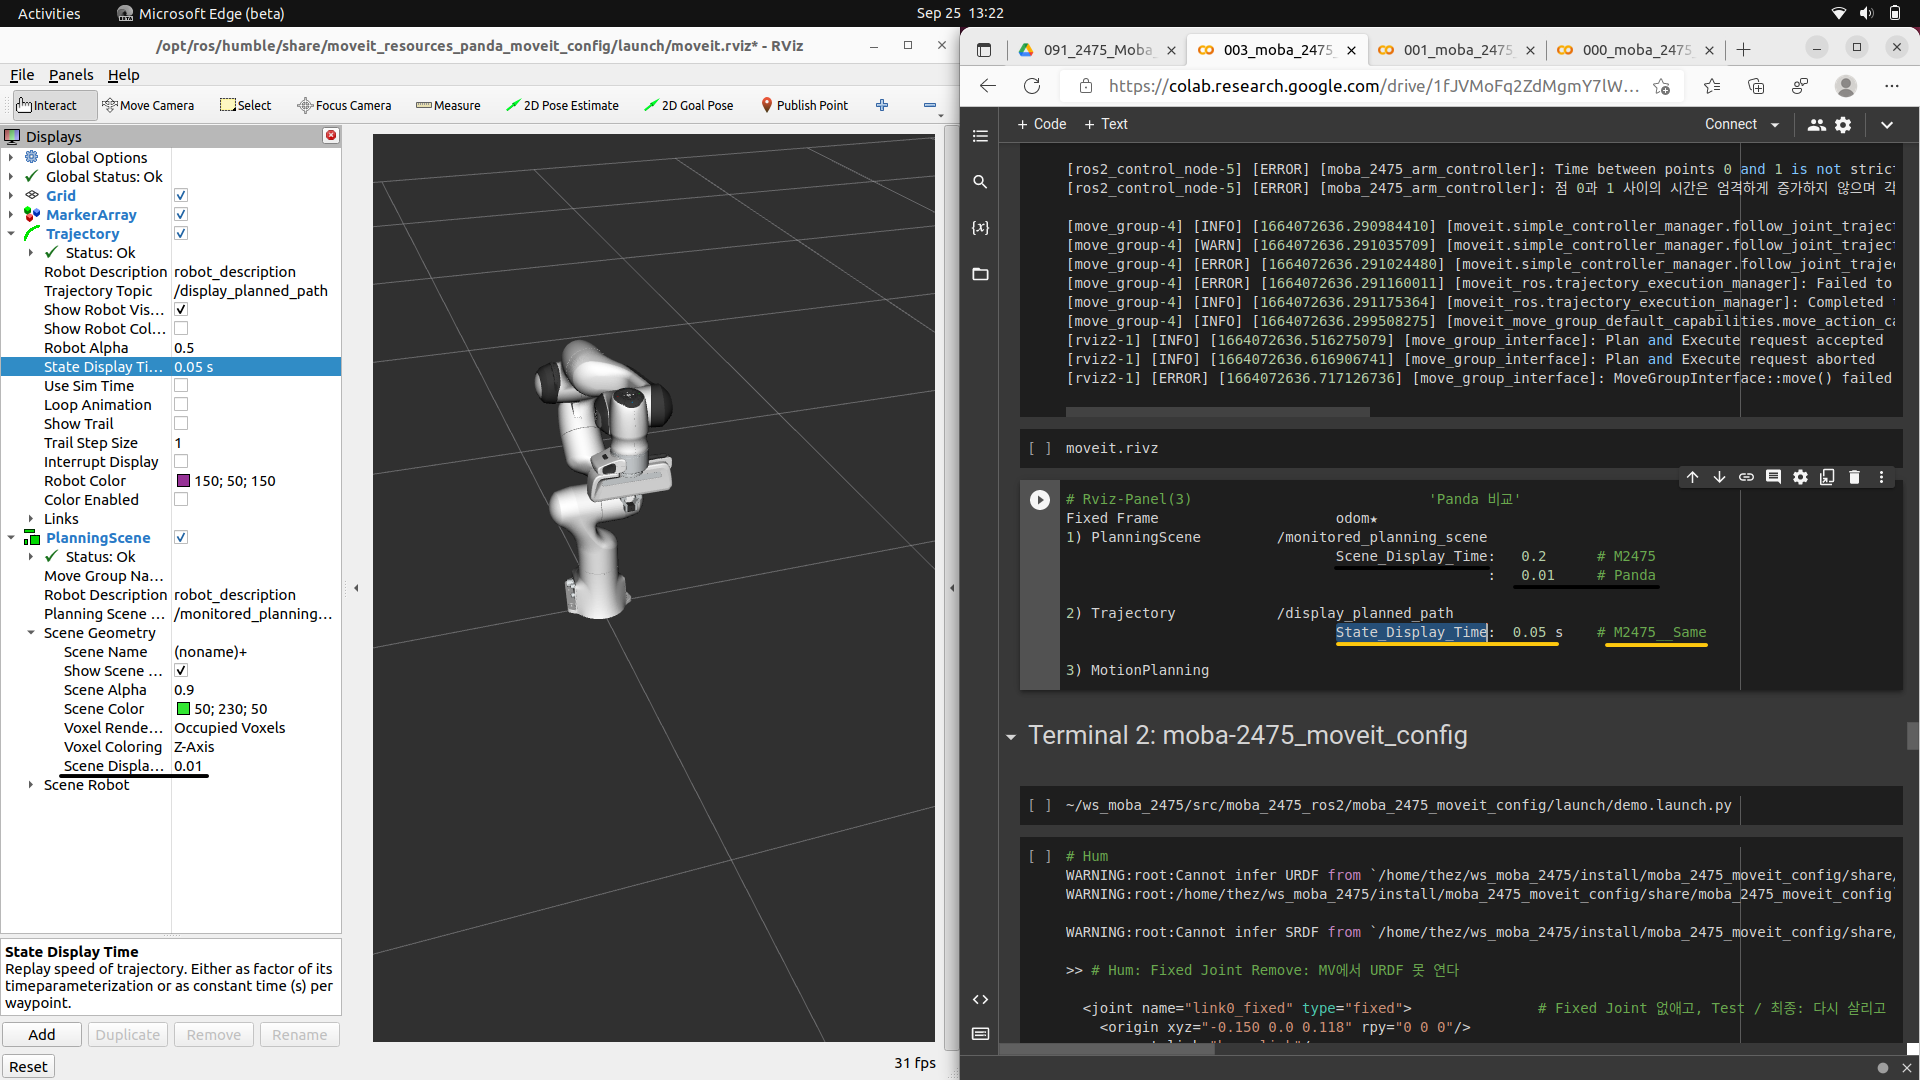

# Terminal 2: moba-2475_moveit_config

In [ ]:
~/ws_moba_2475/src/moba_2475_ros2/moba_2475_moveit_config/launch/demo.launch.py

In [ ]:
# Hum
WARNING:root:Cannot infer URDF from `/home/thez/ws_moba_2475/install/moba_2475_moveit_config/share/moba_2475_moveit_config`. -- using config/moba_2475.urdf
WARNING:root:/home/thez/ws_moba_2475/install/moba_2475_moveit_config/share/moba_2475_moveit_config`에서 URDF를 유추할 수 없습니다. -- config/moba_2475.urdf 사용

WARNING:root:Cannot infer SRDF from `/home/thez/ws_moba_2475/install/moba_2475_moveit_config/share/moba_2475_moveit_config`. -- using config/'moba_2475.srdf'

>> # Hum: Fixed Joint Remove: MV에서 URDF 못 연다

  <joint name="link0_fixed" type="fixed">               # Fixed Joint 없애고, Test / 최종: 다시 살리고
    <origin xyz="-0.150 0.0 0.118" rpy="0 0 0"/>
    <parent link="base_link"/>
    <child link="link0"/>
    <origin xyz="0 0 0" rpy="0 0 0"/>
  </joint>

In [ ]:
moveit_resources_panda_moveit_config/config
moveit_resources_panda


moba_2475_moveit_config/config
moba_2475

demo.launch.py

In [ ]:
import os
from launch import LaunchDescription
from launch.actions import DeclareLaunchArgument
from launch.substitutions import LaunchConfiguration
from launch.conditions import IfCondition, UnlessCondition
from launch_ros.actions import Node
from launch.actions import ExecuteProcess
from ament_index_python.packages import get_package_share_directory
from moveit_configs_utils import MoveItConfigsBuilder


def generate_launch_description():

    moveit_config = (
        MoveItConfigsBuilder("moba_2475")
        .robot_description(file_path="config/moba_2475.urdf.xacro")
        .robot_description_semantic(file_path="config/moba_2475.srdf.xacro")
        .trajectory_execution(file_path="config/moveit_simple_controllers.yaml")
        .planning_pipelines(pipelines=["ompl"])
        .to_moveit_configs()
    )

    # Start the actual move_group node/action server
    move_group_node = Node(
        package="moveit_ros_move_group",
        executable="move_group",
        output="screen",
        parameters=[moveit_config.to_dict()],
        arguments=["--ros-args", "--log-level", "info"],
    )

    # RViz
    rviz_base = os.path.join(
        get_package_share_directory("moba_2475_moveit_config"), "launch"
    )
    rviz_full_config = os.path.join(rviz_base, "moveit.rviz")

    rviz_node = Node(
        package="rviz2",
        executable="rviz2",
        name="rviz2",
        output="log",
        arguments=["-d", rviz_full_config],
        parameters=[
            moveit_config.robot_description,
            moveit_config.robot_description_semantic,
            moveit_config.planning_pipelines,
            moveit_config.robot_description_kinematics,
        ],
    )

    # Static TF
    static_tf_node = Node(
        package="tf2_ros",
        executable="static_transform_publisher",
        name="static_transform_publisher",
        output="log",
        arguments=["0.0", "0.0", "0.0", "0.0", "0.0", "0.0", "odom", "base_link"],
    )

    # Publish TF
    robot_state_publisher = Node(
        package="robot_state_publisher",
        executable="robot_state_publisher",
        name="robot_state_publisher",
        output="both",
        parameters=[moveit_config.robot_description],
    )

    # ros2_control using FakeSystem as hardware
    ros2_controllers_path = os.path.join(
        get_package_share_directory("moba_2475_moveit_config"),
        "config",
        "ros2_controllers.yaml",
    )
    ros2_control_node = Node(
        package="controller_manager",
        executable="ros2_control_node",
        parameters=[moveit_config.robot_description, ros2_controllers_path],
        output="screen",
    )

    joint_state_broadcaster_spawner = Node(
        package="controller_manager",
        executable="spawner",
        arguments=[
            "joint_state_broadcaster",
            "--controller-manager",
            "/controller_manager",
        ],
    )

    moba_2475_arm_controller_spawner = Node(
        package="controller_manager",
        executable="spawner",
        arguments=["moba_2475_arm_controller", "-c", "/controller_manager"],
    )

    moba_2475_gripper_controller_spawner = Node(
        package="controller_manager",
        executable="spawner",
        arguments=["moba_2475_gripper_controller", "-c", "/controller_manager"],
    )

    return LaunchDescription(
        [
            rviz_node,
            static_tf_node,
            robot_state_publisher,
            move_group_node,
            ros2_control_node,
            joint_state_broadcaster_spawner,
            moba_2475_arm_controller_spawner,
            moba_2475_gripper_controller_spawner
        ]
    )

In [ ]:
# 런치 완성


### joint_limits.yaml@

In [ ]:
~/ws_moba_2475/src/moba_2475_ros2/moba_2475_moveit_config/config/default_joint_limits.yaml

In [ ]:
# Hum: default_joint_limits.yaml   To     joint_limits.yaml

In [ ]:
# joint_limits.yaml allows the dynamics properties specified in the URDF to be overwritten or augmented as needed

# For beginners, we downscale velocity and acceleration limits.
# You can always specify higher scaling factors (<= 1.0) in your motion requests.  # Increase the values below to 1.0 to always move at maximum speed.
default_velocity_scaling_factor: 0.1
default_acceleration_scaling_factor: 0.1

# Specific joint properties can be changed with the keys [max_position, min_position, max_velocity, max_acceleration]
# Joint limits can be turned off with [has_velocity_limits, has_acceleration_limits]
joint_limits:
  joint1:
    has_velocity_limits: true
    max_velocity: 0.14
    has_acceleration_limits: true
    max_acceleration: 0.14
  joint2:
    has_velocity_limits: true
    max_velocity: 0.14
    has_acceleration_limits: true
    max_acceleration: 0.14
  joint3:
    has_velocity_limits: true
    max_velocity: 0.14
    has_acceleration_limits: true
    max_acceleration: 0.14
  joint4:
    has_velocity_limits: true
    max_velocity: 0.14
    has_acceleration_limits: true
    max_acceleration: 0.14
  joint5:
    has_velocity_limits: true
    max_velocity: 0.14
    has_acceleration_limits: true
    max_acceleration: 0.14
  gripper_joint:
    has_velocity_limits: true
    max_velocity: 4.0
    has_acceleration_limits: true
    max_acceleration: 10.0
  gripper_r_outer_joint:
    has_velocity_limits: true
    max_velocity: 4.0
    has_acceleration_limits: true
    max_acceleration: 10.0

In [ ]:
  position/x:
    has_velocity_limits: true
    max_velocity: 0.4
    has_acceleration_limits: true
    max_acceleration: 0.8
  position/y:
    has_velocity_limits: true
    max_velocity: 0.4
    has_acceleration_limits: true
    max_acceleration: 0.8
  position/theta:
    has_velocity_limits: true
    max_velocity: 1.0
    has_acceleration_limits: true
    max_acceleration: 1.6

### moba_2475.urdf.xacro@

In [ ]:
~/ws_moba_2475/src/moba_2475_ros2/moba_2475_moveit_config/config/

In [ ]:
# Hum: moba_2475.xacro    To       moba_2475.urdf.xacro

In [ ]:
<?xml version="1.0"?>
<robot xmlns:xacro="http://www.ros.org/wiki/xacro" name="moba_2475_description">
    <xacro:arg name="initial_positions_file" default="initial_positions.yaml" />

    <!-- Import M2475 urdf file -->
    <xacro:include filename="$(find moba_2475_description)/urdf/moba_2475_description.xacro" />

    <!-- Import M2475 ros2_control description -->
    <xacro:include filename="moba_2475_arm.ros2_control.xacro" />
    <xacro:include filename="gripper.ros2_control.xacro" />
    <!-- <xacro:include filename="moba_2475_base.ros2_control.xacro" /> -->

    <xacro:moba_2475_arm_ros2_control name="moba2475FakeSystem" initial_positions_file="$(arg initial_positions_file)"/>
    <xacro:gripper_ros2_control name="moba2475GripperFakeSystem"/>
    <!-- <xacro:moba_2475_base_ros2_control name="moba2475FakeSystem"/> -->

</robot>

### initial_positions.yaml@

In [ ]:
# Default initial positions for the panda arm's ros2_control fake system  __Zero
initial_positions:
  joint1: 0.0
  joint2: 0.0
  joint3: 1.5707
  joint4: 0.0
  joint5: 0.0

### moba_2475_arm.ros2_control.xacro@

In [ ]:
~/ws_moba_2475/src/moba_2475_ros2/moba_2475_moveit_config/config/moba_2475_arm.ros2_control.xacro

In [ ]:
# Hum: fake_components To mock_components

In [ ]:
<?xml version="1.0"?>
<robot xmlns:xacro="http://www.ros.org/wiki/xacro">

    <xacro:macro name="moba_2475_arm_ros2_control" params="name initial_positions_file">
        <xacro:property name="initial_positions" value="${load_yaml(initial_positions_file)['initial_positions']}"/>

        <ros2_control name="${name}" type="system">
            <hardware>
                <plugin>mock_components/GenericSystem</plugin>
            </hardware>
            <joint name="joint1">
                <command_interface name="position"/>
                <state_interface name="position">
                  <param name="initial_value">${initial_positions['joint1']}</param>
                </state_interface>
                <state_interface name="velocity"/>
            </joint>
            <joint name="joint2">
                <command_interface name="position"/>
                <state_interface name="position">
                  <param name="initial_value">${initial_positions['joint2']}</param>
                </state_interface>
                <state_interface name="velocity"/>
            </joint>
            <joint name="joint3">
                <command_interface name="position"/>
                <state_interface name="position">
                  <param name="initial_value">${initial_positions['joint3']}</param>
                </state_interface>
                <state_interface name="velocity"/>
            </joint>
            <joint name="joint4">
                <command_interface name="position"/>
                <state_interface name="position">
                  <param name="initial_value">${initial_positions['joint4']}</param>
                </state_interface>
                <state_interface name="velocity"/>
            </joint>
            <joint name="joint5">
                <command_interface name="position"/>
                <state_interface name="position">
                  <param name="initial_value">${initial_positions['joint5']}</param>
                </state_interface>
                <state_interface name="velocity"/>
            </joint>
        </ros2_control>
    </xacro:macro>
</robot>

### gripper.ros2_control.xacro@

In [ ]:
~/ws_moba_2475/src/moba_2475_ros2/moba_2475_moveit_config/config/gripper.ros2_control.xacro

In [ ]:
# Hum

In [ ]:
<?xml version="1.0"?>
<robot xmlns:xacro="http://www.ros.org/wiki/xacro">

    <xacro:macro name="gripper_ros2_control" params="name">
        <ros2_control name="${name}" type="system">
            <hardware>
                <plugin>mock_components/GenericSystem</plugin>
            </hardware>
            <!-- Left_Idol -->
            <joint name="gripper_joint">
                <command_interface name="position" />
                <state_interface name="position">
                  <param name="initial_value">0.0</param>
                </state_interface>
                <state_interface name="velocity"/>
            </joint>
            <!-- Right_Servo -->
            <joint name="gripper_r_outer_joint">
                <command_interface name="position" />
                <state_interface name="position">
                  <param name="initial_value">0.0</param>
                </state_interface>
                <state_interface name="velocity"/>
            </joint>
        </ros2_control>
    </xacro:macro>

</robot>

### moba_2475_base.ros2_control.xacro@

In [ ]:
~/ws_moba_2475/src/moba_2475_ros2/moba_2475_moveit_config/config/moba_2475_base.ros2_control.xacro

In [ ]:
# Hum: Plug 준비되면 사용하자     / initial_positions      's' 추가

In [ ]:
<?xml version="1.0"?>
<robot xmlns:xacro="http://www.ros.org/wiki/xacro">

    <xacro:macro name="moba_2475_base_ros2_control" params="name">

        <ros2_control name="${name}" type="system">
            <hardware>
                <plugin>mock_components/GenericSystem</plugin>
            </hardware>
            <joint name="position">
                <param name="initial_positions">0.0 0.0 0.0</param>
                <command_interface name="position" />
                <state_interface name="position"/>
                <state_interface name="velocity"/>
            </joint>
        </ros2_control>

    </xacro:macro>

</robot>

In [ ]:
# Gal

In [ ]:
<?xml version="1.0"?>
<robot xmlns:xacro="http://www.ros.org/wiki/xacro">

    <xacro:macro name="moba_2475_base_ros2_control" params="name">

        <ros2_control name="${name}" type="system">
            <hardware>
                <plugin>fake_components/GenericSystem</plugin>
            </hardware>
            <joint name="position">
                <param name="initial_position">0.0 0.0 0.0</param>
                <command_interface name="position" />
                <state_interface name="position"/>
                <state_interface name="velocity"/>
            </joint>
        </ros2_control>

    </xacro:macro>

</robot>

In [ ]:
# IGN: position 변경 완료






### moba_2475.srdf.xacro@

In [ ]:
~/ws_moba_2475/src/moba_2475_ros2/moba_2475_moveit_config/config/moba_2475_description.srdf

In [ ]:
# Hum: Position 관련 부분 주석 / Virtual_Joint 추가__link0
     : moba_2475_description.srdf   To   moba_2475.srdf        To     moba_2475.srdf.xacro

# Code Edit
    <group name="moba_2475_arm">
        <joint name="joint1 To 5" />
        <chain base_link="base_link" tip_link="eef" />        # Before
                              @
        <chain base_link="link0" tip_link="eef" />        # After

In [ ]:
[rviz2-1] [INFO] [1664065878.644998044] [moveit_robot_model.robot_model]: Loading robot model 'moba_2475_description'...
[rviz2-1] [WARN] [1664065878.645013406] [moveit_robot_model.robot_model]: Skipping virtual joint 'virtual_joint' because its child frame 'link0' does not match the URDF frame 'base_link'
[rviz2-1] [INFO] [1664065878.645019222] [moveit_robot_model.robot_model]: No root/virtual joint specified in SRDF. Assuming fixed joint
[rviz2-1] [WARN] [1664065878.646265261] [moveit_robot_model.robot_model]: Link camera_link has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.


In [ ]:
<?xml version="1.0" encoding="UTF-8"?>
<!--This does not replace URDF, and is not an extension of URDF.
    This is a format for representing semantic information about the robot structure.
    A URDF file must exist for this robot as well, where the joints and the links that are referenced are defined
-->
<robot name="moba_2475_description">
    <!--GROUPS: Representation of a set of joints and links. This can be useful for specifying DOF to plan for, defining arms, end effectors, etc-->
    <!--LINKS: When a link is specified, the parent joint of that link (if it exists) is automatically included-->
    <!--JOINTS: When a joint is specified, the child link of that joint (which will always exist) is automatically included-->
    <!--CHAINS: When a chain is specified, all the links along the chain (including endpoints) are included in the group. Additionally, all the joints that are parents to included links are also included. This means that joints along the chain and the parent joint of the base link are included in the group-->
    <!--SUBGROUPS: Groups can also be formed by referencing to already defined group names-->
    <group name="moba_2475_arm">
        <joint name="joint1" />
        <joint name="joint2" />
        <joint name="joint3" />
        <joint name="joint4" />
        <joint name="joint5" />
        <chain base_link="link0" tip_link="eef" />
    </group>
    <group name="gripper">
        <link name="gripper_l_outer_link_nm"/>
        <joint name="gripper_joint"/>
        <link name="gripper_r_outer_link"/>
        <joint name="gripper_r_outer_joint"/>
    </group>

    <!-- <group name="position">
        <joint name="position" />
    </group>
    <group name="mobile_base_arm">
        <group name="moba_2475_arm" />
        <group name="position" />
    </group> -->

    <!--GROUP STATES: Purpose: Define a named state for a particular group, in terms of joint values. This is useful to define states like 'folded arms'-->
    <group_state name="Upright" group="moba_2475_arm">
        <joint name="joint1" value="0" />
        <joint name="joint2" value="0" />
        <joint name="joint3" value="0" />
        <joint name="joint4" value="0" />
        <joint name="joint5" value="0" />
    </group_state>
    <group_state name="Lift" group="moba_2475_arm">
        <joint name="joint1" value="-0.725" />
        <joint name="joint2" value="0.8975" />
        <joint name="joint3" value="1.0356" />
        <joint name="joint4" value="0.6041" />
        <joint name="joint5" value="-0.5178" />
    </group_state>
    <group_state name="Zero" group="moba_2475_arm">
        <joint name="joint1" value="0" />
        <joint name="joint2" value="0" />
        <joint name="joint3" value="1.5707" />
        <joint name="joint4" value="0" />
        <joint name="joint5" value="0" />
    </group_state>
    <group_state name="Home" group="moba_2475_arm">
        <joint name="joint1" value="0" />
        <joint name="joint2" value="-0.8458" />
        <joint name="joint3" value="1.5707" />
        <joint name="joint4" value="0" />
        <joint name="joint5" value="1.5707" />
    </group_state>
    <group_state name="open" group="gripper">
        <joint name="gripper_joint" value="0.3" />
        <joint name="gripper_r_outer_joint" value="-0.3" />
    </group_state>
    <group_state name="close" group="gripper">
        <joint name="gripper_joint" value="0.90" />
        <joint name="gripper_r_outer_joint" value="-0.90" />
    </group_state>

    <!-- <group_state name="home_base" group="mobile_base_arm">
        <joint name="joint1" value="0"/>
        <joint name="joint2" value="0"/>
        <joint name="joint3" value="0"/>
        <joint name="joint4" value="0"/>
        <joint name="joint5" value="0"/>
        <joint name="position" value="0 0 0"/>
    </group_state>
    <group_state name="forward_base" group="mobile_base_arm">
        <joint name="joint1" value="0"/>
        <joint name="joint2" value="0"/>
        <joint name="joint3" value="0"/>
        <joint name="joint4" value="0"/>
        <joint name="joint5" value="0"/>
        <joint name="position" value="1 0 0"/>
    </group_state> -->

    <!--END EFFECTOR: Purpose: Represent information about an end effector.-->
    <end_effector group="gripper" name="gripper" parent_group="moba_2475_arm" parent_link="eef"/>

    <!--VIRTUAL JOINT: Purpose: this element defines a virtual joint between a robot link and an external frame of reference (considered fixed with respect to the robot)-->
    <virtual_joint child_link="link0" name="virtual_joint" parent_frame="base_link" type="floating"/>

    <!-- <virtual_joint name="position" type="planar" parent_frame="odom" child_link="base_link"/>
    <joint_property joint_name="position" property_name="motion_model" value="diff_drive" />
    <joint_property joint_name="position" property_name="min_translational_distance" value="0.05" /> -->

    <!--DISABLE COLLISIONS: By default it is assumed that any link of the robot could potentially come into collision with any other link in the robot. This tag disables collision checking between a specified pair of links. -->
    <disable_collisions link1="base_link" link2="laser" reason="Adjacent"/>
    <disable_collisions link1="base_link" link2="link0" reason="Adjacent"/>
    <disable_collisions link1="base_link" link2="link1" reason="Never"/>
    <disable_collisions link1="base_link" link2="link_caster" reason="Adjacent"/>
    <disable_collisions link1="base_link" link2="link_left_wheel" reason="Adjacent"/>
    <disable_collisions link1="base_link" link2="link_right_wheel" reason="Adjacent"/>
    <disable_collisions link1="gripper_l_outer_link_nm" link2="gripper_r_outer_link" reason="Default"/>
    <disable_collisions link1="gripper_l_outer_link_nm" link2="link5" reason="Adjacent"/>
    <disable_collisions link1="gripper_r_outer_link" link2="link5" reason="Adjacent"/>
    <disable_collisions link1="laser" link2="link0" reason="Never"/>
    <disable_collisions link1="laser" link2="link1" reason="Never"/>
    <disable_collisions link1="laser" link2="link_caster" reason="Never"/>
    <disable_collisions link1="laser" link2="link_left_wheel" reason="Never"/>
    <disable_collisions link1="laser" link2="link_right_wheel" reason="Never"/>
    <disable_collisions link1="link0" link2="link1" reason="Adjacent"/>
    <disable_collisions link1="link0" link2="link_caster" reason="Never"/>
    <disable_collisions link1="link0" link2="link_left_wheel" reason="Never"/>
    <disable_collisions link1="link0" link2="link_right_wheel" reason="Never"/>
    <disable_collisions link1="link1" link2="link2" reason="Adjacent"/>
    <disable_collisions link1="link1" link2="link_caster" reason="Never"/>
    <disable_collisions link1="link1" link2="link_left_wheel" reason="Never"/>
    <disable_collisions link1="link1" link2="link_right_wheel" reason="Never"/>
    <disable_collisions link1="link2" link2="link3" reason="Adjacent"/>
    <disable_collisions link1="link2" link2="link_caster" reason="Never"/>
    <disable_collisions link1="link2" link2="link_left_wheel" reason="Never"/>
    <disable_collisions link1="link2" link2="link_right_wheel" reason="Never"/>
    <disable_collisions link1="link3" link2="link4" reason="Adjacent"/>
    <disable_collisions link1="link3" link2="link_caster" reason="Never"/>
    <disable_collisions link1="link3" link2="link_right_wheel" reason="Never"/>
    <disable_collisions link1="link4" link2="link5" reason="Adjacent"/>
    <disable_collisions link1="link_caster" link2="link_left_wheel" reason="Never"/>
    <disable_collisions link1="link_caster" link2="link_right_wheel" reason="Never"/>
    <disable_collisions link1="link_left_wheel" link2="link_right_wheel" reason="Never"/>

    <!-- Temporary measure to ignore collisions between the two pieces of the gripper
        until we figure out a better model for the gripper. -->
    <disable_collisions link1="gripper_l_outer_link_nm" link2="gripper_r_outer_link" reason="physics"/>

    <!-- Ignore collision between caster wheel and base link -->
    <disable_collisions link1="link_caster" link2="base_link" reason="physics"/>
</robot>

### kinematics.yaml@

In [ ]:
~/ws_moba_2475/src/moba_2475_ros2/moba_2475_moveit_config/config/kinematics.yaml

In [ ]:
# Hum
moba_2475_arm:
  kinematics_solver_timeout: 0.05        # Hum
  kinematics_solver_timeout: 0.005       # Gal

In [ ]:
moba_2475_arm:
  kinematics_solver: kdl_kinematics_plugin/KDLKinematicsPlugin
  kinematics_solver_search_resolution: 0.005
  kinematics_solver_timeout: 0.05

In [ ]:
mobile_base_arm:      '입력전'
  kinematics_solver: stretch_kinematics_plugin/StretchKinematicsPlugin
  kinematics_solver_search_resolution: 0.005
  kinematics_solver_timeout: 0.1

In [ ]:
# Gal

In [ ]:
moba_2475_arm:
  kinematics_solver: kdl_kinematics_plugin/KDLKinematicsPlugin
  kinematics_solver_search_resolution: 0.005
  kinematics_solver_timeout: 0.005
mobile_base_arm:
  kinematics_solver: stretch_kinematics_plugin/StretchKinematicsPlugin
  kinematics_solver_search_resolution: 0.005
  kinematics_solver_timeout: 0.1

### sensors_3d.yaml__추후에

In [ ]:
~/ws_moba_2475/src/moba_2475_ros2/moba_2475_moveit_config/config/sensors_3d.yaml

In [ ]:
# The name of this file shouldn't be changed, or else the Setup Assistant won't detect it
sensors:
  - head_cloud
head_cloud:
    filtered_cloud_topic: /realsense/depth/color/points/filtered
    max_range: 1.2
    max_update_rate: 0.1
    padding_offset: 0.1
    padding_scale: 1.0
    point_cloud_topic: /realsense/depth/color/points # this is pointed to a empty topic to disable it
    point_subsample: 1
    sensor_plugin: occupancy_map_monitor/PointCloudOctomapUpdater
octomap_resolution: 0.03
# robot_description_planning/shape_transform_cache_lookup_wait_time: 0

### ompl_planning.yaml@@

In [ ]:
~/ws_moba_2475/src/moba_2475_ros2/moba_2475_moveit_config/config/ompl_planning.yaml

In [ ]:
# Hum

In [ ]:
planning_plugin: ompl_interface/OMPLPlanner
request_adapters: >-
  default_planner_request_adapters/AddTimeOptimalParameterization
  default_planner_request_adapters/ResolveConstraintFrames
  default_planner_request_adapters/FixWorkspaceBounds
  default_planner_request_adapters/FixStartStateBounds
  default_planner_request_adapters/FixStartStateCollision
  default_planner_request_adapters/FixStartStatePathConstraints
start_state_max_bounds_error: 0.1
planner_configs:
  SBLkConfigDefault:
    type: geometric::SBL
    range: 0.0  # Max motion added to tree. ==> maxDistance_ default: 0.0, if 0.0, set on setup()
  ESTkConfigDefault:
    type: geometric::EST
    range: 0.0  # Max motion added to tree. ==> maxDistance_ default: 0.0, if 0.0 setup()
    goal_bias: 0.05  # When close to goal select goal, with this probability. default: 0.05
  LBKPIECEkConfigDefault:
    type: geometric::LBKPIECE
    range: 0.0  # Max motion added to tree. ==> maxDistance_ default: 0.0, if 0.0, set on setup()
    border_fraction: 0.9  # Fraction of time focused on boarder default: 0.9
    min_valid_path_fraction: 0.5  # Accept partially valid moves above fraction. default: 0.5
  BKPIECEkConfigDefault:
    type: geometric::BKPIECE
    range: 0.0  # Max motion added to tree. ==> maxDistance_ default: 0.0, if 0.0, set on setup()
    border_fraction: 0.9  # Fraction of time focused on boarder default: 0.9
    failed_expansion_score_factor: 0.5  # When extending motion fails, scale score by factor. default: 0.5
    min_valid_path_fraction: 0.5  # Accept partially valid moves above fraction. default: 0.5
  KPIECEkConfigDefault:
    type: geometric::KPIECE
    range: 0.0  # Max motion added to tree. ==> maxDistance_ default: 0.0, if 0.0, set on setup()
    goal_bias: 0.05  # When close to goal select goal, with this probability. default: 0.05
    border_fraction: 0.9  # Fraction of time focused on boarder default: 0.9 (0.0,1.]
    failed_expansion_score_factor: 0.5  # When extending motion fails, scale score by factor. default: 0.5
    min_valid_path_fraction: 0.5  # Accept partially valid moves above fraction. default: 0.5
  RRTkConfigDefault:
    type: geometric::RRT
    range: 0.0  # Max motion added to tree. ==> maxDistance_ default: 0.0, if 0.0, set on setup()
    goal_bias: 0.05  # When close to goal select goal, with this probability? default: 0.05
  RRTConnectkConfigDefault:
    type: geometric::RRTConnect
    range: 0.0  # Max motion added to tree. ==> maxDistance_ default: 0.0, if 0.0, set on setup()
  RRTstarkConfigDefault:
    type: geometric::RRTstar
    range: 0.0  # Max motion added to tree. ==> maxDistance_ default: 0.0, if 0.0, set on setup()
    goal_bias: 0.05  # When close to goal select goal, with this probability? default: 0.05
    delay_collision_checking: 1  # Stop collision checking as soon as C-free parent found. default 1
  TRRTkConfigDefault:
    type: geometric::TRRT
    range: 0.0  # Max motion added to tree. ==> maxDistance_ default: 0.0, if 0.0, set on setup()
    goal_bias: 0.05  # When close to goal select goal, with this probability? default: 0.05
    max_states_failed: 10  # when to start increasing temp. default: 10
    temp_change_factor: 2.0  # how much to increase or decrease temp. default: 2.0
    min_temperature: 10e-10  # lower limit of temp change. default: 10e-10
    init_temperature: 10e-6  # initial temperature. default: 10e-6
    frountier_threshold: 0.0  # dist new state to nearest neighbor to disqualify as frontier. default: 0.0 set in setup()
    frountierNodeRatio: 0.1  # 1/10, or 1 nonfrontier for every 10 frontier. default: 0.1
    k_constant: 0.0  # value used to normalize expresssion. default: 0.0 set in setup()
  PRMkConfigDefault:
    type: geometric::PRM
    max_nearest_neighbors: 10  # use k nearest neighbors. default: 10
  PRMstarkConfigDefault:
    type: geometric::PRMstar
  FMTkConfigDefault:
    type: geometric::FMT
    num_samples: 1000  # number of states that the planner should sample. default: 1000
    radius_multiplier: 1.1  # multiplier used for the nearest neighbors search radius. default: 1.1
    nearest_k: 1  # use Knearest strategy. default: 1
    cache_cc: 1  # use collision checking cache. default: 1
    heuristics: 0  # activate cost to go heuristics. default: 0
    extended_fmt: 1  # activate the extended FMT*: adding new samples if planner does not finish successfully. default: 1
  BFMTkConfigDefault:
    type: geometric::BFMT
    num_samples: 1000  # number of states that the planner should sample. default: 1000
    radius_multiplier: 1.0  # multiplier used for the nearest neighbors search radius. default: 1.0
    nearest_k: 1  # use the Knearest strategy. default: 1
    balanced: 0  # exploration strategy: balanced true expands one tree every iteration. False will select the tree with lowest maximum cost to go. default: 1
    optimality: 1  # termination strategy: optimality true finishes when the best possible path is found. Otherwise, the algorithm will finish when the first feasible path is found. default: 1
    heuristics: 1  # activates cost to go heuristics. default: 1
    cache_cc: 1  # use the collision checking cache. default: 1
    extended_fmt: 1  # Activates the extended FMT*: adding new samples if planner does not finish successfully. default: 1
  PDSTkConfigDefault:
    type: geometric::PDST
  STRIDEkConfigDefault:
    type: geometric::STRIDE
    range: 0.0  # Max motion added to tree. ==> maxDistance_ default: 0.0, if 0.0, set on setup()
    goal_bias: 0.05  # When close to goal select goal, with this probability. default: 0.05
    use_projected_distance: 0  # whether nearest neighbors are computed based on distances in a projection of the state rather distances in the state space itself. default: 0
    degree: 16  # desired degree of a node in the Geometric Near-neightbor Access Tree (GNAT). default: 16
    max_degree: 18  # max degree of a node in the GNAT. default: 12
    min_degree: 12  # min degree of a node in the GNAT. default: 12
    max_pts_per_leaf: 6  # max points per leaf in the GNAT. default: 6
    estimated_dimension: 0.0  # estimated dimension of the free space. default: 0.0
    min_valid_path_fraction: 0.2  # Accept partially valid moves above fraction. default: 0.2
  BiTRRTkConfigDefault:
    type: geometric::BiTRRT
    range: 0.0  # Max motion added to tree. ==> maxDistance_ default: 0.0, if 0.0, set on setup()
    temp_change_factor: 0.1  # how much to increase or decrease temp. default: 0.1
    init_temperature: 100  # initial temperature. default: 100
    frountier_threshold: 0.0  # dist new state to nearest neighbor to disqualify as frontier. default: 0.0 set in setup()
    frountier_node_ratio: 0.1  # 1/10, or 1 nonfrontier for every 10 frontier. default: 0.1
    cost_threshold: 1e300  # the cost threshold. Any motion cost that is not better will not be expanded. default: inf
  LBTRRTkConfigDefault:
    type: geometric::LBTRRT
    range: 0.0  # Max motion added to tree. ==> maxDistance_ default: 0.0, if 0.0, set on setup()
    goal_bias: 0.05  # When close to goal select goal, with this probability. default: 0.05
    epsilon: 0.4  # optimality approximation factor. default: 0.4
  BiESTkConfigDefault:
    type: geometric::BiEST
    range: 0.0  # Max motion added to tree. ==> maxDistance_ default: 0.0, if 0.0, set on setup()
  ProjESTkConfigDefault:
    type: geometric::ProjEST
    range: 0.0  # Max motion added to tree. ==> maxDistance_ default: 0.0, if 0.0, set on setup()
    goal_bias: 0.05  # When close to goal select goal, with this probability. default: 0.05
  LazyPRMkConfigDefault:
    type: geometric::LazyPRM
    range: 0.0  # Max motion added to tree. ==> maxDistance_ default: 0.0, if 0.0, set on setup()
  LazyPRMstarkConfigDefault:
    type: geometric::LazyPRMstar
  SPARSkConfigDefault:
    type: geometric::SPARS
    stretch_factor: 3.0  # roadmap spanner stretch factor. multiplicative upper bound on path quality. It does not make sense to make this parameter more than 3. default: 3.0
    sparse_delta_fraction: 0.25  # delta fraction for connection distance. This value represents the visibility range of sparse samples. default: 0.25
    dense_delta_fraction: 0.001  # delta fraction for interface detection. default: 0.001
    max_failures: 1000  # maximum consecutive failure limit. default: 1000
  SPARStwokConfigDefault:
    type: geometric::SPARStwo
    stretch_factor: 3.0  # roadmap spanner stretch factor. multiplicative upper bound on path quality. It does not make sense to make this parameter more than 3. default: 3.0
    sparse_delta_fraction: 0.25  # delta fraction for connection distance. This value represents the visibility range of sparse samples. default: 0.25
    dense_delta_fraction: 0.001  # delta fraction for interface detection. default: 0.001
    max_failures: 5000  # maximum consecutive failure limit. default: 5000
  TrajOptDefault:
    type: geometric::TrajOpt

moba_2475_arm:
  planner_configs:
    - SBLkConfigDefault
    - ESTkConfigDefault
    - LBKPIECEkConfigDefault
    - BKPIECEkConfigDefault
    - KPIECEkConfigDefault
    - RRTkConfigDefault
    - RRTConnectkConfigDefault
    - RRTstarkConfigDefault
    - TRRTkConfigDefault
    - PRMkConfigDefault
    - PRMstarkConfigDefault
    - FMTkConfigDefault
    - BFMTkConfigDefault
    - PDSTkConfigDefault
    - STRIDEkConfigDefault
    - BiTRRTkConfigDefault
    - LBTRRTkConfigDefault
    - BiESTkConfigDefault
    - ProjESTkConfigDefault
    - LazyPRMkConfigDefault
    - LazyPRMstarkConfigDefault
    - SPARSkConfigDefault
    - SPARStwokConfigDefault
    - TrajOptDefault
gripper:
  planner_configs:
    - SBLkConfigDefault
    - ESTkConfigDefault
    - LBKPIECEkConfigDefault
    - BKPIECEkConfigDefault
    - KPIECEkConfigDefault
    - RRTkConfigDefault
    - RRTConnectkConfigDefault
    - RRTstarkConfigDefault
    - TRRTkConfigDefault
    - PRMkConfigDefault
    - PRMstarkConfigDefault
    - FMTkConfigDefault
    - BFMTkConfigDefault
    - PDSTkConfigDefault
    - STRIDEkConfigDefault
    - BiTRRTkConfigDefault
    - LBTRRTkConfigDefault
    - BiESTkConfigDefault
    - ProjESTkConfigDefault
    - LazyPRMkConfigDefault
    - LazyPRMstarkConfigDefault
    - SPARSkConfigDefault
    - SPARStwokConfigDefault
    - TrajOptDefault

### moveit_simple_controllers.yaml@@

In [ ]:
~/ws_moba_2475/src/moba_2475_ros2/moba_2475_moveit_config/config/moveit_simple_controllers.yaml

In [ ]:
# Hum
gripper_moveit_controllers.yaml           # Panda: arm, Gripper 분리
moveit_simple_controllers.yaml            # M2475: IGN 호환, 통합

In [ ]:
# MoveIt uses this configuration for controller management
trajectory_execution:
  allowed_execu# Galtion_duration_scaling: 1.2
  allowed_goal_duration_margin: 0.5
  allowed_start_tolerance: 0.01

moveit_controller_manager: moveit_simple_controller_manager/MoveItSimpleControllerManager

moveit_simple_controller_manager:
  controller_names:
    - moba_2475_arm_controller
    - moba_2475_gripper_controller

  moba_2475_arm_controller:
    action_ns: follow_joint_trajectory
    type: FollowJointTrajectory
    default: true
    joints:
      - joint1
      - joint2
      - joint3
      - joint4
      - joint5

  moba_2475_gripper_controller:
    action_ns: gripper_cmd
    type: GripperCommand
    default: true
    joints:
      - gripper_joint
      - gripper_r_outer_joint

In [ ]:
#      - position

### ros2_controllers.yaml@@@


In [ ]:
~/ws_moba_2475/src/moba_2475_ros2/moba_2475_moveit_config/config/ros2_controllers.yaml

In [ ]:
# Hum / Gal Apply
ros2_controllers.yaml           # Panda: arm, Gripper 분리
ros2_controllers.yaml           # M2475: IGN 호환, 통합     /     이름 변경: ros_controllers.yaml__Gal

In [ ]:
# This config file is used by ros2_control
controller_manager:
  ros__parameters:
    update_rate: 100  # Hz

    moba_2475_arm_controller:
      type: joint_trajectory_controller/JointTrajectoryController

    moba_2475_gripper_controller:
      type: position_controllers/GripperActionController

    joint_state_broadcaster:
      type: joint_state_broadcaster/JointStateBroadcaster

moba_2475_arm_controller:
  ros__parameters:
    command_interfaces:
      - position
    state_interfaces:
      - position
      - velocity
    joints:
      - joint1
      - joint2
      - joint3
      - joint4
      - joint5

moba_2475_gripper_controller:
  ros__parameters:
    joint: gripper_joint                 # Active_OK
    joint: gripper_r_outer_joint

In [ ]:
    joints:                              # Not_Active
      - gripper_joint
      - gripper_r_outer_joint

In [ ]:
#      - position

## pilz_cartesian_limits.yaml@

In [ ]:
처음 Test 할때,  없다고 해서 넣어줌

In [ ]:
# Cartesian limits for the Pilz planner
cartesian_limits:
  max_trans_vel: 1.0
  max_trans_acc: 2.25
  max_trans_dec: -5.0
  max_rot_vel: 1.57

## CMakeLists.txt@

In [ ]:
# Hum

In [ ]:
cmake_minimum_required(VERSION 3.10.2)
project(moba_2475_moveit_config)
find_package(ament_cmake REQUIRED)

ament_package()

install(DIRECTORY launch DESTINATION share/${PROJECT_NAME})
install(DIRECTORY config DESTINATION share/${PROJECT_NAME})
install(FILES .setup_assistant DESTINATION share/${PROJECT_NAME})

## package.xml@

In [ ]:
# Hum

In [ ]:
<?xml version="1.0"?>
<package format="3">
  <name>moba_2475_moveit_config</name>
  <version>0.0.0</version>
  <description>moba_2475 move_group config package</description>
  <author email="mdc1020@naver.com">thek</author>
  <maintainer email="mdc1020@naver.com">thek</maintainer>

  <license>BSD</license>

  <url type="website">http://moveit.ros.org/</url>
  <url type="bugtracker">https://github.com/ros-planning/moveit_resources/issues</url>
  <url type="repository">https://github.com/ros-planning/moveit_resources</url>

  <buildtool_depend>ament_cmake</buildtool_depend>

  <exec_depend>moba_2475_description</exec_depend>
  <!-- disabled to remove circular dependencies
  <exec_depend>moveit_ros_move_group</exec_depend>
  <exec_depend>moveit_fake_controller_manager</exec_depend>
  <exec_depend>moveit_kinematics</exec_depend>
  <exec_depend>moveit_planners_ompl</exec_depend>
  <exec_depend>moveit_ros_visualization</exec_depend>
  -->
  <exec_depend>joint_state_publisher</exec_depend>
  <exec_depend>joint_state_publisher_gui</exec_depend>
  <exec_depend>robot_state_publisher</exec_depend>
  <exec_depend>xacro</exec_depend>
  <!-- TODO(#40): Package not available in ROS 2, find equivalent when migrating launch files
  <exec_depend>topic_tools</exec_depend>
  -->
  <!-- This package is referenced in the warehouse launch files, but does not build out of the box at the moment.
       Commented the dependency until this works. -->
  <!-- <exec_depend>warehouse_ros_mongo</exec_depend> -->

  <export>
      <build_type>ament_cmake</build_type>
  </export>
</package>

# stretch_ignition_control

### moba_2475_ignition_control_action_server

In [ ]:
stretch_controller >> moba_2475_controller >> 6개소 변경

In [ ]:
~/ws_moba_2475/src/moba_2475_ros2/moba_2475_ignition_control/moba_2475_ignition_control/moba_2475_ignition_control_action_server.py

In [ ]:
from control_msgs.action import FollowJointTrajectory
from trajectory_msgs.msg import JointTrajectory
from trajectory_msgs.msg import MultiDOFJointTrajectory
from geometry_msgs.msg import Twist, PoseStamped
from nav_msgs.msg import Odometry
import rclpy
from rclpy.action import ActionServer, server
from rclpy.node import Node
import time
from math import sqrt
from nav2_simple_commander.robot_navigator import BasicNavigator


class FollowJointTrajectoryActionServer(Node):

    def __init__(self):
        super().__init__('follow_joint_trajectory_action_server')
        print("Starting action server")
        self.odom = Odometry()
        self._joint_trajectory_publisher = self.create_publisher(JointTrajectory, '/joint_trajectory', 10)
        self._cmd_vel_publisher = self.create_publisher(Twist, '/cmd_vel', 10)
        self._action_server = ActionServer(
            self,
            FollowJointTrajectory,
            '/moba_2475_controller/follow_joint_trajectory',
            self.execute_callback)
        self.odom_subscriber = self.create_subscription(
            Odometry, 'odom', self.odom_callback, 10)
        print("Initializing nav2 client")
        self.nav = BasicNavigator()
        initial_pose = PoseStamped()
        initial_pose.header.frame_id = "odom"
        initial_pose.header.stamp = self.get_clock().now().to_msg()
        self.nav.setInitialPose(initial_pose)

    def odom_callback(self, msg: Odometry):
        self.odom = msg

    def execute_callback(self, goal_handle: server.ServerGoalHandle):
        self.get_logger().info('Executing goal...')
        result = FollowJointTrajectory.Result()
        trajectory = goal_handle.request.trajectory # type: JointTrajectory
        self._joint_trajectory_publisher.publish(trajectory)
        multidof_trajectory = goal_handle.request.multi_dof_trajectory # type: MultiDOFJointTrajectory
        goal_pose = PoseStamped()
        goal_pose.header.frame_id = "odom"
        goal_pose.header.stamp = self.get_clock().now().to_msg()
        goal_pose.pose.position.x = multidof_trajectory.points[-1].transforms[0].translation.x
        goal_pose.pose.position.y = multidof_trajectory.points[-1].transforms[0].translation.y
        goal_pose.pose.position.z = multidof_trajectory.points[-1].transforms[0].translation.z
        goal_pose.pose.orientation.x = multidof_trajectory.points[-1].transforms[0].rotation.x
        goal_pose.pose.orientation.y = multidof_trajectory.points[-1].transforms[0].rotation.y
        goal_pose.pose.orientation.z = multidof_trajectory.points[-1].transforms[0].rotation.z
        goal_pose.pose.orientation.w = multidof_trajectory.points[-1].transforms[0].rotation.w
        print("Target pose:", goal_pose.pose)
        self.nav.goToPose(goal_pose)
        goal_handle.succeed()
        return result

def main(args=None):
    rclpy.init(args=args)
    follow_joint_trajectory_action_server = FollowJointTrajectoryActionServer()
    rclpy.spin(follow_joint_trajectory_action_server)

if __name__ == '__main__':
    main()


### N